In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Load the model and test it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
model = resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model.to(device).eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of ResNet18 on CIFAR-10 test images: {100 * correct / total:.2f}%')

# Display the model architecture
print(model)

# Count eligible layers for quantization
quantizable_layers = [module for module in model.modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
print(f"Number of layers eligible for quantization: {len(quantizable_layers)}")

Files already downloaded and verified
Accuracy of ResNet18 on CIFAR-10 test images: 82.62%
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-0

In [9]:
# Quantization function
def uniform_quantization(num_bits):
    def quant(x: torch.Tensor):
        min_val = x.min()
        max_val = x.max()
        alpha = max_val - min_val
        x = (x - min_val) / alpha
        scale = (2**num_bits - 1)
        result = (scale * x).round()
        result /= scale
        result = alpha * result + min_val
        return result
    return quant

def quantize_layer(layer, num_bits: int):
    quantize = uniform_quantization(num_bits)
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        layer.weight.data = quantize(layer.weight.data)
        if layer.bias is not None:
            layer.bias.data = quantize(layer.bias.data)
    return layer

# Evaluation function
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Run experiment
baseline_accuracy = evaluate_model(model)
print(f"Baseline accuracy: {baseline_accuracy:.2f}%")

results = {}
bit_sizes = [16, 8, 6, 4, 2]
N = len(quantizable_layers)

for b in bit_sizes:
    results[b] = []
    for k in tqdm(range(1, N+1), desc=f"Bit size {b}"):
        for i in tqdm(range(N-k+1), desc=f"Convolution size {k}"):
            model_copy = resnet18()
            model_copy.fc = nn.Linear(model_copy.fc.in_features, 10)
            model_copy.load_state_dict(torch.load('resnet18_cifar10.pth'))
            model_copy.to(device).eval()
            
            layers_to_quantize = list(model_copy.modules())[1:][i:i+k]  # Skip the main module
            for layer in layers_to_quantize:
                quantize_layer(layer, b)
            
            accuracy = evaluate_model(model_copy)
            results[b].append((i, k, accuracy))
            # Print accuracy for each combination
            print(f"Bit size: {b}, Start index: {i}, Width: {k}, Accuracy: {accuracy:.2f}%")

print("Finished runs")

Baseline accuracy: 82.62%


Convolution size 1:   5%|██▋                                                     | 1/21 [00:01<00:30,  1.52s/it]

Bit size: 16, Start index: 0, Width: 1, Accuracy: 82.62%



Convolution size 1:  10%|█████▎                                                  | 2/21 [00:02<00:28,  1.50s/it]

Bit size: 16, Start index: 1, Width: 1, Accuracy: 82.62%



Convolution size 1:  14%|████████                                                | 3/21 [00:04<00:26,  1.49s/it]

Bit size: 16, Start index: 2, Width: 1, Accuracy: 82.62%



Convolution size 1:  19%|██████████▋                                             | 4/21 [00:06<00:25,  1.51s/it]

Bit size: 16, Start index: 3, Width: 1, Accuracy: 82.62%



Convolution size 1:  24%|█████████████▎                                          | 5/21 [00:07<00:23,  1.49s/it]

Bit size: 16, Start index: 4, Width: 1, Accuracy: 82.62%



Convolution size 1:  29%|████████████████                                        | 6/21 [00:08<00:22,  1.47s/it]

Bit size: 16, Start index: 5, Width: 1, Accuracy: 82.62%



Convolution size 1:  33%|██████████████████▋                                     | 7/21 [00:10<00:20,  1.48s/it]

Bit size: 16, Start index: 6, Width: 1, Accuracy: 82.62%



Convolution size 1:  38%|█████████████████████▎                                  | 8/21 [00:11<00:19,  1.50s/it]

Bit size: 16, Start index: 7, Width: 1, Accuracy: 82.62%



Convolution size 1:  43%|████████████████████████                                | 9/21 [00:13<00:18,  1.52s/it]

Bit size: 16, Start index: 8, Width: 1, Accuracy: 82.62%



Convolution size 1:  48%|██████████████████████████▏                            | 10/21 [00:15<00:16,  1.52s/it]

Bit size: 16, Start index: 9, Width: 1, Accuracy: 82.62%



Convolution size 1:  52%|████████████████████████████▊                          | 11/21 [00:16<00:15,  1.52s/it]

Bit size: 16, Start index: 10, Width: 1, Accuracy: 82.62%



Convolution size 1:  57%|███████████████████████████████▍                       | 12/21 [00:18<00:13,  1.52s/it]

Bit size: 16, Start index: 11, Width: 1, Accuracy: 82.62%



Convolution size 1:  62%|██████████████████████████████████                     | 13/21 [00:19<00:12,  1.54s/it]

Bit size: 16, Start index: 12, Width: 1, Accuracy: 82.62%



Convolution size 1:  67%|████████████████████████████████████▋                  | 14/21 [00:21<00:10,  1.52s/it]

Bit size: 16, Start index: 13, Width: 1, Accuracy: 82.62%



Convolution size 1:  71%|███████████████████████████████████████▎               | 15/21 [00:22<00:09,  1.51s/it]

Bit size: 16, Start index: 14, Width: 1, Accuracy: 82.62%



Convolution size 1:  76%|█████████████████████████████████████████▉             | 16/21 [00:24<00:07,  1.50s/it]

Bit size: 16, Start index: 15, Width: 1, Accuracy: 82.63%



Convolution size 1:  81%|████████████████████████████████████████████▌          | 17/21 [00:25<00:06,  1.52s/it]

Bit size: 16, Start index: 16, Width: 1, Accuracy: 82.62%



Convolution size 1:  86%|███████████████████████████████████████████████▏       | 18/21 [00:27<00:04,  1.54s/it]

Bit size: 16, Start index: 17, Width: 1, Accuracy: 82.62%



Convolution size 1:  90%|█████████████████████████████████████████████████▊     | 19/21 [00:28<00:03,  1.56s/it]

Bit size: 16, Start index: 18, Width: 1, Accuracy: 82.62%



Convolution size 1:  95%|████████████████████████████████████████████████████▍  | 20/21 [00:30<00:01,  1.57s/it]

Bit size: 16, Start index: 19, Width: 1, Accuracy: 82.62%



Bit size 16:   5%|███                                                            | 1/21 [00:32<10:42, 32.10s/it]

Bit size: 16, Start index: 20, Width: 1, Accuracy: 82.62%



Convolution size 2:   5%|██▊                                                     | 1/20 [00:01<00:29,  1.54s/it]

Bit size: 16, Start index: 0, Width: 2, Accuracy: 82.62%



Convolution size 2:  10%|█████▌                                                  | 2/20 [00:03<00:27,  1.52s/it]

Bit size: 16, Start index: 1, Width: 2, Accuracy: 82.62%



Convolution size 2:  15%|████████▍                                               | 3/20 [00:04<00:25,  1.52s/it]

Bit size: 16, Start index: 2, Width: 2, Accuracy: 82.62%



Convolution size 2:  20%|███████████▏                                            | 4/20 [00:06<00:24,  1.53s/it]

Bit size: 16, Start index: 3, Width: 2, Accuracy: 82.62%



Convolution size 2:  25%|██████████████                                          | 5/20 [00:07<00:23,  1.55s/it]

Bit size: 16, Start index: 4, Width: 2, Accuracy: 82.62%



Convolution size 2:  30%|████████████████▊                                       | 6/20 [00:09<00:21,  1.53s/it]

Bit size: 16, Start index: 5, Width: 2, Accuracy: 82.62%



Convolution size 2:  35%|███████████████████▌                                    | 7/20 [00:10<00:19,  1.52s/it]

Bit size: 16, Start index: 6, Width: 2, Accuracy: 82.62%



Convolution size 2:  40%|██████████████████████▍                                 | 8/20 [00:12<00:18,  1.52s/it]

Bit size: 16, Start index: 7, Width: 2, Accuracy: 82.62%



Convolution size 2:  45%|█████████████████████████▏                              | 9/20 [00:13<00:16,  1.52s/it]

Bit size: 16, Start index: 8, Width: 2, Accuracy: 82.62%



Convolution size 2:  50%|███████████████████████████▌                           | 10/20 [00:15<00:15,  1.54s/it]

Bit size: 16, Start index: 9, Width: 2, Accuracy: 82.62%



Convolution size 2:  55%|██████████████████████████████▎                        | 11/20 [00:16<00:13,  1.54s/it]

Bit size: 16, Start index: 10, Width: 2, Accuracy: 82.62%



Convolution size 2:  60%|█████████████████████████████████                      | 12/20 [00:18<00:12,  1.54s/it]

Bit size: 16, Start index: 11, Width: 2, Accuracy: 82.62%



Convolution size 2:  65%|███████████████████████████████████▊                   | 13/20 [00:19<00:10,  1.53s/it]

Bit size: 16, Start index: 12, Width: 2, Accuracy: 82.62%



Convolution size 2:  70%|██████████████████████████████████████▌                | 14/20 [00:21<00:09,  1.53s/it]

Bit size: 16, Start index: 13, Width: 2, Accuracy: 82.62%



Convolution size 2:  75%|█████████████████████████████████████████▎             | 15/20 [00:22<00:07,  1.54s/it]

Bit size: 16, Start index: 14, Width: 2, Accuracy: 82.63%



Convolution size 2:  80%|████████████████████████████████████████████           | 16/20 [00:24<00:06,  1.54s/it]

Bit size: 16, Start index: 15, Width: 2, Accuracy: 82.63%



Convolution size 2:  85%|██████████████████████████████████████████████▊        | 17/20 [00:26<00:04,  1.54s/it]

Bit size: 16, Start index: 16, Width: 2, Accuracy: 82.62%



Convolution size 2:  90%|█████████████████████████████████████████████████▌     | 18/20 [00:27<00:03,  1.56s/it]

Bit size: 16, Start index: 17, Width: 2, Accuracy: 82.62%



Convolution size 2:  95%|████████████████████████████████████████████████████▎  | 19/20 [00:29<00:01,  1.55s/it]

Bit size: 16, Start index: 18, Width: 2, Accuracy: 82.62%



Bit size 16:  10%|██████                                                         | 2/21 [01:02<09:54, 31.29s/it]

Bit size: 16, Start index: 19, Width: 2, Accuracy: 82.62%



Convolution size 3:   5%|██▉                                                     | 1/19 [00:01<00:27,  1.52s/it]

Bit size: 16, Start index: 0, Width: 3, Accuracy: 82.62%



Convolution size 3:  11%|█████▉                                                  | 2/19 [00:03<00:25,  1.51s/it]

Bit size: 16, Start index: 1, Width: 3, Accuracy: 82.62%



Convolution size 3:  16%|████████▊                                               | 3/19 [00:04<00:24,  1.52s/it]

Bit size: 16, Start index: 2, Width: 3, Accuracy: 82.62%



Convolution size 3:  21%|███████████▊                                            | 4/19 [00:06<00:22,  1.53s/it]

Bit size: 16, Start index: 3, Width: 3, Accuracy: 82.62%



Convolution size 3:  26%|██████████████▋                                         | 5/19 [00:07<00:21,  1.52s/it]

Bit size: 16, Start index: 4, Width: 3, Accuracy: 82.62%



Convolution size 3:  32%|█████████████████▋                                      | 6/19 [00:09<00:19,  1.53s/it]

Bit size: 16, Start index: 5, Width: 3, Accuracy: 82.62%



Convolution size 3:  37%|████████████████████▋                                   | 7/19 [00:10<00:18,  1.53s/it]

Bit size: 16, Start index: 6, Width: 3, Accuracy: 82.62%



Convolution size 3:  42%|███████████████████████▌                                | 8/19 [00:12<00:16,  1.53s/it]

Bit size: 16, Start index: 7, Width: 3, Accuracy: 82.62%



Convolution size 3:  47%|██████████████████████████▌                             | 9/19 [00:13<00:15,  1.53s/it]

Bit size: 16, Start index: 8, Width: 3, Accuracy: 82.62%



Convolution size 3:  53%|████████████████████████████▉                          | 10/19 [00:15<00:13,  1.54s/it]

Bit size: 16, Start index: 9, Width: 3, Accuracy: 82.62%



Convolution size 3:  58%|███████████████████████████████▊                       | 11/19 [00:16<00:12,  1.54s/it]

Bit size: 16, Start index: 10, Width: 3, Accuracy: 82.62%



Convolution size 3:  63%|██████████████████████████████████▋                    | 12/19 [00:18<00:10,  1.52s/it]

Bit size: 16, Start index: 11, Width: 3, Accuracy: 82.62%



Convolution size 3:  68%|█████████████████████████████████████▋                 | 13/19 [00:19<00:09,  1.54s/it]

Bit size: 16, Start index: 12, Width: 3, Accuracy: 82.62%



Convolution size 3:  74%|████████████████████████████████████████▌              | 14/19 [00:21<00:07,  1.53s/it]

Bit size: 16, Start index: 13, Width: 3, Accuracy: 82.63%



Convolution size 3:  79%|███████████████████████████████████████████▍           | 15/19 [00:22<00:06,  1.52s/it]

Bit size: 16, Start index: 14, Width: 3, Accuracy: 82.63%



Convolution size 3:  84%|██████████████████████████████████████████████▎        | 16/19 [00:24<00:04,  1.55s/it]

Bit size: 16, Start index: 15, Width: 3, Accuracy: 82.63%



Convolution size 3:  89%|█████████████████████████████████████████████████▏     | 17/19 [00:26<00:03,  1.53s/it]

Bit size: 16, Start index: 16, Width: 3, Accuracy: 82.62%



Convolution size 3:  95%|████████████████████████████████████████████████████   | 18/19 [00:27<00:01,  1.52s/it]

Bit size: 16, Start index: 17, Width: 3, Accuracy: 82.62%



Bit size 16:  14%|█████████                                                      | 3/21 [01:31<09:04, 30.28s/it]

Bit size: 16, Start index: 18, Width: 3, Accuracy: 82.62%



Convolution size 4:   6%|███                                                     | 1/18 [00:01<00:26,  1.57s/it]

Bit size: 16, Start index: 0, Width: 4, Accuracy: 82.62%



Convolution size 4:  11%|██████▏                                                 | 2/18 [00:03<00:25,  1.57s/it]

Bit size: 16, Start index: 1, Width: 4, Accuracy: 82.62%



Convolution size 4:  17%|█████████▎                                              | 3/18 [00:04<00:22,  1.53s/it]

Bit size: 16, Start index: 2, Width: 4, Accuracy: 82.62%



Convolution size 4:  22%|████████████▍                                           | 4/18 [00:06<00:20,  1.50s/it]

Bit size: 16, Start index: 3, Width: 4, Accuracy: 82.62%



Convolution size 4:  28%|███████████████▌                                        | 5/18 [00:07<00:19,  1.49s/it]

Bit size: 16, Start index: 4, Width: 4, Accuracy: 82.62%



Convolution size 4:  33%|██████████████████▋                                     | 6/18 [00:09<00:18,  1.51s/it]

Bit size: 16, Start index: 5, Width: 4, Accuracy: 82.62%



Convolution size 4:  39%|█████████████████████▊                                  | 7/18 [00:10<00:16,  1.52s/it]

Bit size: 16, Start index: 6, Width: 4, Accuracy: 82.62%



Convolution size 4:  44%|████████████████████████▉                               | 8/18 [00:12<00:15,  1.53s/it]

Bit size: 16, Start index: 7, Width: 4, Accuracy: 82.62%



Convolution size 4:  50%|████████████████████████████                            | 9/18 [00:13<00:13,  1.54s/it]

Bit size: 16, Start index: 8, Width: 4, Accuracy: 82.62%



Convolution size 4:  56%|██████████████████████████████▌                        | 10/18 [00:15<00:12,  1.53s/it]

Bit size: 16, Start index: 9, Width: 4, Accuracy: 82.63%



Convolution size 4:  61%|█████████████████████████████████▌                     | 11/18 [00:16<00:10,  1.52s/it]

Bit size: 16, Start index: 10, Width: 4, Accuracy: 82.62%



Convolution size 4:  67%|████████████████████████████████████▋                  | 12/18 [00:18<00:09,  1.52s/it]

Bit size: 16, Start index: 11, Width: 4, Accuracy: 82.62%



Convolution size 4:  72%|███████████████████████████████████████▋               | 13/18 [00:19<00:07,  1.53s/it]

Bit size: 16, Start index: 12, Width: 4, Accuracy: 82.62%



Convolution size 4:  78%|██████████████████████████████████████████▊            | 14/18 [00:21<00:06,  1.54s/it]

Bit size: 16, Start index: 13, Width: 4, Accuracy: 82.63%



Convolution size 4:  83%|█████████████████████████████████████████████▊         | 15/18 [00:22<00:04,  1.53s/it]

Bit size: 16, Start index: 14, Width: 4, Accuracy: 82.63%



Convolution size 4:  89%|████████████████████████████████████████████████▉      | 16/18 [00:24<00:03,  1.53s/it]

Bit size: 16, Start index: 15, Width: 4, Accuracy: 82.63%



Convolution size 4:  94%|███████████████████████████████████████████████████▉   | 17/18 [00:25<00:01,  1.53s/it]

Bit size: 16, Start index: 16, Width: 4, Accuracy: 82.62%



Bit size 16:  19%|████████████                                                   | 4/21 [01:59<08:15, 29.16s/it]

Bit size: 16, Start index: 17, Width: 4, Accuracy: 82.62%



Convolution size 5:   6%|███▎                                                    | 1/17 [00:01<00:25,  1.60s/it]

Bit size: 16, Start index: 0, Width: 5, Accuracy: 82.62%



Convolution size 5:  12%|██████▌                                                 | 2/17 [00:03<00:23,  1.55s/it]

Bit size: 16, Start index: 1, Width: 5, Accuracy: 82.62%



Convolution size 5:  18%|█████████▉                                              | 3/17 [00:04<00:21,  1.53s/it]

Bit size: 16, Start index: 2, Width: 5, Accuracy: 82.62%



Convolution size 5:  24%|█████████████▏                                          | 4/17 [00:06<00:19,  1.52s/it]

Bit size: 16, Start index: 3, Width: 5, Accuracy: 82.62%



Convolution size 5:  29%|████████████████▍                                       | 5/17 [00:07<00:18,  1.55s/it]

Bit size: 16, Start index: 4, Width: 5, Accuracy: 82.62%



Convolution size 5:  35%|███████████████████▊                                    | 6/17 [00:09<00:16,  1.52s/it]

Bit size: 16, Start index: 5, Width: 5, Accuracy: 82.62%



Convolution size 5:  41%|███████████████████████                                 | 7/17 [00:10<00:15,  1.51s/it]

Bit size: 16, Start index: 6, Width: 5, Accuracy: 82.62%



Convolution size 5:  47%|██████████████████████████▎                             | 8/17 [00:12<00:13,  1.53s/it]

Bit size: 16, Start index: 7, Width: 5, Accuracy: 82.62%



Convolution size 5:  53%|█████████████████████████████▋                          | 9/17 [00:13<00:12,  1.53s/it]

Bit size: 16, Start index: 8, Width: 5, Accuracy: 82.63%



Convolution size 5:  59%|████████████████████████████████▎                      | 10/17 [00:15<00:10,  1.53s/it]

Bit size: 16, Start index: 9, Width: 5, Accuracy: 82.63%



Convolution size 5:  65%|███████████████████████████████████▌                   | 11/17 [00:16<00:09,  1.52s/it]

Bit size: 16, Start index: 10, Width: 5, Accuracy: 82.62%



Convolution size 5:  71%|██████████████████████████████████████▊                | 12/17 [00:18<00:07,  1.53s/it]

Bit size: 16, Start index: 11, Width: 5, Accuracy: 82.62%



Convolution size 5:  76%|██████████████████████████████████████████             | 13/17 [00:19<00:06,  1.54s/it]

Bit size: 16, Start index: 12, Width: 5, Accuracy: 82.62%



Convolution size 5:  82%|█████████████████████████████████████████████▎         | 14/17 [00:21<00:04,  1.55s/it]

Bit size: 16, Start index: 13, Width: 5, Accuracy: 82.63%



Convolution size 5:  88%|████████████████████████████████████████████████▌      | 15/17 [00:23<00:03,  1.55s/it]

Bit size: 16, Start index: 14, Width: 5, Accuracy: 82.63%



Convolution size 5:  94%|███████████████████████████████████████████████████▊   | 16/17 [00:24<00:01,  1.55s/it]

Bit size: 16, Start index: 15, Width: 5, Accuracy: 82.62%



Bit size 16:  24%|███████████████                                                | 5/21 [02:25<07:28, 28.06s/it]

Bit size: 16, Start index: 16, Width: 5, Accuracy: 82.62%



Convolution size 6:   6%|███▌                                                    | 1/16 [00:01<00:22,  1.52s/it]

Bit size: 16, Start index: 0, Width: 6, Accuracy: 82.62%



Convolution size 6:  12%|███████                                                 | 2/16 [00:02<00:20,  1.49s/it]

Bit size: 16, Start index: 1, Width: 6, Accuracy: 82.62%



Convolution size 6:  19%|██████████▌                                             | 3/16 [00:04<00:19,  1.51s/it]

Bit size: 16, Start index: 2, Width: 6, Accuracy: 82.62%



Convolution size 6:  25%|██████████████                                          | 4/16 [00:06<00:18,  1.54s/it]

Bit size: 16, Start index: 3, Width: 6, Accuracy: 82.62%



Convolution size 6:  31%|█████████████████▌                                      | 5/16 [00:07<00:17,  1.55s/it]

Bit size: 16, Start index: 4, Width: 6, Accuracy: 82.62%



Convolution size 6:  38%|█████████████████████                                   | 6/16 [00:09<00:15,  1.54s/it]

Bit size: 16, Start index: 5, Width: 6, Accuracy: 82.62%



Convolution size 6:  44%|████████████████████████▌                               | 7/16 [00:10<00:13,  1.52s/it]

Bit size: 16, Start index: 6, Width: 6, Accuracy: 82.62%



Convolution size 6:  50%|████████████████████████████                            | 8/16 [00:12<00:12,  1.52s/it]

Bit size: 16, Start index: 7, Width: 6, Accuracy: 82.63%



Convolution size 6:  56%|███████████████████████████████▌                        | 9/16 [00:13<00:10,  1.52s/it]

Bit size: 16, Start index: 8, Width: 6, Accuracy: 82.63%



Convolution size 6:  62%|██████████████████████████████████▍                    | 10/16 [00:15<00:09,  1.53s/it]

Bit size: 16, Start index: 9, Width: 6, Accuracy: 82.63%



Convolution size 6:  69%|█████████████████████████████████████▊                 | 11/16 [00:16<00:07,  1.53s/it]

Bit size: 16, Start index: 10, Width: 6, Accuracy: 82.62%



Convolution size 6:  75%|█████████████████████████████████████████▎             | 12/16 [00:18<00:06,  1.53s/it]

Bit size: 16, Start index: 11, Width: 6, Accuracy: 82.62%



Convolution size 6:  81%|████████████████████████████████████████████▋          | 13/16 [00:19<00:04,  1.53s/it]

Bit size: 16, Start index: 12, Width: 6, Accuracy: 82.62%



Convolution size 6:  88%|████████████████████████████████████████████████▏      | 14/16 [00:21<00:03,  1.54s/it]

Bit size: 16, Start index: 13, Width: 6, Accuracy: 82.63%



Convolution size 6:  94%|███████████████████████████████████████████████████▌   | 15/16 [00:22<00:01,  1.53s/it]

Bit size: 16, Start index: 14, Width: 6, Accuracy: 82.62%



Bit size 16:  29%|██████████████████                                             | 6/21 [02:49<06:42, 26.85s/it]

Bit size: 16, Start index: 15, Width: 6, Accuracy: 82.62%



Convolution size 7:   7%|███▋                                                    | 1/15 [00:01<00:20,  1.47s/it]

Bit size: 16, Start index: 0, Width: 7, Accuracy: 82.62%



Convolution size 7:  13%|███████▍                                                | 2/15 [00:02<00:19,  1.50s/it]

Bit size: 16, Start index: 1, Width: 7, Accuracy: 82.62%



Convolution size 7:  20%|███████████▏                                            | 3/15 [00:04<00:18,  1.53s/it]

Bit size: 16, Start index: 2, Width: 7, Accuracy: 82.62%



Convolution size 7:  27%|██████████████▉                                         | 4/15 [00:06<00:16,  1.54s/it]

Bit size: 16, Start index: 3, Width: 7, Accuracy: 82.62%



Convolution size 7:  33%|██████████████████▋                                     | 5/15 [00:07<00:15,  1.54s/it]

Bit size: 16, Start index: 4, Width: 7, Accuracy: 82.62%



Convolution size 7:  40%|██████████████████████▍                                 | 6/15 [00:09<00:13,  1.52s/it]

Bit size: 16, Start index: 5, Width: 7, Accuracy: 82.62%



Convolution size 7:  47%|██████████████████████████▏                             | 7/15 [00:10<00:12,  1.53s/it]

Bit size: 16, Start index: 6, Width: 7, Accuracy: 82.63%



Convolution size 7:  53%|█████████████████████████████▊                          | 8/15 [00:12<00:10,  1.54s/it]

Bit size: 16, Start index: 7, Width: 7, Accuracy: 82.63%



Convolution size 7:  60%|█████████████████████████████████▌                      | 9/15 [00:13<00:09,  1.54s/it]

Bit size: 16, Start index: 8, Width: 7, Accuracy: 82.63%



Convolution size 7:  67%|████████████████████████████████████▋                  | 10/15 [00:15<00:07,  1.54s/it]

Bit size: 16, Start index: 9, Width: 7, Accuracy: 82.62%



Convolution size 7:  73%|████████████████████████████████████████▎              | 11/15 [00:16<00:06,  1.53s/it]

Bit size: 16, Start index: 10, Width: 7, Accuracy: 82.62%



Convolution size 7:  80%|████████████████████████████████████████████           | 12/15 [00:18<00:04,  1.52s/it]

Bit size: 16, Start index: 11, Width: 7, Accuracy: 82.62%



Convolution size 7:  87%|███████████████████████████████████████████████▋       | 13/15 [00:19<00:03,  1.52s/it]

Bit size: 16, Start index: 12, Width: 7, Accuracy: 82.62%



Convolution size 7:  93%|███████████████████████████████████████████████████▎   | 14/15 [00:21<00:01,  1.51s/it]

Bit size: 16, Start index: 13, Width: 7, Accuracy: 82.62%



Bit size 16:  33%|█████████████████████                                          | 7/21 [03:12<05:57, 25.55s/it]

Bit size: 16, Start index: 14, Width: 7, Accuracy: 82.62%



Convolution size 8:   7%|████                                                    | 1/14 [00:01<00:20,  1.58s/it]

Bit size: 16, Start index: 0, Width: 8, Accuracy: 82.62%



Convolution size 8:  14%|████████                                                | 2/14 [00:03<00:19,  1.61s/it]

Bit size: 16, Start index: 1, Width: 8, Accuracy: 82.62%



Convolution size 8:  21%|████████████                                            | 3/14 [00:04<00:17,  1.56s/it]

Bit size: 16, Start index: 2, Width: 8, Accuracy: 82.62%



Convolution size 8:  29%|████████████████                                        | 4/14 [00:06<00:15,  1.56s/it]

Bit size: 16, Start index: 3, Width: 8, Accuracy: 82.62%



Convolution size 8:  36%|████████████████████                                    | 5/14 [00:07<00:13,  1.55s/it]

Bit size: 16, Start index: 4, Width: 8, Accuracy: 82.62%



Convolution size 8:  43%|████████████████████████                                | 6/14 [00:09<00:12,  1.54s/it]

Bit size: 16, Start index: 5, Width: 8, Accuracy: 82.63%



Convolution size 8:  50%|████████████████████████████                            | 7/14 [00:10<00:10,  1.54s/it]

Bit size: 16, Start index: 6, Width: 8, Accuracy: 82.63%



Convolution size 8:  57%|████████████████████████████████                        | 8/14 [00:12<00:09,  1.56s/it]

Bit size: 16, Start index: 7, Width: 8, Accuracy: 82.63%



Convolution size 8:  64%|████████████████████████████████████                    | 9/14 [00:14<00:07,  1.56s/it]

Bit size: 16, Start index: 8, Width: 8, Accuracy: 82.62%



Convolution size 8:  71%|███████████████████████████████████████▎               | 10/14 [00:15<00:06,  1.54s/it]

Bit size: 16, Start index: 9, Width: 8, Accuracy: 82.62%



Convolution size 8:  79%|███████████████████████████████████████████▏           | 11/14 [00:17<00:04,  1.54s/it]

Bit size: 16, Start index: 10, Width: 8, Accuracy: 82.62%



Convolution size 8:  86%|███████████████████████████████████████████████▏       | 12/14 [00:18<00:03,  1.54s/it]

Bit size: 16, Start index: 11, Width: 8, Accuracy: 82.62%



Convolution size 8:  93%|███████████████████████████████████████████████████    | 13/14 [00:20<00:01,  1.54s/it]

Bit size: 16, Start index: 12, Width: 8, Accuracy: 82.62%



Bit size 16:  38%|████████████████████████                                       | 8/21 [03:34<05:16, 24.32s/it]

Bit size: 16, Start index: 13, Width: 8, Accuracy: 82.62%



Convolution size 9:   8%|████▎                                                   | 1/13 [00:01<00:18,  1.58s/it]

Bit size: 16, Start index: 0, Width: 9, Accuracy: 82.62%



Convolution size 9:  15%|████████▌                                               | 2/13 [00:03<00:16,  1.54s/it]

Bit size: 16, Start index: 1, Width: 9, Accuracy: 82.62%



Convolution size 9:  23%|████████████▉                                           | 3/13 [00:04<00:15,  1.56s/it]

Bit size: 16, Start index: 2, Width: 9, Accuracy: 82.62%



Convolution size 9:  31%|█████████████████▏                                      | 4/13 [00:06<00:13,  1.54s/it]

Bit size: 16, Start index: 3, Width: 9, Accuracy: 82.62%



Convolution size 9:  38%|█████████████████████▌                                  | 5/13 [00:07<00:12,  1.54s/it]

Bit size: 16, Start index: 4, Width: 9, Accuracy: 82.63%



Convolution size 9:  46%|█████████████████████████▊                              | 6/13 [00:09<00:10,  1.55s/it]

Bit size: 16, Start index: 5, Width: 9, Accuracy: 82.63%



Convolution size 9:  54%|██████████████████████████████▏                         | 7/13 [00:10<00:09,  1.55s/it]

Bit size: 16, Start index: 6, Width: 9, Accuracy: 82.63%



Convolution size 9:  62%|██████████████████████████████████▍                     | 8/13 [00:12<00:07,  1.52s/it]

Bit size: 16, Start index: 7, Width: 9, Accuracy: 82.62%



Convolution size 9:  69%|██████████████████████████████████████▊                 | 9/13 [00:13<00:06,  1.50s/it]

Bit size: 16, Start index: 8, Width: 9, Accuracy: 82.62%



Convolution size 9:  77%|██████████████████████████████████████████▎            | 10/13 [00:15<00:04,  1.51s/it]

Bit size: 16, Start index: 9, Width: 9, Accuracy: 82.62%



Convolution size 9:  85%|██████████████████████████████████████████████▌        | 11/13 [00:16<00:03,  1.53s/it]

Bit size: 16, Start index: 10, Width: 9, Accuracy: 82.62%



Convolution size 9:  92%|██████████████████████████████████████████████████▊    | 12/13 [00:18<00:01,  1.52s/it]

Bit size: 16, Start index: 11, Width: 9, Accuracy: 82.62%



Bit size 16:  43%|███████████████████████████                                    | 9/21 [03:54<04:35, 22.96s/it]

Bit size: 16, Start index: 12, Width: 9, Accuracy: 82.62%



Convolution size 10:   8%|████▌                                                  | 1/12 [00:01<00:17,  1.57s/it]

Bit size: 16, Start index: 0, Width: 10, Accuracy: 82.63%



Convolution size 10:  17%|█████████▏                                             | 2/12 [00:03<00:15,  1.57s/it]

Bit size: 16, Start index: 1, Width: 10, Accuracy: 82.62%



Convolution size 10:  25%|█████████████▊                                         | 3/12 [00:04<00:14,  1.56s/it]

Bit size: 16, Start index: 2, Width: 10, Accuracy: 82.62%



Convolution size 10:  33%|██████████████████▎                                    | 4/12 [00:06<00:12,  1.54s/it]

Bit size: 16, Start index: 3, Width: 10, Accuracy: 82.63%



Convolution size 10:  42%|██████████████████████▉                                | 5/12 [00:07<00:10,  1.55s/it]

Bit size: 16, Start index: 4, Width: 10, Accuracy: 82.63%



Convolution size 10:  50%|███████████████████████████▌                           | 6/12 [00:09<00:09,  1.53s/it]

Bit size: 16, Start index: 5, Width: 10, Accuracy: 82.63%



Convolution size 10:  58%|████████████████████████████████                       | 7/12 [00:10<00:07,  1.55s/it]

Bit size: 16, Start index: 6, Width: 10, Accuracy: 82.62%



Convolution size 10:  67%|████████████████████████████████████▋                  | 8/12 [00:12<00:06,  1.53s/it]

Bit size: 16, Start index: 7, Width: 10, Accuracy: 82.62%



Convolution size 10:  75%|█████████████████████████████████████████▎             | 9/12 [00:13<00:04,  1.52s/it]

Bit size: 16, Start index: 8, Width: 10, Accuracy: 82.62%



Convolution size 10:  83%|█████████████████████████████████████████████         | 10/12 [00:15<00:03,  1.52s/it]

Bit size: 16, Start index: 9, Width: 10, Accuracy: 82.62%



Convolution size 10:  92%|█████████████████████████████████████████████████▌    | 11/12 [00:16<00:01,  1.51s/it]

Bit size: 16, Start index: 10, Width: 10, Accuracy: 82.62%



Bit size 16:  48%|█████████████████████████████▌                                | 10/21 [04:12<03:57, 21.56s/it]

Bit size: 16, Start index: 11, Width: 10, Accuracy: 82.62%



Convolution size 11:   9%|█████                                                  | 1/11 [00:01<00:15,  1.53s/it]

Bit size: 16, Start index: 0, Width: 11, Accuracy: 82.63%



Convolution size 11:  18%|██████████                                             | 2/11 [00:03<00:13,  1.54s/it]

Bit size: 16, Start index: 1, Width: 11, Accuracy: 82.62%



Convolution size 11:  27%|██████████████▉                                        | 3/11 [00:04<00:12,  1.52s/it]

Bit size: 16, Start index: 2, Width: 11, Accuracy: 82.63%



Convolution size 11:  36%|████████████████████                                   | 4/11 [00:06<00:10,  1.52s/it]

Bit size: 16, Start index: 3, Width: 11, Accuracy: 82.63%



Convolution size 11:  45%|█████████████████████████                              | 5/11 [00:07<00:09,  1.51s/it]

Bit size: 16, Start index: 4, Width: 11, Accuracy: 82.63%



Convolution size 11:  55%|█████████████████████████████▉                         | 6/11 [00:09<00:07,  1.52s/it]

Bit size: 16, Start index: 5, Width: 11, Accuracy: 82.62%



Convolution size 11:  64%|███████████████████████████████████                    | 7/11 [00:10<00:06,  1.52s/it]

Bit size: 16, Start index: 6, Width: 11, Accuracy: 82.62%



Convolution size 11:  73%|████████████████████████████████████████               | 8/11 [00:12<00:04,  1.56s/it]

Bit size: 16, Start index: 7, Width: 11, Accuracy: 82.62%



Convolution size 11:  82%|█████████████████████████████████████████████          | 9/11 [00:13<00:03,  1.55s/it]

Bit size: 16, Start index: 8, Width: 11, Accuracy: 82.62%



Convolution size 11:  91%|█████████████████████████████████████████████████     | 10/11 [00:15<00:01,  1.55s/it]

Bit size: 16, Start index: 9, Width: 11, Accuracy: 82.62%



Bit size 16:  52%|████████████████████████████████▍                             | 11/21 [04:29<03:21, 20.14s/it]

Bit size: 16, Start index: 10, Width: 11, Accuracy: 82.62%



Convolution size 12:  10%|█████▌                                                 | 1/10 [00:01<00:13,  1.50s/it]

Bit size: 16, Start index: 0, Width: 12, Accuracy: 82.63%



Convolution size 12:  20%|███████████                                            | 2/10 [00:03<00:12,  1.54s/it]

Bit size: 16, Start index: 1, Width: 12, Accuracy: 82.63%



Convolution size 12:  30%|████████████████▌                                      | 3/10 [00:04<00:10,  1.52s/it]

Bit size: 16, Start index: 2, Width: 12, Accuracy: 82.63%



Convolution size 12:  40%|██████████████████████                                 | 4/10 [00:06<00:09,  1.53s/it]

Bit size: 16, Start index: 3, Width: 12, Accuracy: 82.63%



Convolution size 12:  50%|███████████████████████████▌                           | 5/10 [00:07<00:07,  1.54s/it]

Bit size: 16, Start index: 4, Width: 12, Accuracy: 82.62%



Convolution size 12:  60%|█████████████████████████████████                      | 6/10 [00:09<00:06,  1.55s/it]

Bit size: 16, Start index: 5, Width: 12, Accuracy: 82.62%



Convolution size 12:  70%|██████████████████████████████████████▌                | 7/10 [00:10<00:04,  1.54s/it]

Bit size: 16, Start index: 6, Width: 12, Accuracy: 82.62%



Convolution size 12:  80%|████████████████████████████████████████████           | 8/10 [00:12<00:03,  1.51s/it]

Bit size: 16, Start index: 7, Width: 12, Accuracy: 82.62%



Convolution size 12:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:13<00:01,  1.52s/it]

Bit size: 16, Start index: 8, Width: 12, Accuracy: 82.62%



Bit size 16:  57%|███████████████████████████████████▍                          | 12/21 [04:45<02:48, 18.67s/it]

Bit size: 16, Start index: 9, Width: 12, Accuracy: 82.62%



Convolution size 13:  11%|██████▏                                                 | 1/9 [00:01<00:12,  1.53s/it]

Bit size: 16, Start index: 0, Width: 13, Accuracy: 82.63%



Convolution size 13:  22%|████████████▍                                           | 2/9 [00:03<00:10,  1.51s/it]

Bit size: 16, Start index: 1, Width: 13, Accuracy: 82.63%



Convolution size 13:  33%|██████████████████▋                                     | 3/9 [00:04<00:09,  1.50s/it]

Bit size: 16, Start index: 2, Width: 13, Accuracy: 82.63%



Convolution size 13:  44%|████████████████████████▉                               | 4/9 [00:06<00:07,  1.50s/it]

Bit size: 16, Start index: 3, Width: 13, Accuracy: 82.62%



Convolution size 13:  56%|███████████████████████████████                         | 5/9 [00:07<00:06,  1.51s/it]

Bit size: 16, Start index: 4, Width: 13, Accuracy: 82.62%



Convolution size 13:  67%|█████████████████████████████████████▎                  | 6/9 [00:09<00:04,  1.53s/it]

Bit size: 16, Start index: 5, Width: 13, Accuracy: 82.62%



Convolution size 13:  78%|███████████████████████████████████████████▌            | 7/9 [00:10<00:03,  1.54s/it]

Bit size: 16, Start index: 6, Width: 13, Accuracy: 82.62%



Convolution size 13:  89%|█████████████████████████████████████████████████▊      | 8/9 [00:12<00:01,  1.53s/it]

Bit size: 16, Start index: 7, Width: 13, Accuracy: 82.62%



Bit size 16:  62%|██████████████████████████████████████▍                       | 13/21 [04:58<02:17, 17.18s/it]

Bit size: 16, Start index: 8, Width: 13, Accuracy: 82.62%



Convolution size 14:  12%|███████                                                 | 1/8 [00:01<00:10,  1.47s/it]

Bit size: 16, Start index: 0, Width: 14, Accuracy: 82.63%



Convolution size 14:  25%|██████████████                                          | 2/8 [00:02<00:08,  1.48s/it]

Bit size: 16, Start index: 1, Width: 14, Accuracy: 82.63%



Convolution size 14:  38%|█████████████████████                                   | 3/8 [00:04<00:07,  1.52s/it]

Bit size: 16, Start index: 2, Width: 14, Accuracy: 82.62%



Convolution size 14:  50%|████████████████████████████                            | 4/8 [00:06<00:06,  1.53s/it]

Bit size: 16, Start index: 3, Width: 14, Accuracy: 82.62%



Convolution size 14:  62%|███████████████████████████████████                     | 5/8 [00:07<00:04,  1.51s/it]

Bit size: 16, Start index: 4, Width: 14, Accuracy: 82.62%



Convolution size 14:  75%|██████████████████████████████████████████              | 6/8 [00:09<00:03,  1.52s/it]

Bit size: 16, Start index: 5, Width: 14, Accuracy: 82.62%



Convolution size 14:  88%|█████████████████████████████████████████████████       | 7/8 [00:10<00:01,  1.55s/it]

Bit size: 16, Start index: 6, Width: 14, Accuracy: 82.62%



Bit size 16:  67%|█████████████████████████████████████████▎                    | 14/21 [05:11<01:49, 15.70s/it]

Bit size: 16, Start index: 7, Width: 14, Accuracy: 82.62%



Convolution size 15:  14%|████████                                                | 1/7 [00:01<00:09,  1.53s/it]

Bit size: 16, Start index: 0, Width: 15, Accuracy: 82.63%



Convolution size 15:  29%|████████████████                                        | 2/7 [00:03<00:07,  1.52s/it]

Bit size: 16, Start index: 1, Width: 15, Accuracy: 82.62%



Convolution size 15:  43%|████████████████████████                                | 3/7 [00:04<00:06,  1.52s/it]

Bit size: 16, Start index: 2, Width: 15, Accuracy: 82.62%



Convolution size 15:  57%|████████████████████████████████                        | 4/7 [00:06<00:04,  1.51s/it]

Bit size: 16, Start index: 3, Width: 15, Accuracy: 82.62%



Convolution size 15:  71%|████████████████████████████████████████                | 5/7 [00:07<00:03,  1.52s/it]

Bit size: 16, Start index: 4, Width: 15, Accuracy: 82.62%



Convolution size 15:  86%|████████████████████████████████████████████████        | 6/7 [00:09<00:01,  1.52s/it]

Bit size: 16, Start index: 5, Width: 15, Accuracy: 82.62%



Bit size 16:  71%|████████████████████████████████████████████▎                 | 15/21 [05:21<01:25, 14.18s/it]

Bit size: 16, Start index: 6, Width: 15, Accuracy: 82.62%



Convolution size 16:  17%|█████████▎                                              | 1/6 [00:01<00:07,  1.49s/it]

Bit size: 16, Start index: 0, Width: 16, Accuracy: 82.62%



Convolution size 16:  33%|██████████████████▋                                     | 2/6 [00:03<00:06,  1.50s/it]

Bit size: 16, Start index: 1, Width: 16, Accuracy: 82.62%



Convolution size 16:  50%|████████████████████████████                            | 3/6 [00:04<00:04,  1.54s/it]

Bit size: 16, Start index: 2, Width: 16, Accuracy: 82.62%



Convolution size 16:  67%|█████████████████████████████████████▎                  | 4/6 [00:06<00:03,  1.54s/it]

Bit size: 16, Start index: 3, Width: 16, Accuracy: 82.62%



Convolution size 16:  83%|██████████████████████████████████████████████▋         | 5/6 [00:07<00:01,  1.56s/it]

Bit size: 16, Start index: 4, Width: 16, Accuracy: 82.62%



Bit size 16:  76%|███████████████████████████████████████████████▏              | 16/21 [05:31<01:03, 12.70s/it]

Bit size: 16, Start index: 5, Width: 16, Accuracy: 82.62%



Convolution size 17:  20%|███████████▏                                            | 1/5 [00:01<00:06,  1.55s/it]

Bit size: 16, Start index: 0, Width: 17, Accuracy: 82.62%



Convolution size 17:  40%|██████████████████████▍                                 | 2/5 [00:03<00:04,  1.55s/it]

Bit size: 16, Start index: 1, Width: 17, Accuracy: 82.62%



Convolution size 17:  60%|█████████████████████████████████▌                      | 3/5 [00:04<00:03,  1.56s/it]

Bit size: 16, Start index: 2, Width: 17, Accuracy: 82.62%



Convolution size 17:  80%|████████████████████████████████████████████▊           | 4/5 [00:06<00:01,  1.57s/it]

Bit size: 16, Start index: 3, Width: 17, Accuracy: 82.62%



Bit size 16:  81%|██████████████████████████████████████████████████▏           | 17/21 [05:38<00:44, 11.23s/it]

Bit size: 16, Start index: 4, Width: 17, Accuracy: 82.62%



Convolution size 18:  25%|██████████████                                          | 1/4 [00:01<00:04,  1.56s/it]

Bit size: 16, Start index: 0, Width: 18, Accuracy: 82.62%



Convolution size 18:  50%|████████████████████████████                            | 2/4 [00:03<00:03,  1.60s/it]

Bit size: 16, Start index: 1, Width: 18, Accuracy: 82.62%



Convolution size 18:  75%|██████████████████████████████████████████              | 3/4 [00:04<00:01,  1.66s/it]

Bit size: 16, Start index: 2, Width: 18, Accuracy: 82.62%



Bit size 16:  86%|█████████████████████████████████████████████████████▏        | 18/21 [05:45<00:29,  9.78s/it]

Bit size: 16, Start index: 3, Width: 18, Accuracy: 82.62%



Convolution size 19:  33%|██████████████████▋                                     | 1/3 [00:01<00:02,  1.50s/it]

Bit size: 16, Start index: 0, Width: 19, Accuracy: 82.62%



Convolution size 19:  67%|█████████████████████████████████████▎                  | 2/3 [00:03<00:01,  1.50s/it]

Bit size: 16, Start index: 1, Width: 19, Accuracy: 82.62%



Bit size 16:  90%|████████████████████████████████████████████████████████      | 19/21 [05:49<00:16,  8.20s/it]

Bit size: 16, Start index: 2, Width: 19, Accuracy: 82.62%



Convolution size 20:  50%|████████████████████████████                            | 1/2 [00:01<00:01,  1.53s/it]

Bit size: 16, Start index: 0, Width: 20, Accuracy: 82.62%



Bit size 16:  95%|███████████████████████████████████████████████████████████   | 20/21 [05:52<00:06,  6.66s/it]

Bit size: 16, Start index: 1, Width: 20, Accuracy: 82.62%



Bit size 16: 100%|██████████████████████████████████████████████████████████████| 21/21 [05:54<00:00, 16.88s/it]


Bit size: 16, Start index: 0, Width: 21, Accuracy: 82.62%


Convolution size 1:   5%|██▋                                                     | 1/21 [00:01<00:30,  1.51s/it]

Bit size: 8, Start index: 0, Width: 1, Accuracy: 82.64%



Convolution size 1:  10%|█████▎                                                  | 2/21 [00:03<00:29,  1.56s/it]

Bit size: 8, Start index: 1, Width: 1, Accuracy: 82.62%



Convolution size 1:  14%|████████                                                | 3/21 [00:04<00:27,  1.54s/it]

Bit size: 8, Start index: 2, Width: 1, Accuracy: 82.62%



Convolution size 1:  19%|██████████▋                                             | 4/21 [00:06<00:26,  1.53s/it]

Bit size: 8, Start index: 3, Width: 1, Accuracy: 82.62%



Convolution size 1:  24%|█████████████▎                                          | 5/21 [00:07<00:24,  1.54s/it]

Bit size: 8, Start index: 4, Width: 1, Accuracy: 82.62%



Convolution size 1:  29%|████████████████                                        | 6/21 [00:09<00:23,  1.55s/it]

Bit size: 8, Start index: 5, Width: 1, Accuracy: 82.62%



Convolution size 1:  33%|██████████████████▋                                     | 7/21 [00:10<00:21,  1.53s/it]

Bit size: 8, Start index: 6, Width: 1, Accuracy: 82.56%



Convolution size 1:  38%|█████████████████████▎                                  | 8/21 [00:12<00:20,  1.54s/it]

Bit size: 8, Start index: 7, Width: 1, Accuracy: 82.62%



Convolution size 1:  43%|████████████████████████                                | 9/21 [00:13<00:18,  1.54s/it]

Bit size: 8, Start index: 8, Width: 1, Accuracy: 82.62%



Convolution size 1:  48%|██████████████████████████▏                            | 10/21 [00:15<00:16,  1.51s/it]

Bit size: 8, Start index: 9, Width: 1, Accuracy: 82.63%



Convolution size 1:  52%|████████████████████████████▊                          | 11/21 [00:16<00:14,  1.49s/it]

Bit size: 8, Start index: 10, Width: 1, Accuracy: 82.62%



Convolution size 1:  57%|███████████████████████████████▍                       | 12/21 [00:18<00:13,  1.50s/it]

Bit size: 8, Start index: 11, Width: 1, Accuracy: 82.62%



Convolution size 1:  62%|██████████████████████████████████                     | 13/21 [00:19<00:11,  1.49s/it]

Bit size: 8, Start index: 12, Width: 1, Accuracy: 82.66%



Convolution size 1:  67%|████████████████████████████████████▋                  | 14/21 [00:21<00:10,  1.49s/it]

Bit size: 8, Start index: 13, Width: 1, Accuracy: 82.62%



Convolution size 1:  71%|███████████████████████████████████████▎               | 15/21 [00:22<00:09,  1.50s/it]

Bit size: 8, Start index: 14, Width: 1, Accuracy: 82.62%



Convolution size 1:  76%|█████████████████████████████████████████▉             | 16/21 [00:24<00:07,  1.52s/it]

Bit size: 8, Start index: 15, Width: 1, Accuracy: 82.65%



Convolution size 1:  81%|████████████████████████████████████████████▌          | 17/21 [00:25<00:06,  1.53s/it]

Bit size: 8, Start index: 16, Width: 1, Accuracy: 82.62%



Convolution size 1:  86%|███████████████████████████████████████████████▏       | 18/21 [00:27<00:04,  1.54s/it]

Bit size: 8, Start index: 17, Width: 1, Accuracy: 82.62%



Convolution size 1:  90%|█████████████████████████████████████████████████▊     | 19/21 [00:28<00:03,  1.54s/it]

Bit size: 8, Start index: 18, Width: 1, Accuracy: 82.62%



Convolution size 1:  95%|████████████████████████████████████████████████████▍  | 20/21 [00:30<00:01,  1.56s/it]

Bit size: 8, Start index: 19, Width: 1, Accuracy: 82.70%



Bit size 8:   5%|███                                                             | 1/21 [00:32<10:42, 32.11s/it]

Bit size: 8, Start index: 20, Width: 1, Accuracy: 82.62%



Convolution size 2:   5%|██▊                                                     | 1/20 [00:01<00:29,  1.57s/it]

Bit size: 8, Start index: 0, Width: 2, Accuracy: 82.64%



Convolution size 2:  10%|█████▌                                                  | 2/20 [00:03<00:28,  1.56s/it]

Bit size: 8, Start index: 1, Width: 2, Accuracy: 82.62%



Convolution size 2:  15%|████████▍                                               | 3/20 [00:04<00:26,  1.53s/it]

Bit size: 8, Start index: 2, Width: 2, Accuracy: 82.62%



Convolution size 2:  20%|███████████▏                                            | 4/20 [00:06<00:24,  1.54s/it]

Bit size: 8, Start index: 3, Width: 2, Accuracy: 82.62%



Convolution size 2:  25%|██████████████                                          | 5/20 [00:07<00:22,  1.52s/it]

Bit size: 8, Start index: 4, Width: 2, Accuracy: 82.62%



Convolution size 2:  30%|████████████████▊                                       | 6/20 [00:09<00:21,  1.51s/it]

Bit size: 8, Start index: 5, Width: 2, Accuracy: 82.56%



Convolution size 2:  35%|███████████████████▌                                    | 7/20 [00:10<00:20,  1.54s/it]

Bit size: 8, Start index: 6, Width: 2, Accuracy: 82.56%



Convolution size 2:  40%|██████████████████████▍                                 | 8/20 [00:12<00:18,  1.54s/it]

Bit size: 8, Start index: 7, Width: 2, Accuracy: 82.62%



Convolution size 2:  45%|█████████████████████████▏                              | 9/20 [00:13<00:16,  1.52s/it]

Bit size: 8, Start index: 8, Width: 2, Accuracy: 82.63%



Convolution size 2:  50%|███████████████████████████▌                           | 10/20 [00:15<00:15,  1.54s/it]

Bit size: 8, Start index: 9, Width: 2, Accuracy: 82.63%



Convolution size 2:  55%|██████████████████████████████▎                        | 11/20 [00:16<00:13,  1.53s/it]

Bit size: 8, Start index: 10, Width: 2, Accuracy: 82.62%



Convolution size 2:  60%|█████████████████████████████████                      | 12/20 [00:18<00:12,  1.53s/it]

Bit size: 8, Start index: 11, Width: 2, Accuracy: 82.66%



Convolution size 2:  65%|███████████████████████████████████▊                   | 13/20 [00:19<00:10,  1.55s/it]

Bit size: 8, Start index: 12, Width: 2, Accuracy: 82.66%



Convolution size 2:  70%|██████████████████████████████████████▌                | 14/20 [00:21<00:09,  1.57s/it]

Bit size: 8, Start index: 13, Width: 2, Accuracy: 82.62%



Convolution size 2:  75%|█████████████████████████████████████████▎             | 15/20 [00:23<00:07,  1.55s/it]

Bit size: 8, Start index: 14, Width: 2, Accuracy: 82.65%



Convolution size 2:  80%|████████████████████████████████████████████           | 16/20 [00:24<00:06,  1.55s/it]

Bit size: 8, Start index: 15, Width: 2, Accuracy: 82.65%



Convolution size 2:  85%|██████████████████████████████████████████████▊        | 17/20 [00:26<00:04,  1.55s/it]

Bit size: 8, Start index: 16, Width: 2, Accuracy: 82.62%



Convolution size 2:  90%|█████████████████████████████████████████████████▌     | 18/20 [00:27<00:03,  1.55s/it]

Bit size: 8, Start index: 17, Width: 2, Accuracy: 82.62%



Convolution size 2:  95%|████████████████████████████████████████████████████▎  | 19/20 [00:29<00:01,  1.55s/it]

Bit size: 8, Start index: 18, Width: 2, Accuracy: 82.70%



Bit size 8:  10%|██████                                                          | 2/21 [01:02<09:56, 31.37s/it]

Bit size: 8, Start index: 19, Width: 2, Accuracy: 82.70%



Convolution size 3:   5%|██▉                                                     | 1/19 [00:01<00:28,  1.56s/it]

Bit size: 8, Start index: 0, Width: 3, Accuracy: 82.64%



Convolution size 3:  11%|█████▉                                                  | 2/19 [00:03<00:25,  1.53s/it]

Bit size: 8, Start index: 1, Width: 3, Accuracy: 82.62%



Convolution size 3:  16%|████████▊                                               | 3/19 [00:04<00:24,  1.56s/it]

Bit size: 8, Start index: 2, Width: 3, Accuracy: 82.62%



Convolution size 3:  21%|███████████▊                                            | 4/19 [00:06<00:23,  1.55s/it]

Bit size: 8, Start index: 3, Width: 3, Accuracy: 82.62%



Convolution size 3:  26%|██████████████▋                                         | 5/19 [00:07<00:21,  1.54s/it]

Bit size: 8, Start index: 4, Width: 3, Accuracy: 82.56%



Convolution size 3:  32%|█████████████████▋                                      | 6/19 [00:09<00:19,  1.53s/it]

Bit size: 8, Start index: 5, Width: 3, Accuracy: 82.56%



Convolution size 3:  37%|████████████████████▋                                   | 7/19 [00:10<00:18,  1.54s/it]

Bit size: 8, Start index: 6, Width: 3, Accuracy: 82.56%



Convolution size 3:  42%|███████████████████████▌                                | 8/19 [00:12<00:16,  1.53s/it]

Bit size: 8, Start index: 7, Width: 3, Accuracy: 82.63%



Convolution size 3:  47%|██████████████████████████▌                             | 9/19 [00:13<00:15,  1.53s/it]

Bit size: 8, Start index: 8, Width: 3, Accuracy: 82.63%



Convolution size 3:  53%|████████████████████████████▉                          | 10/19 [00:15<00:13,  1.53s/it]

Bit size: 8, Start index: 9, Width: 3, Accuracy: 82.63%



Convolution size 3:  58%|███████████████████████████████▊                       | 11/19 [00:16<00:12,  1.54s/it]

Bit size: 8, Start index: 10, Width: 3, Accuracy: 82.66%



Convolution size 3:  63%|██████████████████████████████████▋                    | 12/19 [00:18<00:10,  1.55s/it]

Bit size: 8, Start index: 11, Width: 3, Accuracy: 82.66%



Convolution size 3:  68%|█████████████████████████████████████▋                 | 13/19 [00:20<00:09,  1.55s/it]

Bit size: 8, Start index: 12, Width: 3, Accuracy: 82.66%



Convolution size 3:  74%|████████████████████████████████████████▌              | 14/19 [00:21<00:07,  1.56s/it]

Bit size: 8, Start index: 13, Width: 3, Accuracy: 82.65%



Convolution size 3:  79%|███████████████████████████████████████████▍           | 15/19 [00:23<00:06,  1.56s/it]

Bit size: 8, Start index: 14, Width: 3, Accuracy: 82.65%



Convolution size 3:  84%|██████████████████████████████████████████████▎        | 16/19 [00:24<00:04,  1.54s/it]

Bit size: 8, Start index: 15, Width: 3, Accuracy: 82.65%



Convolution size 3:  89%|█████████████████████████████████████████████████▏     | 17/19 [00:26<00:03,  1.53s/it]

Bit size: 8, Start index: 16, Width: 3, Accuracy: 82.62%



Convolution size 3:  95%|████████████████████████████████████████████████████   | 18/19 [00:27<00:01,  1.53s/it]

Bit size: 8, Start index: 17, Width: 3, Accuracy: 82.70%



Bit size 8:  14%|█████████▏                                                      | 3/21 [01:32<09:07, 30.42s/it]

Bit size: 8, Start index: 18, Width: 3, Accuracy: 82.70%



Convolution size 4:   6%|███                                                     | 1/18 [00:01<00:26,  1.57s/it]

Bit size: 8, Start index: 0, Width: 4, Accuracy: 82.64%



Convolution size 4:  11%|██████▏                                                 | 2/18 [00:03<00:24,  1.55s/it]

Bit size: 8, Start index: 1, Width: 4, Accuracy: 82.62%



Convolution size 4:  17%|█████████▎                                              | 3/18 [00:04<00:23,  1.55s/it]

Bit size: 8, Start index: 2, Width: 4, Accuracy: 82.62%



Convolution size 4:  22%|████████████▍                                           | 4/18 [00:06<00:21,  1.54s/it]

Bit size: 8, Start index: 3, Width: 4, Accuracy: 82.56%



Convolution size 4:  28%|███████████████▌                                        | 5/18 [00:07<00:19,  1.52s/it]

Bit size: 8, Start index: 4, Width: 4, Accuracy: 82.56%



Convolution size 4:  33%|██████████████████▋                                     | 6/18 [00:09<00:18,  1.53s/it]

Bit size: 8, Start index: 5, Width: 4, Accuracy: 82.56%



Convolution size 4:  39%|█████████████████████▊                                  | 7/18 [00:10<00:16,  1.52s/it]

Bit size: 8, Start index: 6, Width: 4, Accuracy: 82.56%



Convolution size 4:  44%|████████████████████████▉                               | 8/18 [00:12<00:15,  1.51s/it]

Bit size: 8, Start index: 7, Width: 4, Accuracy: 82.63%



Convolution size 4:  50%|████████████████████████████                            | 9/18 [00:13<00:13,  1.51s/it]

Bit size: 8, Start index: 8, Width: 4, Accuracy: 82.63%



Convolution size 4:  56%|██████████████████████████████▌                        | 10/18 [00:15<00:12,  1.52s/it]

Bit size: 8, Start index: 9, Width: 4, Accuracy: 82.69%



Convolution size 4:  61%|█████████████████████████████████▌                     | 11/18 [00:16<00:10,  1.52s/it]

Bit size: 8, Start index: 10, Width: 4, Accuracy: 82.66%



Convolution size 4:  67%|████████████████████████████████████▋                  | 12/18 [00:18<00:09,  1.53s/it]

Bit size: 8, Start index: 11, Width: 4, Accuracy: 82.66%



Convolution size 4:  72%|███████████████████████████████████████▋               | 13/18 [00:19<00:07,  1.52s/it]

Bit size: 8, Start index: 12, Width: 4, Accuracy: 82.70%



Convolution size 4:  78%|██████████████████████████████████████████▊            | 14/18 [00:21<00:06,  1.53s/it]

Bit size: 8, Start index: 13, Width: 4, Accuracy: 82.65%



Convolution size 4:  83%|█████████████████████████████████████████████▊         | 15/18 [00:22<00:04,  1.52s/it]

Bit size: 8, Start index: 14, Width: 4, Accuracy: 82.65%



Convolution size 4:  89%|████████████████████████████████████████████████▉      | 16/18 [00:24<00:03,  1.52s/it]

Bit size: 8, Start index: 15, Width: 4, Accuracy: 82.65%



Convolution size 4:  94%|███████████████████████████████████████████████████▉   | 17/18 [00:25<00:01,  1.51s/it]

Bit size: 8, Start index: 16, Width: 4, Accuracy: 82.70%



Bit size 8:  19%|████████████▏                                                   | 4/21 [01:59<08:17, 29.25s/it]

Bit size: 8, Start index: 17, Width: 4, Accuracy: 82.70%



Convolution size 5:   6%|███▎                                                    | 1/17 [00:01<00:23,  1.49s/it]

Bit size: 8, Start index: 0, Width: 5, Accuracy: 82.64%



Convolution size 5:  12%|██████▌                                                 | 2/17 [00:03<00:22,  1.51s/it]

Bit size: 8, Start index: 1, Width: 5, Accuracy: 82.62%



Convolution size 5:  18%|█████████▉                                              | 3/17 [00:04<00:20,  1.49s/it]

Bit size: 8, Start index: 2, Width: 5, Accuracy: 82.56%



Convolution size 5:  24%|█████████████▏                                          | 4/17 [00:06<00:19,  1.50s/it]

Bit size: 8, Start index: 3, Width: 5, Accuracy: 82.56%



Convolution size 5:  29%|████████████████▍                                       | 5/17 [00:07<00:18,  1.51s/it]

Bit size: 8, Start index: 4, Width: 5, Accuracy: 82.56%



Convolution size 5:  35%|███████████████████▊                                    | 6/17 [00:09<00:16,  1.52s/it]

Bit size: 8, Start index: 5, Width: 5, Accuracy: 82.56%



Convolution size 5:  41%|███████████████████████                                 | 7/17 [00:10<00:15,  1.51s/it]

Bit size: 8, Start index: 6, Width: 5, Accuracy: 82.56%



Convolution size 5:  47%|██████████████████████████▎                             | 8/17 [00:12<00:13,  1.52s/it]

Bit size: 8, Start index: 7, Width: 5, Accuracy: 82.63%



Convolution size 5:  53%|█████████████████████████████▋                          | 9/17 [00:13<00:12,  1.51s/it]

Bit size: 8, Start index: 8, Width: 5, Accuracy: 82.69%



Convolution size 5:  59%|████████████████████████████████▎                      | 10/17 [00:15<00:10,  1.52s/it]

Bit size: 8, Start index: 9, Width: 5, Accuracy: 82.69%



Convolution size 5:  65%|███████████████████████████████████▌                   | 11/17 [00:16<00:09,  1.53s/it]

Bit size: 8, Start index: 10, Width: 5, Accuracy: 82.66%



Convolution size 5:  71%|██████████████████████████████████████▊                | 12/17 [00:18<00:07,  1.54s/it]

Bit size: 8, Start index: 11, Width: 5, Accuracy: 82.70%



Convolution size 5:  76%|██████████████████████████████████████████             | 13/17 [00:19<00:06,  1.53s/it]

Bit size: 8, Start index: 12, Width: 5, Accuracy: 82.70%



Convolution size 5:  82%|█████████████████████████████████████████████▎         | 14/17 [00:21<00:04,  1.53s/it]

Bit size: 8, Start index: 13, Width: 5, Accuracy: 82.65%



Convolution size 5:  88%|████████████████████████████████████████████████▌      | 15/17 [00:22<00:03,  1.55s/it]

Bit size: 8, Start index: 14, Width: 5, Accuracy: 82.65%



Convolution size 5:  94%|███████████████████████████████████████████████████▊   | 16/17 [00:24<00:01,  1.55s/it]

Bit size: 8, Start index: 15, Width: 5, Accuracy: 82.73%



Bit size 8:  24%|███████████████▏                                                | 5/21 [02:25<07:29, 28.07s/it]

Bit size: 8, Start index: 16, Width: 5, Accuracy: 82.70%



Convolution size 6:   6%|███▌                                                    | 1/16 [00:01<00:23,  1.57s/it]

Bit size: 8, Start index: 0, Width: 6, Accuracy: 82.64%



Convolution size 6:  12%|███████                                                 | 2/16 [00:03<00:21,  1.57s/it]

Bit size: 8, Start index: 1, Width: 6, Accuracy: 82.56%



Convolution size 6:  19%|██████████▌                                             | 3/16 [00:04<00:20,  1.54s/it]

Bit size: 8, Start index: 2, Width: 6, Accuracy: 82.56%



Convolution size 6:  25%|██████████████                                          | 4/16 [00:06<00:18,  1.53s/it]

Bit size: 8, Start index: 3, Width: 6, Accuracy: 82.56%



Convolution size 6:  31%|█████████████████▌                                      | 5/16 [00:07<00:16,  1.53s/it]

Bit size: 8, Start index: 4, Width: 6, Accuracy: 82.56%



Convolution size 6:  38%|█████████████████████                                   | 6/16 [00:09<00:15,  1.52s/it]

Bit size: 8, Start index: 5, Width: 6, Accuracy: 82.56%



Convolution size 6:  44%|████████████████████████▌                               | 7/16 [00:10<00:13,  1.52s/it]

Bit size: 8, Start index: 6, Width: 6, Accuracy: 82.56%



Convolution size 6:  50%|████████████████████████████                            | 8/16 [00:12<00:12,  1.53s/it]

Bit size: 8, Start index: 7, Width: 6, Accuracy: 82.69%



Convolution size 6:  56%|███████████████████████████████▌                        | 9/16 [00:13<00:10,  1.52s/it]

Bit size: 8, Start index: 8, Width: 6, Accuracy: 82.69%



Convolution size 6:  62%|██████████████████████████████████▍                    | 10/16 [00:15<00:09,  1.53s/it]

Bit size: 8, Start index: 9, Width: 6, Accuracy: 82.69%



Convolution size 6:  69%|█████████████████████████████████████▊                 | 11/16 [00:16<00:07,  1.52s/it]

Bit size: 8, Start index: 10, Width: 6, Accuracy: 82.70%



Convolution size 6:  75%|█████████████████████████████████████████▎             | 12/16 [00:18<00:06,  1.51s/it]

Bit size: 8, Start index: 11, Width: 6, Accuracy: 82.70%



Convolution size 6:  81%|████████████████████████████████████████████▋          | 13/16 [00:19<00:04,  1.54s/it]

Bit size: 8, Start index: 12, Width: 6, Accuracy: 82.70%



Convolution size 6:  88%|████████████████████████████████████████████████▏      | 14/16 [00:21<00:03,  1.54s/it]

Bit size: 8, Start index: 13, Width: 6, Accuracy: 82.65%



Convolution size 6:  94%|███████████████████████████████████████████████████▌   | 15/16 [00:22<00:01,  1.54s/it]

Bit size: 8, Start index: 14, Width: 6, Accuracy: 82.73%



Bit size 8:  29%|██████████████████▎                                             | 6/21 [02:50<06:42, 26.87s/it]

Bit size: 8, Start index: 15, Width: 6, Accuracy: 82.73%



Convolution size 7:   7%|███▋                                                    | 1/15 [00:01<00:21,  1.54s/it]

Bit size: 8, Start index: 0, Width: 7, Accuracy: 82.59%



Convolution size 7:  13%|███████▍                                                | 2/15 [00:03<00:19,  1.52s/it]

Bit size: 8, Start index: 1, Width: 7, Accuracy: 82.56%



Convolution size 7:  20%|███████████▏                                            | 3/15 [00:04<00:18,  1.52s/it]

Bit size: 8, Start index: 2, Width: 7, Accuracy: 82.56%



Convolution size 7:  27%|██████████████▉                                         | 4/15 [00:06<00:16,  1.51s/it]

Bit size: 8, Start index: 3, Width: 7, Accuracy: 82.56%



Convolution size 7:  33%|██████████████████▋                                     | 5/15 [00:07<00:15,  1.52s/it]

Bit size: 8, Start index: 4, Width: 7, Accuracy: 82.56%



Convolution size 7:  40%|██████████████████████▍                                 | 6/15 [00:09<00:13,  1.52s/it]

Bit size: 8, Start index: 5, Width: 7, Accuracy: 82.56%



Convolution size 7:  47%|██████████████████████████▏                             | 7/15 [00:10<00:11,  1.50s/it]

Bit size: 8, Start index: 6, Width: 7, Accuracy: 82.59%



Convolution size 7:  53%|█████████████████████████████▊                          | 8/15 [00:12<00:10,  1.48s/it]

Bit size: 8, Start index: 7, Width: 7, Accuracy: 82.69%



Convolution size 7:  60%|█████████████████████████████████▌                      | 9/15 [00:13<00:08,  1.48s/it]

Bit size: 8, Start index: 8, Width: 7, Accuracy: 82.69%



Convolution size 7:  67%|████████████████████████████████████▋                  | 10/15 [00:15<00:07,  1.49s/it]

Bit size: 8, Start index: 9, Width: 7, Accuracy: 82.68%



Convolution size 7:  73%|████████████████████████████████████████▎              | 11/15 [00:16<00:05,  1.50s/it]

Bit size: 8, Start index: 10, Width: 7, Accuracy: 82.70%



Convolution size 7:  80%|████████████████████████████████████████████           | 12/15 [00:17<00:04,  1.49s/it]

Bit size: 8, Start index: 11, Width: 7, Accuracy: 82.70%



Convolution size 7:  87%|███████████████████████████████████████████████▋       | 13/15 [00:19<00:02,  1.48s/it]

Bit size: 8, Start index: 12, Width: 7, Accuracy: 82.70%



Convolution size 7:  93%|███████████████████████████████████████████████████▎   | 14/15 [00:21<00:01,  1.50s/it]

Bit size: 8, Start index: 13, Width: 7, Accuracy: 82.73%



Bit size 8:  33%|█████████████████████▎                                          | 7/21 [03:12<05:56, 25.43s/it]

Bit size: 8, Start index: 14, Width: 7, Accuracy: 82.73%



Convolution size 8:   7%|████                                                    | 1/14 [00:01<00:20,  1.55s/it]

Bit size: 8, Start index: 0, Width: 8, Accuracy: 82.59%



Convolution size 8:  14%|████████                                                | 2/14 [00:03<00:18,  1.53s/it]

Bit size: 8, Start index: 1, Width: 8, Accuracy: 82.56%



Convolution size 8:  21%|████████████                                            | 3/14 [00:04<00:16,  1.51s/it]

Bit size: 8, Start index: 2, Width: 8, Accuracy: 82.56%



Convolution size 8:  29%|████████████████                                        | 4/14 [00:06<00:15,  1.52s/it]

Bit size: 8, Start index: 3, Width: 8, Accuracy: 82.56%



Convolution size 8:  36%|████████████████████                                    | 5/14 [00:07<00:13,  1.51s/it]

Bit size: 8, Start index: 4, Width: 8, Accuracy: 82.56%



Convolution size 8:  43%|████████████████████████                                | 6/14 [00:09<00:12,  1.51s/it]

Bit size: 8, Start index: 5, Width: 8, Accuracy: 82.59%



Convolution size 8:  50%|████████████████████████████                            | 7/14 [00:10<00:10,  1.49s/it]

Bit size: 8, Start index: 6, Width: 8, Accuracy: 82.59%



Convolution size 8:  57%|████████████████████████████████                        | 8/14 [00:12<00:08,  1.48s/it]

Bit size: 8, Start index: 7, Width: 8, Accuracy: 82.69%



Convolution size 8:  64%|████████████████████████████████████                    | 9/14 [00:13<00:07,  1.47s/it]

Bit size: 8, Start index: 8, Width: 8, Accuracy: 82.68%



Convolution size 8:  71%|███████████████████████████████████████▎               | 10/14 [00:14<00:05,  1.47s/it]

Bit size: 8, Start index: 9, Width: 8, Accuracy: 82.68%



Convolution size 8:  79%|███████████████████████████████████████████▏           | 11/14 [00:16<00:04,  1.48s/it]

Bit size: 8, Start index: 10, Width: 8, Accuracy: 82.70%



Convolution size 8:  86%|███████████████████████████████████████████████▏       | 12/14 [00:17<00:02,  1.47s/it]

Bit size: 8, Start index: 11, Width: 8, Accuracy: 82.70%



Convolution size 8:  93%|███████████████████████████████████████████████████    | 13/14 [00:19<00:01,  1.49s/it]

Bit size: 8, Start index: 12, Width: 8, Accuracy: 82.73%



Bit size 8:  38%|████████████████████████▍                                       | 8/21 [03:33<05:11, 24.00s/it]

Bit size: 8, Start index: 13, Width: 8, Accuracy: 82.73%



Convolution size 9:   8%|████▎                                                   | 1/13 [00:01<00:18,  1.54s/it]

Bit size: 8, Start index: 0, Width: 9, Accuracy: 82.59%



Convolution size 9:  15%|████████▌                                               | 2/13 [00:03<00:17,  1.56s/it]

Bit size: 8, Start index: 1, Width: 9, Accuracy: 82.56%



Convolution size 9:  23%|████████████▉                                           | 3/13 [00:04<00:15,  1.56s/it]

Bit size: 8, Start index: 2, Width: 9, Accuracy: 82.56%



Convolution size 9:  31%|█████████████████▏                                      | 4/13 [00:06<00:13,  1.54s/it]

Bit size: 8, Start index: 3, Width: 9, Accuracy: 82.56%



Convolution size 9:  38%|█████████████████████▌                                  | 5/13 [00:07<00:12,  1.52s/it]

Bit size: 8, Start index: 4, Width: 9, Accuracy: 82.59%



Convolution size 9:  46%|█████████████████████████▊                              | 6/13 [00:09<00:10,  1.53s/it]

Bit size: 8, Start index: 5, Width: 9, Accuracy: 82.59%



Convolution size 9:  54%|██████████████████████████████▏                         | 7/13 [00:10<00:09,  1.54s/it]

Bit size: 8, Start index: 6, Width: 9, Accuracy: 82.59%



Convolution size 9:  62%|██████████████████████████████████▍                     | 8/13 [00:12<00:07,  1.55s/it]

Bit size: 8, Start index: 7, Width: 9, Accuracy: 82.68%



Convolution size 9:  69%|██████████████████████████████████████▊                 | 9/13 [00:13<00:06,  1.55s/it]

Bit size: 8, Start index: 8, Width: 9, Accuracy: 82.68%



Convolution size 9:  77%|██████████████████████████████████████████▎            | 10/13 [00:15<00:04,  1.56s/it]

Bit size: 8, Start index: 9, Width: 9, Accuracy: 82.68%



Convolution size 9:  85%|██████████████████████████████████████████████▌        | 11/13 [00:17<00:03,  1.56s/it]

Bit size: 8, Start index: 10, Width: 9, Accuracy: 82.70%



Convolution size 9:  92%|██████████████████████████████████████████████████▊    | 12/13 [00:18<00:01,  1.55s/it]

Bit size: 8, Start index: 11, Width: 9, Accuracy: 82.73%



Bit size 8:  43%|███████████████████████████▍                                    | 9/21 [03:53<04:33, 22.79s/it]

Bit size: 8, Start index: 12, Width: 9, Accuracy: 82.73%



Convolution size 10:   8%|████▌                                                  | 1/12 [00:01<00:16,  1.53s/it]

Bit size: 8, Start index: 0, Width: 10, Accuracy: 82.59%



Convolution size 10:  17%|█████████▏                                             | 2/12 [00:03<00:15,  1.54s/it]

Bit size: 8, Start index: 1, Width: 10, Accuracy: 82.56%



Convolution size 10:  25%|█████████████▊                                         | 3/12 [00:04<00:13,  1.55s/it]

Bit size: 8, Start index: 2, Width: 10, Accuracy: 82.56%



Convolution size 10:  33%|██████████████████▎                                    | 4/12 [00:06<00:12,  1.56s/it]

Bit size: 8, Start index: 3, Width: 10, Accuracy: 82.59%



Convolution size 10:  42%|██████████████████████▉                                | 5/12 [00:07<00:10,  1.52s/it]

Bit size: 8, Start index: 4, Width: 10, Accuracy: 82.59%



Convolution size 10:  50%|███████████████████████████▌                           | 6/12 [00:09<00:09,  1.52s/it]

Bit size: 8, Start index: 5, Width: 10, Accuracy: 82.59%



Convolution size 10:  58%|████████████████████████████████                       | 7/12 [00:10<00:07,  1.52s/it]

Bit size: 8, Start index: 6, Width: 10, Accuracy: 82.59%



Convolution size 10:  67%|████████████████████████████████████▋                  | 8/12 [00:12<00:06,  1.52s/it]

Bit size: 8, Start index: 7, Width: 10, Accuracy: 82.68%



Convolution size 10:  75%|█████████████████████████████████████████▎             | 9/12 [00:13<00:04,  1.53s/it]

Bit size: 8, Start index: 8, Width: 10, Accuracy: 82.68%



Convolution size 10:  83%|█████████████████████████████████████████████         | 10/12 [00:15<00:03,  1.53s/it]

Bit size: 8, Start index: 9, Width: 10, Accuracy: 82.68%



Convolution size 10:  92%|█████████████████████████████████████████████████▌    | 11/12 [00:16<00:01,  1.53s/it]

Bit size: 8, Start index: 10, Width: 10, Accuracy: 82.73%



Bit size 8:  48%|██████████████████████████████                                 | 10/21 [04:12<03:55, 21.43s/it]

Bit size: 8, Start index: 11, Width: 10, Accuracy: 82.73%



Convolution size 11:   9%|█████                                                  | 1/11 [00:01<00:15,  1.53s/it]

Bit size: 8, Start index: 0, Width: 11, Accuracy: 82.59%



Convolution size 11:  18%|██████████                                             | 2/11 [00:03<00:14,  1.58s/it]

Bit size: 8, Start index: 1, Width: 11, Accuracy: 82.56%



Convolution size 11:  27%|██████████████▉                                        | 3/11 [00:04<00:12,  1.58s/it]

Bit size: 8, Start index: 2, Width: 11, Accuracy: 82.59%



Convolution size 11:  36%|████████████████████                                   | 4/11 [00:06<00:11,  1.58s/it]

Bit size: 8, Start index: 3, Width: 11, Accuracy: 82.59%



Convolution size 11:  45%|█████████████████████████                              | 5/11 [00:07<00:09,  1.59s/it]

Bit size: 8, Start index: 4, Width: 11, Accuracy: 82.59%



Convolution size 11:  55%|█████████████████████████████▉                         | 6/11 [00:09<00:07,  1.57s/it]

Bit size: 8, Start index: 5, Width: 11, Accuracy: 82.59%



Convolution size 11:  64%|███████████████████████████████████                    | 7/11 [00:10<00:06,  1.56s/it]

Bit size: 8, Start index: 6, Width: 11, Accuracy: 82.59%



Convolution size 11:  73%|████████████████████████████████████████               | 8/11 [00:12<00:04,  1.58s/it]

Bit size: 8, Start index: 7, Width: 11, Accuracy: 82.68%



Convolution size 11:  82%|█████████████████████████████████████████████          | 9/11 [00:14<00:03,  1.59s/it]

Bit size: 8, Start index: 8, Width: 11, Accuracy: 82.68%



Convolution size 11:  91%|█████████████████████████████████████████████████     | 10/11 [00:15<00:01,  1.58s/it]

Bit size: 8, Start index: 9, Width: 11, Accuracy: 82.69%



Bit size 8:  52%|█████████████████████████████████                              | 11/21 [04:29<03:21, 20.18s/it]

Bit size: 8, Start index: 10, Width: 11, Accuracy: 82.73%



Convolution size 12:  10%|█████▌                                                 | 1/10 [00:01<00:14,  1.57s/it]

Bit size: 8, Start index: 0, Width: 12, Accuracy: 82.59%



Convolution size 12:  20%|███████████                                            | 2/10 [00:03<00:12,  1.57s/it]

Bit size: 8, Start index: 1, Width: 12, Accuracy: 82.59%



Convolution size 12:  30%|████████████████▌                                      | 3/10 [00:04<00:11,  1.58s/it]

Bit size: 8, Start index: 2, Width: 12, Accuracy: 82.59%



Convolution size 12:  40%|██████████████████████                                 | 4/10 [00:06<00:09,  1.54s/it]

Bit size: 8, Start index: 3, Width: 12, Accuracy: 82.59%



Convolution size 12:  50%|███████████████████████████▌                           | 5/10 [00:07<00:07,  1.54s/it]

Bit size: 8, Start index: 4, Width: 12, Accuracy: 82.59%



Convolution size 12:  60%|█████████████████████████████████                      | 6/10 [00:09<00:06,  1.55s/it]

Bit size: 8, Start index: 5, Width: 12, Accuracy: 82.59%



Convolution size 12:  70%|██████████████████████████████████████▌                | 7/10 [00:10<00:04,  1.53s/it]

Bit size: 8, Start index: 6, Width: 12, Accuracy: 82.59%



Convolution size 12:  80%|████████████████████████████████████████████           | 8/10 [00:12<00:03,  1.56s/it]

Bit size: 8, Start index: 7, Width: 12, Accuracy: 82.68%



Convolution size 12:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:13<00:01,  1.55s/it]

Bit size: 8, Start index: 8, Width: 12, Accuracy: 82.69%



Bit size 8:  57%|████████████████████████████████████                           | 12/21 [04:44<02:48, 18.75s/it]

Bit size: 8, Start index: 9, Width: 12, Accuracy: 82.69%



Convolution size 13:  11%|██████▏                                                 | 1/9 [00:01<00:13,  1.66s/it]

Bit size: 8, Start index: 0, Width: 13, Accuracy: 82.61%



Convolution size 13:  22%|████████████▍                                           | 2/9 [00:03<00:11,  1.62s/it]

Bit size: 8, Start index: 1, Width: 13, Accuracy: 82.59%



Convolution size 13:  33%|██████████████████▋                                     | 3/9 [00:04<00:09,  1.56s/it]

Bit size: 8, Start index: 2, Width: 13, Accuracy: 82.59%



Convolution size 13:  44%|████████████████████████▉                               | 4/9 [00:06<00:07,  1.57s/it]

Bit size: 8, Start index: 3, Width: 13, Accuracy: 82.59%



Convolution size 13:  56%|███████████████████████████████                         | 5/9 [00:07<00:06,  1.56s/it]

Bit size: 8, Start index: 4, Width: 13, Accuracy: 82.59%



Convolution size 13:  67%|█████████████████████████████████████▎                  | 6/9 [00:09<00:04,  1.54s/it]

Bit size: 8, Start index: 5, Width: 13, Accuracy: 82.59%



Convolution size 13:  78%|███████████████████████████████████████████▌            | 7/9 [00:10<00:03,  1.53s/it]

Bit size: 8, Start index: 6, Width: 13, Accuracy: 82.59%



Convolution size 13:  89%|█████████████████████████████████████████████████▊      | 8/9 [00:12<00:01,  1.55s/it]

Bit size: 8, Start index: 7, Width: 13, Accuracy: 82.69%



Bit size 8:  62%|███████████████████████████████████████                        | 13/21 [04:58<02:18, 17.31s/it]

Bit size: 8, Start index: 8, Width: 13, Accuracy: 82.69%



Convolution size 14:  12%|███████                                                 | 1/8 [00:01<00:10,  1.53s/it]

Bit size: 8, Start index: 0, Width: 14, Accuracy: 82.61%



Convolution size 14:  25%|██████████████                                          | 2/8 [00:03<00:09,  1.50s/it]

Bit size: 8, Start index: 1, Width: 14, Accuracy: 82.59%



Convolution size 14:  38%|█████████████████████                                   | 3/8 [00:04<00:07,  1.50s/it]

Bit size: 8, Start index: 2, Width: 14, Accuracy: 82.59%



Convolution size 14:  50%|████████████████████████████                            | 4/8 [00:05<00:05,  1.49s/it]

Bit size: 8, Start index: 3, Width: 14, Accuracy: 82.59%



Convolution size 14:  62%|███████████████████████████████████                     | 5/8 [00:07<00:04,  1.50s/it]

Bit size: 8, Start index: 4, Width: 14, Accuracy: 82.59%



Convolution size 14:  75%|██████████████████████████████████████████              | 6/8 [00:08<00:02,  1.50s/it]

Bit size: 8, Start index: 5, Width: 14, Accuracy: 82.59%



Convolution size 14:  88%|█████████████████████████████████████████████████       | 7/8 [00:10<00:01,  1.49s/it]

Bit size: 8, Start index: 6, Width: 14, Accuracy: 82.64%



Bit size 8:  67%|██████████████████████████████████████████                     | 14/21 [05:11<01:50, 15.74s/it]

Bit size: 8, Start index: 7, Width: 14, Accuracy: 82.69%



Convolution size 15:  14%|████████                                                | 1/7 [00:01<00:08,  1.48s/it]

Bit size: 8, Start index: 0, Width: 15, Accuracy: 82.61%



Convolution size 15:  29%|████████████████                                        | 2/7 [00:02<00:07,  1.49s/it]

Bit size: 8, Start index: 1, Width: 15, Accuracy: 82.59%



Convolution size 15:  43%|████████████████████████                                | 3/7 [00:04<00:05,  1.49s/it]

Bit size: 8, Start index: 2, Width: 15, Accuracy: 82.59%



Convolution size 15:  57%|████████████████████████████████                        | 4/7 [00:05<00:04,  1.50s/it]

Bit size: 8, Start index: 3, Width: 15, Accuracy: 82.59%



Convolution size 15:  71%|████████████████████████████████████████                | 5/7 [00:07<00:03,  1.52s/it]

Bit size: 8, Start index: 4, Width: 15, Accuracy: 82.59%



Convolution size 15:  86%|████████████████████████████████████████████████        | 6/7 [00:09<00:01,  1.55s/it]

Bit size: 8, Start index: 5, Width: 15, Accuracy: 82.64%



Bit size 8:  71%|█████████████████████████████████████████████                  | 15/21 [05:21<01:25, 14.20s/it]

Bit size: 8, Start index: 6, Width: 15, Accuracy: 82.64%



Convolution size 16:  17%|█████████▎                                              | 1/6 [00:01<00:07,  1.52s/it]

Bit size: 8, Start index: 0, Width: 16, Accuracy: 82.54%



Convolution size 16:  33%|██████████████████▋                                     | 2/6 [00:03<00:06,  1.53s/it]

Bit size: 8, Start index: 1, Width: 16, Accuracy: 82.59%



Convolution size 16:  50%|████████████████████████████                            | 3/6 [00:04<00:04,  1.52s/it]

Bit size: 8, Start index: 2, Width: 16, Accuracy: 82.59%



Convolution size 16:  67%|█████████████████████████████████████▎                  | 4/6 [00:06<00:03,  1.53s/it]

Bit size: 8, Start index: 3, Width: 16, Accuracy: 82.59%



Convolution size 16:  83%|██████████████████████████████████████████████▋         | 5/6 [00:07<00:01,  1.54s/it]

Bit size: 8, Start index: 4, Width: 16, Accuracy: 82.64%



Bit size 8:  76%|████████████████████████████████████████████████               | 16/21 [05:30<01:03, 12.69s/it]

Bit size: 8, Start index: 5, Width: 16, Accuracy: 82.64%



Convolution size 17:  20%|███████████▏                                            | 1/5 [00:01<00:06,  1.50s/it]

Bit size: 8, Start index: 0, Width: 17, Accuracy: 82.54%



Convolution size 17:  40%|██████████████████████▍                                 | 2/5 [00:03<00:04,  1.55s/it]

Bit size: 8, Start index: 1, Width: 17, Accuracy: 82.59%



Convolution size 17:  60%|█████████████████████████████████▌                      | 3/5 [00:04<00:03,  1.57s/it]

Bit size: 8, Start index: 2, Width: 17, Accuracy: 82.59%



Convolution size 17:  80%|████████████████████████████████████████████▊           | 4/5 [00:06<00:01,  1.55s/it]

Bit size: 8, Start index: 3, Width: 17, Accuracy: 82.64%



Bit size 8:  81%|███████████████████████████████████████████████████            | 17/21 [05:38<00:44, 11.18s/it]

Bit size: 8, Start index: 4, Width: 17, Accuracy: 82.64%



Convolution size 18:  25%|██████████████                                          | 1/4 [00:01<00:04,  1.55s/it]

Bit size: 8, Start index: 0, Width: 18, Accuracy: 82.54%



Convolution size 18:  50%|████████████████████████████                            | 2/4 [00:03<00:03,  1.54s/it]

Bit size: 8, Start index: 1, Width: 18, Accuracy: 82.59%



Convolution size 18:  75%|██████████████████████████████████████████              | 3/4 [00:04<00:01,  1.52s/it]

Bit size: 8, Start index: 2, Width: 18, Accuracy: 82.64%



Bit size 8:  86%|██████████████████████████████████████████████████████         | 18/21 [05:44<00:28,  9.65s/it]

Bit size: 8, Start index: 3, Width: 18, Accuracy: 82.64%



Convolution size 19:  33%|██████████████████▋                                     | 1/3 [00:01<00:03,  1.57s/it]

Bit size: 8, Start index: 0, Width: 19, Accuracy: 82.54%



Convolution size 19:  67%|█████████████████████████████████████▎                  | 2/3 [00:03<00:01,  1.56s/it]

Bit size: 8, Start index: 1, Width: 19, Accuracy: 82.64%



Bit size 8:  90%|█████████████████████████████████████████████████████████      | 19/21 [05:49<00:16,  8.18s/it]

Bit size: 8, Start index: 2, Width: 19, Accuracy: 82.64%



Convolution size 20:  50%|████████████████████████████                            | 1/2 [00:01<00:01,  1.58s/it]

Bit size: 8, Start index: 0, Width: 20, Accuracy: 82.55%



Bit size 8:  95%|████████████████████████████████████████████████████████████   | 20/21 [05:52<00:06,  6.67s/it]

Bit size: 8, Start index: 1, Width: 20, Accuracy: 82.64%



Bit size 8: 100%|███████████████████████████████████████████████████████████████| 21/21 [05:54<00:00, 16.86s/it]


Bit size: 8, Start index: 0, Width: 21, Accuracy: 82.55%


Convolution size 1:   5%|██▋                                                     | 1/21 [00:01<00:29,  1.47s/it]

Bit size: 6, Start index: 0, Width: 1, Accuracy: 82.61%



Convolution size 1:  10%|█████▎                                                  | 2/21 [00:02<00:28,  1.49s/it]

Bit size: 6, Start index: 1, Width: 1, Accuracy: 82.62%



Convolution size 1:  14%|████████                                                | 3/21 [00:04<00:26,  1.50s/it]

Bit size: 6, Start index: 2, Width: 1, Accuracy: 82.62%



Convolution size 1:  19%|██████████▋                                             | 4/21 [00:05<00:25,  1.49s/it]

Bit size: 6, Start index: 3, Width: 1, Accuracy: 82.62%



Convolution size 1:  24%|█████████████▎                                          | 5/21 [00:07<00:24,  1.52s/it]

Bit size: 6, Start index: 4, Width: 1, Accuracy: 82.62%



Convolution size 1:  29%|████████████████                                        | 6/21 [00:09<00:22,  1.51s/it]

Bit size: 6, Start index: 5, Width: 1, Accuracy: 82.62%



Convolution size 1:  33%|██████████████████▋                                     | 7/21 [00:10<00:21,  1.51s/it]

Bit size: 6, Start index: 6, Width: 1, Accuracy: 82.73%



Convolution size 1:  38%|█████████████████████▎                                  | 8/21 [00:12<00:19,  1.51s/it]

Bit size: 6, Start index: 7, Width: 1, Accuracy: 82.62%



Convolution size 1:  43%|████████████████████████                                | 9/21 [00:13<00:18,  1.51s/it]

Bit size: 6, Start index: 8, Width: 1, Accuracy: 82.62%



Convolution size 1:  48%|██████████████████████████▏                            | 10/21 [00:15<00:16,  1.52s/it]

Bit size: 6, Start index: 9, Width: 1, Accuracy: 82.59%



Convolution size 1:  52%|████████████████████████████▊                          | 11/21 [00:16<00:15,  1.53s/it]

Bit size: 6, Start index: 10, Width: 1, Accuracy: 82.62%



Convolution size 1:  57%|███████████████████████████████▍                       | 12/21 [00:18<00:13,  1.55s/it]

Bit size: 6, Start index: 11, Width: 1, Accuracy: 82.62%



Convolution size 1:  62%|██████████████████████████████████                     | 13/21 [00:19<00:12,  1.56s/it]

Bit size: 6, Start index: 12, Width: 1, Accuracy: 82.67%



Convolution size 1:  67%|████████████████████████████████████▋                  | 14/21 [00:21<00:10,  1.54s/it]

Bit size: 6, Start index: 13, Width: 1, Accuracy: 82.62%



Convolution size 1:  71%|███████████████████████████████████████▎               | 15/21 [00:22<00:09,  1.54s/it]

Bit size: 6, Start index: 14, Width: 1, Accuracy: 82.62%



Convolution size 1:  76%|█████████████████████████████████████████▉             | 16/21 [00:24<00:07,  1.55s/it]

Bit size: 6, Start index: 15, Width: 1, Accuracy: 82.70%



Convolution size 1:  81%|████████████████████████████████████████████▌          | 17/21 [00:26<00:06,  1.56s/it]

Bit size: 6, Start index: 16, Width: 1, Accuracy: 82.62%



Convolution size 1:  86%|███████████████████████████████████████████████▏       | 18/21 [00:27<00:04,  1.54s/it]

Bit size: 6, Start index: 17, Width: 1, Accuracy: 82.62%



Convolution size 1:  90%|█████████████████████████████████████████████████▊     | 19/21 [00:29<00:03,  1.53s/it]

Bit size: 6, Start index: 18, Width: 1, Accuracy: 82.62%



Convolution size 1:  95%|████████████████████████████████████████████████████▍  | 20/21 [00:30<00:01,  1.52s/it]

Bit size: 6, Start index: 19, Width: 1, Accuracy: 82.73%



Bit size 6:   5%|███                                                             | 1/21 [00:32<10:41, 32.06s/it]

Bit size: 6, Start index: 20, Width: 1, Accuracy: 82.62%



Convolution size 2:   5%|██▊                                                     | 1/20 [00:01<00:29,  1.54s/it]

Bit size: 6, Start index: 0, Width: 2, Accuracy: 82.61%



Convolution size 2:  10%|█████▌                                                  | 2/20 [00:03<00:27,  1.52s/it]

Bit size: 6, Start index: 1, Width: 2, Accuracy: 82.62%



Convolution size 2:  15%|████████▍                                               | 3/20 [00:04<00:25,  1.52s/it]

Bit size: 6, Start index: 2, Width: 2, Accuracy: 82.62%



Convolution size 2:  20%|███████████▏                                            | 4/20 [00:06<00:24,  1.52s/it]

Bit size: 6, Start index: 3, Width: 2, Accuracy: 82.62%



Convolution size 2:  25%|██████████████                                          | 5/20 [00:07<00:22,  1.51s/it]

Bit size: 6, Start index: 4, Width: 2, Accuracy: 82.62%



Convolution size 2:  30%|████████████████▊                                       | 6/20 [00:09<00:21,  1.50s/it]

Bit size: 6, Start index: 5, Width: 2, Accuracy: 82.73%



Convolution size 2:  35%|███████████████████▌                                    | 7/20 [00:10<00:19,  1.51s/it]

Bit size: 6, Start index: 6, Width: 2, Accuracy: 82.73%



Convolution size 2:  40%|██████████████████████▍                                 | 8/20 [00:12<00:18,  1.52s/it]

Bit size: 6, Start index: 7, Width: 2, Accuracy: 82.62%



Convolution size 2:  45%|█████████████████████████▏                              | 9/20 [00:13<00:16,  1.51s/it]

Bit size: 6, Start index: 8, Width: 2, Accuracy: 82.59%



Convolution size 2:  50%|███████████████████████████▌                           | 10/20 [00:15<00:15,  1.52s/it]

Bit size: 6, Start index: 9, Width: 2, Accuracy: 82.59%



Convolution size 2:  55%|██████████████████████████████▎                        | 11/20 [00:16<00:13,  1.53s/it]

Bit size: 6, Start index: 10, Width: 2, Accuracy: 82.62%



Convolution size 2:  60%|█████████████████████████████████                      | 12/20 [00:18<00:12,  1.53s/it]

Bit size: 6, Start index: 11, Width: 2, Accuracy: 82.67%



Convolution size 2:  65%|███████████████████████████████████▊                   | 13/20 [00:19<00:10,  1.53s/it]

Bit size: 6, Start index: 12, Width: 2, Accuracy: 82.67%



Convolution size 2:  70%|██████████████████████████████████████▌                | 14/20 [00:21<00:09,  1.54s/it]

Bit size: 6, Start index: 13, Width: 2, Accuracy: 82.62%



Convolution size 2:  75%|█████████████████████████████████████████▎             | 15/20 [00:22<00:07,  1.53s/it]

Bit size: 6, Start index: 14, Width: 2, Accuracy: 82.70%



Convolution size 2:  80%|████████████████████████████████████████████           | 16/20 [00:24<00:06,  1.52s/it]

Bit size: 6, Start index: 15, Width: 2, Accuracy: 82.70%



Convolution size 2:  85%|██████████████████████████████████████████████▊        | 17/20 [00:25<00:04,  1.53s/it]

Bit size: 6, Start index: 16, Width: 2, Accuracy: 82.62%



Convolution size 2:  90%|█████████████████████████████████████████████████▌     | 18/20 [00:27<00:03,  1.53s/it]

Bit size: 6, Start index: 17, Width: 2, Accuracy: 82.62%



Convolution size 2:  95%|████████████████████████████████████████████████████▎  | 19/20 [00:28<00:01,  1.52s/it]

Bit size: 6, Start index: 18, Width: 2, Accuracy: 82.73%



Bit size 6:  10%|██████                                                          | 2/21 [01:02<09:51, 31.13s/it]

Bit size: 6, Start index: 19, Width: 2, Accuracy: 82.73%



Convolution size 3:   5%|██▉                                                     | 1/19 [00:01<00:27,  1.53s/it]

Bit size: 6, Start index: 0, Width: 3, Accuracy: 82.61%



Convolution size 3:  11%|█████▉                                                  | 2/19 [00:03<00:26,  1.54s/it]

Bit size: 6, Start index: 1, Width: 3, Accuracy: 82.62%



Convolution size 3:  16%|████████▊                                               | 3/19 [00:04<00:24,  1.52s/it]

Bit size: 6, Start index: 2, Width: 3, Accuracy: 82.62%



Convolution size 3:  21%|███████████▊                                            | 4/19 [00:06<00:22,  1.51s/it]

Bit size: 6, Start index: 3, Width: 3, Accuracy: 82.62%



Convolution size 3:  26%|██████████████▋                                         | 5/19 [00:07<00:21,  1.53s/it]

Bit size: 6, Start index: 4, Width: 3, Accuracy: 82.73%



Convolution size 3:  32%|█████████████████▋                                      | 6/19 [00:09<00:19,  1.53s/it]

Bit size: 6, Start index: 5, Width: 3, Accuracy: 82.73%



Convolution size 3:  37%|████████████████████▋                                   | 7/19 [00:10<00:18,  1.54s/it]

Bit size: 6, Start index: 6, Width: 3, Accuracy: 82.73%



Convolution size 3:  42%|███████████████████████▌                                | 8/19 [00:12<00:16,  1.53s/it]

Bit size: 6, Start index: 7, Width: 3, Accuracy: 82.59%



Convolution size 3:  47%|██████████████████████████▌                             | 9/19 [00:13<00:15,  1.54s/it]

Bit size: 6, Start index: 8, Width: 3, Accuracy: 82.59%



Convolution size 3:  53%|████████████████████████████▉                          | 10/19 [00:15<00:13,  1.53s/it]

Bit size: 6, Start index: 9, Width: 3, Accuracy: 82.59%



Convolution size 3:  58%|███████████████████████████████▊                       | 11/19 [00:16<00:12,  1.53s/it]

Bit size: 6, Start index: 10, Width: 3, Accuracy: 82.67%



Convolution size 3:  63%|██████████████████████████████████▋                    | 12/19 [00:18<00:10,  1.55s/it]

Bit size: 6, Start index: 11, Width: 3, Accuracy: 82.67%



Convolution size 3:  68%|█████████████████████████████████████▋                 | 13/19 [00:20<00:09,  1.56s/it]

Bit size: 6, Start index: 12, Width: 3, Accuracy: 82.67%



Convolution size 3:  74%|████████████████████████████████████████▌              | 14/19 [00:21<00:07,  1.54s/it]

Bit size: 6, Start index: 13, Width: 3, Accuracy: 82.70%



Convolution size 3:  79%|███████████████████████████████████████████▍           | 15/19 [00:23<00:06,  1.55s/it]

Bit size: 6, Start index: 14, Width: 3, Accuracy: 82.70%



Convolution size 3:  84%|██████████████████████████████████████████████▎        | 16/19 [00:24<00:04,  1.58s/it]

Bit size: 6, Start index: 15, Width: 3, Accuracy: 82.70%



Convolution size 3:  89%|█████████████████████████████████████████████████▏     | 17/19 [00:26<00:03,  1.56s/it]

Bit size: 6, Start index: 16, Width: 3, Accuracy: 82.62%



Convolution size 3:  95%|████████████████████████████████████████████████████   | 18/19 [00:27<00:01,  1.54s/it]

Bit size: 6, Start index: 17, Width: 3, Accuracy: 82.73%



Bit size 6:  14%|█████████▏                                                      | 3/21 [01:31<09:05, 30.33s/it]

Bit size: 6, Start index: 18, Width: 3, Accuracy: 82.73%



Convolution size 4:   6%|███                                                     | 1/18 [00:01<00:26,  1.54s/it]

Bit size: 6, Start index: 0, Width: 4, Accuracy: 82.61%



Convolution size 4:  11%|██████▏                                                 | 2/18 [00:02<00:23,  1.47s/it]

Bit size: 6, Start index: 1, Width: 4, Accuracy: 82.62%



Convolution size 4:  17%|█████████▎                                              | 3/18 [00:04<00:22,  1.50s/it]

Bit size: 6, Start index: 2, Width: 4, Accuracy: 82.62%



Convolution size 4:  22%|████████████▍                                           | 4/18 [00:05<00:20,  1.49s/it]

Bit size: 6, Start index: 3, Width: 4, Accuracy: 82.73%



Convolution size 4:  28%|███████████████▌                                        | 5/18 [00:07<00:19,  1.50s/it]

Bit size: 6, Start index: 4, Width: 4, Accuracy: 82.73%



Convolution size 4:  33%|██████████████████▋                                     | 6/18 [00:09<00:18,  1.51s/it]

Bit size: 6, Start index: 5, Width: 4, Accuracy: 82.73%



Convolution size 4:  39%|█████████████████████▊                                  | 7/18 [00:10<00:16,  1.54s/it]

Bit size: 6, Start index: 6, Width: 4, Accuracy: 82.79%



Convolution size 4:  44%|████████████████████████▉                               | 8/18 [00:12<00:15,  1.56s/it]

Bit size: 6, Start index: 7, Width: 4, Accuracy: 82.59%



Convolution size 4:  50%|████████████████████████████                            | 9/18 [00:13<00:14,  1.56s/it]

Bit size: 6, Start index: 8, Width: 4, Accuracy: 82.59%



Convolution size 4:  56%|██████████████████████████████▌                        | 10/18 [00:15<00:12,  1.57s/it]

Bit size: 6, Start index: 9, Width: 4, Accuracy: 82.65%



Convolution size 4:  61%|█████████████████████████████████▌                     | 11/18 [00:16<00:10,  1.57s/it]

Bit size: 6, Start index: 10, Width: 4, Accuracy: 82.67%



Convolution size 4:  67%|████████████████████████████████████▋                  | 12/18 [00:18<00:09,  1.56s/it]

Bit size: 6, Start index: 11, Width: 4, Accuracy: 82.67%



Convolution size 4:  72%|███████████████████████████████████████▋               | 13/18 [00:19<00:07,  1.54s/it]

Bit size: 6, Start index: 12, Width: 4, Accuracy: 82.73%



Convolution size 4:  78%|██████████████████████████████████████████▊            | 14/18 [00:21<00:06,  1.53s/it]

Bit size: 6, Start index: 13, Width: 4, Accuracy: 82.70%



Convolution size 4:  83%|█████████████████████████████████████████████▊         | 15/18 [00:23<00:04,  1.54s/it]

Bit size: 6, Start index: 14, Width: 4, Accuracy: 82.70%



Convolution size 4:  89%|████████████████████████████████████████████████▉      | 16/18 [00:24<00:03,  1.53s/it]

Bit size: 6, Start index: 15, Width: 4, Accuracy: 82.70%



Convolution size 4:  94%|███████████████████████████████████████████████████▉   | 17/18 [00:26<00:01,  1.53s/it]

Bit size: 6, Start index: 16, Width: 4, Accuracy: 82.73%



Bit size 6:  19%|████████████▏                                                   | 4/21 [01:59<08:17, 29.27s/it]

Bit size: 6, Start index: 17, Width: 4, Accuracy: 82.73%



Convolution size 5:   6%|███▎                                                    | 1/17 [00:01<00:24,  1.53s/it]

Bit size: 6, Start index: 0, Width: 5, Accuracy: 82.61%



Convolution size 5:  12%|██████▌                                                 | 2/17 [00:03<00:23,  1.55s/it]

Bit size: 6, Start index: 1, Width: 5, Accuracy: 82.62%



Convolution size 5:  18%|█████████▉                                              | 3/17 [00:04<00:21,  1.56s/it]

Bit size: 6, Start index: 2, Width: 5, Accuracy: 82.73%



Convolution size 5:  24%|█████████████▏                                          | 4/17 [00:06<00:20,  1.55s/it]

Bit size: 6, Start index: 3, Width: 5, Accuracy: 82.73%



Convolution size 5:  29%|████████████████▍                                       | 5/17 [00:07<00:19,  1.59s/it]

Bit size: 6, Start index: 4, Width: 5, Accuracy: 82.73%



Convolution size 5:  35%|███████████████████▊                                    | 6/17 [00:09<00:16,  1.54s/it]

Bit size: 6, Start index: 5, Width: 5, Accuracy: 82.79%



Convolution size 5:  41%|███████████████████████                                 | 7/17 [00:10<00:15,  1.53s/it]

Bit size: 6, Start index: 6, Width: 5, Accuracy: 82.79%



Convolution size 5:  47%|██████████████████████████▎                             | 8/17 [00:12<00:13,  1.52s/it]

Bit size: 6, Start index: 7, Width: 5, Accuracy: 82.59%



Convolution size 5:  53%|█████████████████████████████▋                          | 9/17 [00:13<00:12,  1.54s/it]

Bit size: 6, Start index: 8, Width: 5, Accuracy: 82.65%



Convolution size 5:  59%|████████████████████████████████▎                      | 10/17 [00:15<00:10,  1.54s/it]

Bit size: 6, Start index: 9, Width: 5, Accuracy: 82.65%



Convolution size 5:  65%|███████████████████████████████████▌                   | 11/17 [00:16<00:09,  1.54s/it]

Bit size: 6, Start index: 10, Width: 5, Accuracy: 82.67%



Convolution size 5:  71%|██████████████████████████████████████▊                | 12/17 [00:18<00:07,  1.54s/it]

Bit size: 6, Start index: 11, Width: 5, Accuracy: 82.73%



Convolution size 5:  76%|██████████████████████████████████████████             | 13/17 [00:20<00:06,  1.58s/it]

Bit size: 6, Start index: 12, Width: 5, Accuracy: 82.73%



Convolution size 5:  82%|█████████████████████████████████████████████▎         | 14/17 [00:21<00:04,  1.55s/it]

Bit size: 6, Start index: 13, Width: 5, Accuracy: 82.70%



Convolution size 5:  88%|████████████████████████████████████████████████▌      | 15/17 [00:23<00:03,  1.56s/it]

Bit size: 6, Start index: 14, Width: 5, Accuracy: 82.70%



Convolution size 5:  94%|███████████████████████████████████████████████████▊   | 16/17 [00:24<00:01,  1.55s/it]

Bit size: 6, Start index: 15, Width: 5, Accuracy: 82.87%



Bit size 6:  24%|███████████████▏                                                | 5/21 [02:25<07:31, 28.22s/it]

Bit size: 6, Start index: 16, Width: 5, Accuracy: 82.73%



Convolution size 6:   6%|███▌                                                    | 1/16 [00:01<00:23,  1.54s/it]

Bit size: 6, Start index: 0, Width: 6, Accuracy: 82.61%



Convolution size 6:  12%|███████                                                 | 2/16 [00:03<00:21,  1.56s/it]

Bit size: 6, Start index: 1, Width: 6, Accuracy: 82.73%



Convolution size 6:  19%|██████████▌                                             | 3/16 [00:04<00:20,  1.56s/it]

Bit size: 6, Start index: 2, Width: 6, Accuracy: 82.73%



Convolution size 6:  25%|██████████████                                          | 4/16 [00:06<00:18,  1.52s/it]

Bit size: 6, Start index: 3, Width: 6, Accuracy: 82.73%



Convolution size 6:  31%|█████████████████▌                                      | 5/16 [00:07<00:16,  1.54s/it]

Bit size: 6, Start index: 4, Width: 6, Accuracy: 82.79%



Convolution size 6:  38%|█████████████████████                                   | 6/16 [00:09<00:15,  1.56s/it]

Bit size: 6, Start index: 5, Width: 6, Accuracy: 82.79%



Convolution size 6:  44%|████████████████████████▌                               | 7/16 [00:10<00:14,  1.57s/it]

Bit size: 6, Start index: 6, Width: 6, Accuracy: 82.79%



Convolution size 6:  50%|████████████████████████████                            | 8/16 [00:12<00:12,  1.57s/it]

Bit size: 6, Start index: 7, Width: 6, Accuracy: 82.65%



Convolution size 6:  56%|███████████████████████████████▌                        | 9/16 [00:13<00:10,  1.55s/it]

Bit size: 6, Start index: 8, Width: 6, Accuracy: 82.65%



Convolution size 6:  62%|██████████████████████████████████▍                    | 10/16 [00:15<00:09,  1.55s/it]

Bit size: 6, Start index: 9, Width: 6, Accuracy: 82.65%



Convolution size 6:  69%|█████████████████████████████████████▊                 | 11/16 [00:17<00:07,  1.55s/it]

Bit size: 6, Start index: 10, Width: 6, Accuracy: 82.73%



Convolution size 6:  75%|█████████████████████████████████████████▎             | 12/16 [00:18<00:06,  1.55s/it]

Bit size: 6, Start index: 11, Width: 6, Accuracy: 82.73%



Convolution size 6:  81%|████████████████████████████████████████████▋          | 13/16 [00:20<00:04,  1.53s/it]

Bit size: 6, Start index: 12, Width: 6, Accuracy: 82.73%



Convolution size 6:  88%|████████████████████████████████████████████████▏      | 14/16 [00:21<00:03,  1.53s/it]

Bit size: 6, Start index: 13, Width: 6, Accuracy: 82.70%



Convolution size 6:  94%|███████████████████████████████████████████████████▌   | 15/16 [00:23<00:01,  1.54s/it]

Bit size: 6, Start index: 14, Width: 6, Accuracy: 82.87%



Bit size 6:  29%|██████████████████▎                                             | 6/21 [02:50<06:45, 27.05s/it]

Bit size: 6, Start index: 15, Width: 6, Accuracy: 82.87%



Convolution size 7:   7%|███▋                                                    | 1/15 [00:01<00:22,  1.59s/it]

Bit size: 6, Start index: 0, Width: 7, Accuracy: 82.66%



Convolution size 7:  13%|███████▍                                                | 2/15 [00:03<00:20,  1.57s/it]

Bit size: 6, Start index: 1, Width: 7, Accuracy: 82.73%



Convolution size 7:  20%|███████████▏                                            | 3/15 [00:04<00:18,  1.58s/it]

Bit size: 6, Start index: 2, Width: 7, Accuracy: 82.73%



Convolution size 7:  27%|██████████████▉                                         | 4/15 [00:06<00:17,  1.56s/it]

Bit size: 6, Start index: 3, Width: 7, Accuracy: 82.79%



Convolution size 7:  33%|██████████████████▋                                     | 5/15 [00:07<00:15,  1.53s/it]

Bit size: 6, Start index: 4, Width: 7, Accuracy: 82.79%



Convolution size 7:  40%|██████████████████████▍                                 | 6/15 [00:09<00:13,  1.53s/it]

Bit size: 6, Start index: 5, Width: 7, Accuracy: 82.79%



Convolution size 7:  47%|██████████████████████████▏                             | 7/15 [00:10<00:12,  1.53s/it]

Bit size: 6, Start index: 6, Width: 7, Accuracy: 82.84%



Convolution size 7:  53%|█████████████████████████████▊                          | 8/15 [00:12<00:10,  1.54s/it]

Bit size: 6, Start index: 7, Width: 7, Accuracy: 82.65%



Convolution size 7:  60%|█████████████████████████████████▌                      | 9/15 [00:13<00:09,  1.55s/it]

Bit size: 6, Start index: 8, Width: 7, Accuracy: 82.65%



Convolution size 7:  67%|████████████████████████████████████▋                  | 10/15 [00:15<00:07,  1.55s/it]

Bit size: 6, Start index: 9, Width: 7, Accuracy: 82.75%



Convolution size 7:  73%|████████████████████████████████████████▎              | 11/15 [00:17<00:06,  1.54s/it]

Bit size: 6, Start index: 10, Width: 7, Accuracy: 82.73%



Convolution size 7:  80%|████████████████████████████████████████████           | 12/15 [00:18<00:04,  1.53s/it]

Bit size: 6, Start index: 11, Width: 7, Accuracy: 82.73%



Convolution size 7:  87%|███████████████████████████████████████████████▋       | 13/15 [00:20<00:03,  1.52s/it]

Bit size: 6, Start index: 12, Width: 7, Accuracy: 82.73%



Convolution size 7:  93%|███████████████████████████████████████████████████▎   | 14/15 [00:21<00:01,  1.56s/it]

Bit size: 6, Start index: 13, Width: 7, Accuracy: 82.87%



Bit size 6:  33%|█████████████████████▎                                          | 7/21 [03:13<06:01, 25.80s/it]

Bit size: 6, Start index: 14, Width: 7, Accuracy: 82.87%



Convolution size 8:   7%|████                                                    | 1/14 [00:01<00:19,  1.50s/it]

Bit size: 6, Start index: 0, Width: 8, Accuracy: 82.66%



Convolution size 8:  14%|████████                                                | 2/14 [00:03<00:18,  1.51s/it]

Bit size: 6, Start index: 1, Width: 8, Accuracy: 82.73%



Convolution size 8:  21%|████████████                                            | 3/14 [00:04<00:16,  1.52s/it]

Bit size: 6, Start index: 2, Width: 8, Accuracy: 82.79%



Convolution size 8:  29%|████████████████                                        | 4/14 [00:06<00:15,  1.55s/it]

Bit size: 6, Start index: 3, Width: 8, Accuracy: 82.79%



Convolution size 8:  36%|████████████████████                                    | 5/14 [00:07<00:13,  1.54s/it]

Bit size: 6, Start index: 4, Width: 8, Accuracy: 82.79%



Convolution size 8:  43%|████████████████████████                                | 6/14 [00:09<00:12,  1.53s/it]

Bit size: 6, Start index: 5, Width: 8, Accuracy: 82.84%



Convolution size 8:  50%|████████████████████████████                            | 7/14 [00:10<00:10,  1.55s/it]

Bit size: 6, Start index: 6, Width: 8, Accuracy: 82.84%



Convolution size 8:  57%|████████████████████████████████                        | 8/14 [00:12<00:09,  1.53s/it]

Bit size: 6, Start index: 7, Width: 8, Accuracy: 82.65%



Convolution size 8:  64%|████████████████████████████████████                    | 9/14 [00:13<00:07,  1.53s/it]

Bit size: 6, Start index: 8, Width: 8, Accuracy: 82.75%



Convolution size 8:  71%|███████████████████████████████████████▎               | 10/14 [00:15<00:06,  1.53s/it]

Bit size: 6, Start index: 9, Width: 8, Accuracy: 82.75%



Convolution size 8:  79%|███████████████████████████████████████████▏           | 11/14 [00:16<00:04,  1.53s/it]

Bit size: 6, Start index: 10, Width: 8, Accuracy: 82.73%



Convolution size 8:  86%|███████████████████████████████████████████████▏       | 12/14 [00:18<00:03,  1.53s/it]

Bit size: 6, Start index: 11, Width: 8, Accuracy: 82.73%



Convolution size 8:  93%|███████████████████████████████████████████████████    | 13/14 [00:19<00:01,  1.54s/it]

Bit size: 6, Start index: 12, Width: 8, Accuracy: 82.75%



Bit size 6:  38%|████████████████████████▍                                       | 8/21 [03:35<05:17, 24.43s/it]

Bit size: 6, Start index: 13, Width: 8, Accuracy: 82.87%



Convolution size 9:   8%|████▎                                                   | 1/13 [00:01<00:18,  1.51s/it]

Bit size: 6, Start index: 0, Width: 9, Accuracy: 82.66%



Convolution size 9:  15%|████████▌                                               | 2/13 [00:03<00:16,  1.53s/it]

Bit size: 6, Start index: 1, Width: 9, Accuracy: 82.79%



Convolution size 9:  23%|████████████▉                                           | 3/13 [00:04<00:15,  1.51s/it]

Bit size: 6, Start index: 2, Width: 9, Accuracy: 82.79%



Convolution size 9:  31%|█████████████████▏                                      | 4/13 [00:06<00:13,  1.51s/it]

Bit size: 6, Start index: 3, Width: 9, Accuracy: 82.79%



Convolution size 9:  38%|█████████████████████▌                                  | 5/13 [00:07<00:12,  1.51s/it]

Bit size: 6, Start index: 4, Width: 9, Accuracy: 82.84%



Convolution size 9:  46%|█████████████████████████▊                              | 6/13 [00:09<00:10,  1.54s/it]

Bit size: 6, Start index: 5, Width: 9, Accuracy: 82.84%



Convolution size 9:  54%|██████████████████████████████▏                         | 7/13 [00:10<00:09,  1.56s/it]

Bit size: 6, Start index: 6, Width: 9, Accuracy: 82.84%



Convolution size 9:  62%|██████████████████████████████████▍                     | 8/13 [00:12<00:07,  1.58s/it]

Bit size: 6, Start index: 7, Width: 9, Accuracy: 82.75%



Convolution size 9:  69%|██████████████████████████████████████▊                 | 9/13 [00:13<00:06,  1.56s/it]

Bit size: 6, Start index: 8, Width: 9, Accuracy: 82.75%



Convolution size 9:  77%|██████████████████████████████████████████▎            | 10/13 [00:15<00:04,  1.55s/it]

Bit size: 6, Start index: 9, Width: 9, Accuracy: 82.75%



Convolution size 9:  85%|██████████████████████████████████████████████▌        | 11/13 [00:16<00:03,  1.55s/it]

Bit size: 6, Start index: 10, Width: 9, Accuracy: 82.73%



Convolution size 9:  92%|██████████████████████████████████████████████████▊    | 12/13 [00:18<00:01,  1.55s/it]

Bit size: 6, Start index: 11, Width: 9, Accuracy: 82.75%



Bit size 6:  43%|███████████████████████████▍                                    | 9/21 [03:55<04:37, 23.09s/it]

Bit size: 6, Start index: 12, Width: 9, Accuracy: 82.75%



Convolution size 10:   8%|████▌                                                  | 1/12 [00:01<00:17,  1.57s/it]

Bit size: 6, Start index: 0, Width: 10, Accuracy: 82.83%



Convolution size 10:  17%|█████████▏                                             | 2/12 [00:03<00:15,  1.56s/it]

Bit size: 6, Start index: 1, Width: 10, Accuracy: 82.79%



Convolution size 10:  25%|█████████████▊                                         | 3/12 [00:04<00:13,  1.54s/it]

Bit size: 6, Start index: 2, Width: 10, Accuracy: 82.79%



Convolution size 10:  33%|██████████████████▎                                    | 4/12 [00:06<00:12,  1.53s/it]

Bit size: 6, Start index: 3, Width: 10, Accuracy: 82.84%



Convolution size 10:  42%|██████████████████████▉                                | 5/12 [00:07<00:10,  1.56s/it]

Bit size: 6, Start index: 4, Width: 10, Accuracy: 82.84%



Convolution size 10:  50%|███████████████████████████▌                           | 6/12 [00:09<00:09,  1.56s/it]

Bit size: 6, Start index: 5, Width: 10, Accuracy: 82.84%



Convolution size 10:  58%|████████████████████████████████                       | 7/12 [00:10<00:07,  1.56s/it]

Bit size: 6, Start index: 6, Width: 10, Accuracy: 82.83%



Convolution size 10:  67%|████████████████████████████████████▋                  | 8/12 [00:12<00:06,  1.57s/it]

Bit size: 6, Start index: 7, Width: 10, Accuracy: 82.75%



Convolution size 10:  75%|█████████████████████████████████████████▎             | 9/12 [00:14<00:04,  1.57s/it]

Bit size: 6, Start index: 8, Width: 10, Accuracy: 82.75%



Convolution size 10:  83%|█████████████████████████████████████████████         | 10/12 [00:15<00:03,  1.55s/it]

Bit size: 6, Start index: 9, Width: 10, Accuracy: 82.75%



Convolution size 10:  92%|█████████████████████████████████████████████████▌    | 11/12 [00:17<00:01,  1.53s/it]

Bit size: 6, Start index: 10, Width: 10, Accuracy: 82.75%



Bit size 6:  48%|██████████████████████████████                                 | 10/21 [04:14<03:58, 21.71s/it]

Bit size: 6, Start index: 11, Width: 10, Accuracy: 82.75%



Convolution size 11:   9%|█████                                                  | 1/11 [00:01<00:14,  1.47s/it]

Bit size: 6, Start index: 0, Width: 11, Accuracy: 82.83%



Convolution size 11:  18%|██████████                                             | 2/11 [00:03<00:13,  1.52s/it]

Bit size: 6, Start index: 1, Width: 11, Accuracy: 82.79%



Convolution size 11:  27%|██████████████▉                                        | 3/11 [00:04<00:12,  1.52s/it]

Bit size: 6, Start index: 2, Width: 11, Accuracy: 82.84%



Convolution size 11:  36%|████████████████████                                   | 4/11 [00:06<00:10,  1.52s/it]

Bit size: 6, Start index: 3, Width: 11, Accuracy: 82.84%



Convolution size 11:  45%|█████████████████████████                              | 5/11 [00:07<00:09,  1.53s/it]

Bit size: 6, Start index: 4, Width: 11, Accuracy: 82.84%



Convolution size 11:  55%|█████████████████████████████▉                         | 6/11 [00:09<00:07,  1.54s/it]

Bit size: 6, Start index: 5, Width: 11, Accuracy: 82.83%



Convolution size 11:  64%|███████████████████████████████████                    | 7/11 [00:10<00:06,  1.53s/it]

Bit size: 6, Start index: 6, Width: 11, Accuracy: 82.83%



Convolution size 11:  73%|████████████████████████████████████████               | 8/11 [00:12<00:04,  1.51s/it]

Bit size: 6, Start index: 7, Width: 11, Accuracy: 82.75%



Convolution size 11:  82%|█████████████████████████████████████████████          | 9/11 [00:13<00:03,  1.51s/it]

Bit size: 6, Start index: 8, Width: 11, Accuracy: 82.75%



Convolution size 11:  91%|█████████████████████████████████████████████████     | 10/11 [00:15<00:01,  1.52s/it]

Bit size: 6, Start index: 9, Width: 11, Accuracy: 82.72%



Bit size 6:  52%|█████████████████████████████████                              | 11/21 [04:30<03:21, 20.20s/it]

Bit size: 6, Start index: 10, Width: 11, Accuracy: 82.75%



Convolution size 12:  10%|█████▌                                                 | 1/10 [00:01<00:14,  1.59s/it]

Bit size: 6, Start index: 0, Width: 12, Accuracy: 82.83%



Convolution size 12:  20%|███████████                                            | 2/10 [00:03<00:12,  1.59s/it]

Bit size: 6, Start index: 1, Width: 12, Accuracy: 82.84%



Convolution size 12:  30%|████████████████▌                                      | 3/10 [00:04<00:11,  1.58s/it]

Bit size: 6, Start index: 2, Width: 12, Accuracy: 82.84%



Convolution size 12:  40%|██████████████████████                                 | 4/10 [00:06<00:09,  1.54s/it]

Bit size: 6, Start index: 3, Width: 12, Accuracy: 82.84%



Convolution size 12:  50%|███████████████████████████▌                           | 5/10 [00:07<00:07,  1.51s/it]

Bit size: 6, Start index: 4, Width: 12, Accuracy: 82.83%



Convolution size 12:  60%|█████████████████████████████████                      | 6/10 [00:09<00:06,  1.52s/it]

Bit size: 6, Start index: 5, Width: 12, Accuracy: 82.83%



Convolution size 12:  70%|██████████████████████████████████████▌                | 7/10 [00:10<00:04,  1.52s/it]

Bit size: 6, Start index: 6, Width: 12, Accuracy: 82.83%



Convolution size 12:  80%|████████████████████████████████████████████           | 8/10 [00:12<00:03,  1.53s/it]

Bit size: 6, Start index: 7, Width: 12, Accuracy: 82.75%



Convolution size 12:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:13<00:01,  1.54s/it]

Bit size: 6, Start index: 8, Width: 12, Accuracy: 82.72%



Bit size 6:  57%|████████████████████████████████████                           | 12/21 [04:46<02:48, 18.73s/it]

Bit size: 6, Start index: 9, Width: 12, Accuracy: 82.72%



Convolution size 13:  11%|██████▏                                                 | 1/9 [00:01<00:12,  1.55s/it]

Bit size: 6, Start index: 0, Width: 13, Accuracy: 82.79%



Convolution size 13:  22%|████████████▍                                           | 2/9 [00:03<00:10,  1.52s/it]

Bit size: 6, Start index: 1, Width: 13, Accuracy: 82.84%



Convolution size 13:  33%|██████████████████▋                                     | 3/9 [00:04<00:09,  1.57s/it]

Bit size: 6, Start index: 2, Width: 13, Accuracy: 82.84%



Convolution size 13:  44%|████████████████████████▉                               | 4/9 [00:06<00:07,  1.54s/it]

Bit size: 6, Start index: 3, Width: 13, Accuracy: 82.83%



Convolution size 13:  56%|███████████████████████████████                         | 5/9 [00:07<00:06,  1.54s/it]

Bit size: 6, Start index: 4, Width: 13, Accuracy: 82.83%



Convolution size 13:  67%|█████████████████████████████████████▎                  | 6/9 [00:09<00:04,  1.55s/it]

Bit size: 6, Start index: 5, Width: 13, Accuracy: 82.83%



Convolution size 13:  78%|███████████████████████████████████████████▌            | 7/9 [00:10<00:03,  1.52s/it]

Bit size: 6, Start index: 6, Width: 13, Accuracy: 82.83%



Convolution size 13:  89%|█████████████████████████████████████████████████▊      | 8/9 [00:12<00:01,  1.51s/it]

Bit size: 6, Start index: 7, Width: 13, Accuracy: 82.72%



Bit size 6:  62%|███████████████████████████████████████                        | 13/21 [05:00<02:17, 17.24s/it]

Bit size: 6, Start index: 8, Width: 13, Accuracy: 82.72%



Convolution size 14:  12%|███████                                                 | 1/8 [00:01<00:10,  1.52s/it]

Bit size: 6, Start index: 0, Width: 14, Accuracy: 82.79%



Convolution size 14:  25%|██████████████                                          | 2/8 [00:03<00:09,  1.55s/it]

Bit size: 6, Start index: 1, Width: 14, Accuracy: 82.84%



Convolution size 14:  38%|█████████████████████                                   | 3/8 [00:04<00:07,  1.54s/it]

Bit size: 6, Start index: 2, Width: 14, Accuracy: 82.83%



Convolution size 14:  50%|████████████████████████████                            | 4/8 [00:06<00:06,  1.54s/it]

Bit size: 6, Start index: 3, Width: 14, Accuracy: 82.83%



Convolution size 14:  62%|███████████████████████████████████                     | 5/8 [00:07<00:04,  1.52s/it]

Bit size: 6, Start index: 4, Width: 14, Accuracy: 82.83%



Convolution size 14:  75%|██████████████████████████████████████████              | 6/8 [00:09<00:03,  1.52s/it]

Bit size: 6, Start index: 5, Width: 14, Accuracy: 82.83%



Convolution size 14:  88%|█████████████████████████████████████████████████       | 7/8 [00:10<00:01,  1.52s/it]

Bit size: 6, Start index: 6, Width: 14, Accuracy: 82.80%



Bit size 6:  67%|██████████████████████████████████████████                     | 14/21 [05:12<01:50, 15.74s/it]

Bit size: 6, Start index: 7, Width: 14, Accuracy: 82.72%



Convolution size 15:  14%|████████                                                | 1/7 [00:01<00:09,  1.55s/it]

Bit size: 6, Start index: 0, Width: 15, Accuracy: 82.79%



Convolution size 15:  29%|████████████████                                        | 2/7 [00:03<00:07,  1.56s/it]

Bit size: 6, Start index: 1, Width: 15, Accuracy: 82.83%



Convolution size 15:  43%|████████████████████████                                | 3/7 [00:04<00:06,  1.58s/it]

Bit size: 6, Start index: 2, Width: 15, Accuracy: 82.83%



Convolution size 15:  57%|████████████████████████████████                        | 4/7 [00:06<00:04,  1.53s/it]

Bit size: 6, Start index: 3, Width: 15, Accuracy: 82.83%



Convolution size 15:  71%|████████████████████████████████████████                | 5/7 [00:07<00:03,  1.51s/it]

Bit size: 6, Start index: 4, Width: 15, Accuracy: 82.83%



Convolution size 15:  86%|████████████████████████████████████████████████        | 6/7 [00:09<00:01,  1.52s/it]

Bit size: 6, Start index: 5, Width: 15, Accuracy: 82.80%



Bit size 6:  71%|█████████████████████████████████████████████                  | 15/21 [05:23<01:25, 14.24s/it]

Bit size: 6, Start index: 6, Width: 15, Accuracy: 82.80%



Convolution size 16:  17%|█████████▎                                              | 1/6 [00:01<00:07,  1.60s/it]

Bit size: 6, Start index: 0, Width: 16, Accuracy: 82.75%



Convolution size 16:  33%|██████████████████▋                                     | 2/6 [00:03<00:06,  1.59s/it]

Bit size: 6, Start index: 1, Width: 16, Accuracy: 82.83%



Convolution size 16:  50%|████████████████████████████                            | 3/6 [00:04<00:04,  1.55s/it]

Bit size: 6, Start index: 2, Width: 16, Accuracy: 82.83%



Convolution size 16:  67%|█████████████████████████████████████▎                  | 4/6 [00:06<00:03,  1.54s/it]

Bit size: 6, Start index: 3, Width: 16, Accuracy: 82.83%



Convolution size 16:  83%|██████████████████████████████████████████████▋         | 5/6 [00:07<00:01,  1.54s/it]

Bit size: 6, Start index: 4, Width: 16, Accuracy: 82.80%



Bit size 6:  76%|████████████████████████████████████████████████               | 16/21 [05:32<01:03, 12.75s/it]

Bit size: 6, Start index: 5, Width: 16, Accuracy: 82.80%



Convolution size 17:  20%|███████████▏                                            | 1/5 [00:01<00:06,  1.53s/it]

Bit size: 6, Start index: 0, Width: 17, Accuracy: 82.75%



Convolution size 17:  40%|██████████████████████▍                                 | 2/5 [00:03<00:04,  1.53s/it]

Bit size: 6, Start index: 1, Width: 17, Accuracy: 82.83%



Convolution size 17:  60%|█████████████████████████████████▌                      | 3/5 [00:04<00:03,  1.55s/it]

Bit size: 6, Start index: 2, Width: 17, Accuracy: 82.83%



Convolution size 17:  80%|████████████████████████████████████████████▊           | 4/5 [00:06<00:01,  1.57s/it]

Bit size: 6, Start index: 3, Width: 17, Accuracy: 82.80%



Bit size 6:  81%|███████████████████████████████████████████████████            | 17/21 [05:40<00:45, 11.25s/it]

Bit size: 6, Start index: 4, Width: 17, Accuracy: 82.80%



Convolution size 18:  25%|██████████████                                          | 1/4 [00:01<00:04,  1.53s/it]

Bit size: 6, Start index: 0, Width: 18, Accuracy: 82.75%



Convolution size 18:  50%|████████████████████████████                            | 2/4 [00:03<00:03,  1.52s/it]

Bit size: 6, Start index: 1, Width: 18, Accuracy: 82.83%



Convolution size 18:  75%|██████████████████████████████████████████              | 3/4 [00:04<00:01,  1.50s/it]

Bit size: 6, Start index: 2, Width: 18, Accuracy: 82.80%



Bit size 6:  86%|██████████████████████████████████████████████████████         | 18/21 [05:46<00:29,  9.67s/it]

Bit size: 6, Start index: 3, Width: 18, Accuracy: 82.80%



Convolution size 19:  33%|██████████████████▋                                     | 1/3 [00:01<00:02,  1.50s/it]

Bit size: 6, Start index: 0, Width: 19, Accuracy: 82.75%



Convolution size 19:  67%|█████████████████████████████████████▎                  | 2/3 [00:03<00:01,  1.52s/it]

Bit size: 6, Start index: 1, Width: 19, Accuracy: 82.80%



Bit size 6:  90%|█████████████████████████████████████████████████████████      | 19/21 [05:50<00:16,  8.14s/it]

Bit size: 6, Start index: 2, Width: 19, Accuracy: 82.80%



Convolution size 20:  50%|████████████████████████████                            | 1/2 [00:01<00:01,  1.49s/it]

Bit size: 6, Start index: 0, Width: 20, Accuracy: 82.86%



Bit size 6:  95%|████████████████████████████████████████████████████████████   | 20/21 [05:53<00:06,  6.62s/it]

Bit size: 6, Start index: 1, Width: 20, Accuracy: 82.80%



Bit size 6: 100%|███████████████████████████████████████████████████████████████| 21/21 [05:55<00:00, 16.93s/it]


Bit size: 6, Start index: 0, Width: 21, Accuracy: 82.86%


Convolution size 1:   5%|██▋                                                     | 1/21 [00:01<00:31,  1.59s/it]

Bit size: 4, Start index: 0, Width: 1, Accuracy: 79.82%



Convolution size 1:  10%|█████▎                                                  | 2/21 [00:03<00:29,  1.57s/it]

Bit size: 4, Start index: 1, Width: 1, Accuracy: 82.62%



Convolution size 1:  14%|████████                                                | 3/21 [00:04<00:27,  1.55s/it]

Bit size: 4, Start index: 2, Width: 1, Accuracy: 82.62%



Convolution size 1:  19%|██████████▋                                             | 4/21 [00:06<00:26,  1.55s/it]

Bit size: 4, Start index: 3, Width: 1, Accuracy: 82.62%



Convolution size 1:  24%|█████████████▎                                          | 5/21 [00:07<00:24,  1.54s/it]

Bit size: 4, Start index: 4, Width: 1, Accuracy: 82.62%



Convolution size 1:  29%|████████████████                                        | 6/21 [00:09<00:23,  1.54s/it]

Bit size: 4, Start index: 5, Width: 1, Accuracy: 82.62%



Convolution size 1:  33%|██████████████████▋                                     | 7/21 [00:10<00:21,  1.54s/it]

Bit size: 4, Start index: 6, Width: 1, Accuracy: 80.21%



Convolution size 1:  38%|█████████████████████▎                                  | 8/21 [00:12<00:20,  1.56s/it]

Bit size: 4, Start index: 7, Width: 1, Accuracy: 82.62%



Convolution size 1:  43%|████████████████████████                                | 9/21 [00:13<00:18,  1.55s/it]

Bit size: 4, Start index: 8, Width: 1, Accuracy: 82.62%



Convolution size 1:  48%|██████████████████████████▏                            | 10/21 [00:15<00:17,  1.56s/it]

Bit size: 4, Start index: 9, Width: 1, Accuracy: 82.68%



Convolution size 1:  52%|████████████████████████████▊                          | 11/21 [00:17<00:15,  1.55s/it]

Bit size: 4, Start index: 10, Width: 1, Accuracy: 82.62%



Convolution size 1:  57%|███████████████████████████████▍                       | 12/21 [00:18<00:13,  1.51s/it]

Bit size: 4, Start index: 11, Width: 1, Accuracy: 82.62%



Convolution size 1:  62%|██████████████████████████████████                     | 13/21 [00:20<00:12,  1.52s/it]

Bit size: 4, Start index: 12, Width: 1, Accuracy: 81.00%



Convolution size 1:  67%|████████████████████████████████████▋                  | 14/21 [00:21<00:10,  1.51s/it]

Bit size: 4, Start index: 13, Width: 1, Accuracy: 82.62%



Convolution size 1:  71%|███████████████████████████████████████▎               | 15/21 [00:23<00:09,  1.51s/it]

Bit size: 4, Start index: 14, Width: 1, Accuracy: 82.62%



Convolution size 1:  76%|█████████████████████████████████████████▉             | 16/21 [00:24<00:07,  1.51s/it]

Bit size: 4, Start index: 15, Width: 1, Accuracy: 82.41%



Convolution size 1:  81%|████████████████████████████████████████████▌          | 17/21 [00:26<00:06,  1.53s/it]

Bit size: 4, Start index: 16, Width: 1, Accuracy: 82.62%



Convolution size 1:  86%|███████████████████████████████████████████████▏       | 18/21 [00:27<00:04,  1.55s/it]

Bit size: 4, Start index: 17, Width: 1, Accuracy: 82.62%



Convolution size 1:  90%|█████████████████████████████████████████████████▊     | 19/21 [00:29<00:03,  1.53s/it]

Bit size: 4, Start index: 18, Width: 1, Accuracy: 82.62%



Convolution size 1:  95%|████████████████████████████████████████████████████▍  | 20/21 [00:30<00:01,  1.52s/it]

Bit size: 4, Start index: 19, Width: 1, Accuracy: 81.56%



Bit size 4:   5%|███                                                             | 1/21 [00:32<10:43, 32.18s/it]

Bit size: 4, Start index: 20, Width: 1, Accuracy: 82.62%



Convolution size 2:   5%|██▊                                                     | 1/20 [00:01<00:28,  1.50s/it]

Bit size: 4, Start index: 0, Width: 2, Accuracy: 79.82%



Convolution size 2:  10%|█████▌                                                  | 2/20 [00:03<00:27,  1.52s/it]

Bit size: 4, Start index: 1, Width: 2, Accuracy: 82.62%



Convolution size 2:  15%|████████▍                                               | 3/20 [00:04<00:26,  1.55s/it]

Bit size: 4, Start index: 2, Width: 2, Accuracy: 82.62%



Convolution size 2:  20%|███████████▏                                            | 4/20 [00:06<00:24,  1.54s/it]

Bit size: 4, Start index: 3, Width: 2, Accuracy: 82.62%



Convolution size 2:  25%|██████████████                                          | 5/20 [00:07<00:23,  1.56s/it]

Bit size: 4, Start index: 4, Width: 2, Accuracy: 82.62%



Convolution size 2:  30%|████████████████▊                                       | 6/20 [00:09<00:21,  1.55s/it]

Bit size: 4, Start index: 5, Width: 2, Accuracy: 80.21%



Convolution size 2:  35%|███████████████████▌                                    | 7/20 [00:10<00:19,  1.51s/it]

Bit size: 4, Start index: 6, Width: 2, Accuracy: 80.21%



Convolution size 2:  40%|██████████████████████▍                                 | 8/20 [00:12<00:18,  1.51s/it]

Bit size: 4, Start index: 7, Width: 2, Accuracy: 82.62%



Convolution size 2:  45%|█████████████████████████▏                              | 9/20 [00:13<00:16,  1.52s/it]

Bit size: 4, Start index: 8, Width: 2, Accuracy: 82.68%



Convolution size 2:  50%|███████████████████████████▌                           | 10/20 [00:15<00:15,  1.55s/it]

Bit size: 4, Start index: 9, Width: 2, Accuracy: 82.68%



Convolution size 2:  55%|██████████████████████████████▎                        | 11/20 [00:16<00:13,  1.52s/it]

Bit size: 4, Start index: 10, Width: 2, Accuracy: 82.62%



Convolution size 2:  60%|█████████████████████████████████                      | 12/20 [00:18<00:12,  1.51s/it]

Bit size: 4, Start index: 11, Width: 2, Accuracy: 81.00%



Convolution size 2:  65%|███████████████████████████████████▊                   | 13/20 [00:19<00:10,  1.52s/it]

Bit size: 4, Start index: 12, Width: 2, Accuracy: 81.00%



Convolution size 2:  70%|██████████████████████████████████████▌                | 14/20 [00:21<00:09,  1.53s/it]

Bit size: 4, Start index: 13, Width: 2, Accuracy: 82.62%



Convolution size 2:  75%|█████████████████████████████████████████▎             | 15/20 [00:22<00:07,  1.53s/it]

Bit size: 4, Start index: 14, Width: 2, Accuracy: 82.41%



Convolution size 2:  80%|████████████████████████████████████████████           | 16/20 [00:24<00:06,  1.54s/it]

Bit size: 4, Start index: 15, Width: 2, Accuracy: 82.41%



Convolution size 2:  85%|██████████████████████████████████████████████▊        | 17/20 [00:26<00:04,  1.54s/it]

Bit size: 4, Start index: 16, Width: 2, Accuracy: 82.62%



Convolution size 2:  90%|█████████████████████████████████████████████████▌     | 18/20 [00:27<00:03,  1.54s/it]

Bit size: 4, Start index: 17, Width: 2, Accuracy: 82.62%



Convolution size 2:  95%|████████████████████████████████████████████████████▎  | 19/20 [00:29<00:01,  1.53s/it]

Bit size: 4, Start index: 18, Width: 2, Accuracy: 81.56%



Bit size 4:  10%|██████                                                          | 2/21 [01:02<09:54, 31.29s/it]

Bit size: 4, Start index: 19, Width: 2, Accuracy: 81.56%



Convolution size 3:   5%|██▉                                                     | 1/19 [00:01<00:26,  1.49s/it]

Bit size: 4, Start index: 0, Width: 3, Accuracy: 79.82%



Convolution size 3:  11%|█████▉                                                  | 2/19 [00:03<00:25,  1.51s/it]

Bit size: 4, Start index: 1, Width: 3, Accuracy: 82.62%



Convolution size 3:  16%|████████▊                                               | 3/19 [00:04<00:23,  1.49s/it]

Bit size: 4, Start index: 2, Width: 3, Accuracy: 82.62%



Convolution size 3:  21%|███████████▊                                            | 4/19 [00:06<00:22,  1.51s/it]

Bit size: 4, Start index: 3, Width: 3, Accuracy: 82.62%



Convolution size 3:  26%|██████████████▋                                         | 5/19 [00:07<00:21,  1.51s/it]

Bit size: 4, Start index: 4, Width: 3, Accuracy: 80.21%



Convolution size 3:  32%|█████████████████▋                                      | 6/19 [00:09<00:19,  1.51s/it]

Bit size: 4, Start index: 5, Width: 3, Accuracy: 80.21%



Convolution size 3:  37%|████████████████████▋                                   | 7/19 [00:10<00:18,  1.56s/it]

Bit size: 4, Start index: 6, Width: 3, Accuracy: 80.21%



Convolution size 3:  42%|███████████████████████▌                                | 8/19 [00:12<00:17,  1.55s/it]

Bit size: 4, Start index: 7, Width: 3, Accuracy: 82.68%



Convolution size 3:  47%|██████████████████████████▌                             | 9/19 [00:13<00:15,  1.56s/it]

Bit size: 4, Start index: 8, Width: 3, Accuracy: 82.68%



Convolution size 3:  53%|████████████████████████████▉                          | 10/19 [00:15<00:13,  1.55s/it]

Bit size: 4, Start index: 9, Width: 3, Accuracy: 82.68%



Convolution size 3:  58%|███████████████████████████████▊                       | 11/19 [00:16<00:12,  1.54s/it]

Bit size: 4, Start index: 10, Width: 3, Accuracy: 81.00%



Convolution size 3:  63%|██████████████████████████████████▋                    | 12/19 [00:18<00:10,  1.54s/it]

Bit size: 4, Start index: 11, Width: 3, Accuracy: 81.00%



Convolution size 3:  68%|█████████████████████████████████████▋                 | 13/19 [00:19<00:09,  1.54s/it]

Bit size: 4, Start index: 12, Width: 3, Accuracy: 81.00%



Convolution size 3:  74%|████████████████████████████████████████▌              | 14/19 [00:21<00:07,  1.53s/it]

Bit size: 4, Start index: 13, Width: 3, Accuracy: 82.41%



Convolution size 3:  79%|███████████████████████████████████████████▍           | 15/19 [00:22<00:06,  1.53s/it]

Bit size: 4, Start index: 14, Width: 3, Accuracy: 82.41%



Convolution size 3:  84%|██████████████████████████████████████████████▎        | 16/19 [00:24<00:04,  1.58s/it]

Bit size: 4, Start index: 15, Width: 3, Accuracy: 82.41%



Convolution size 3:  89%|█████████████████████████████████████████████████▏     | 17/19 [00:26<00:03,  1.58s/it]

Bit size: 4, Start index: 16, Width: 3, Accuracy: 82.62%



Convolution size 3:  95%|████████████████████████████████████████████████████   | 18/19 [00:27<00:01,  1.55s/it]

Bit size: 4, Start index: 17, Width: 3, Accuracy: 81.56%



Bit size 4:  14%|█████████▏                                                      | 3/21 [01:32<09:06, 30.34s/it]

Bit size: 4, Start index: 18, Width: 3, Accuracy: 81.56%



Convolution size 4:   6%|███                                                     | 1/18 [00:01<00:24,  1.47s/it]

Bit size: 4, Start index: 0, Width: 4, Accuracy: 79.82%



Convolution size 4:  11%|██████▏                                                 | 2/18 [00:02<00:23,  1.47s/it]

Bit size: 4, Start index: 1, Width: 4, Accuracy: 82.62%



Convolution size 4:  17%|█████████▎                                              | 3/18 [00:04<00:22,  1.49s/it]

Bit size: 4, Start index: 2, Width: 4, Accuracy: 82.62%



Convolution size 4:  22%|████████████▍                                           | 4/18 [00:05<00:20,  1.47s/it]

Bit size: 4, Start index: 3, Width: 4, Accuracy: 80.21%



Convolution size 4:  28%|███████████████▌                                        | 5/18 [00:07<00:19,  1.48s/it]

Bit size: 4, Start index: 4, Width: 4, Accuracy: 80.21%



Convolution size 4:  33%|██████████████████▋                                     | 6/18 [00:08<00:17,  1.50s/it]

Bit size: 4, Start index: 5, Width: 4, Accuracy: 80.21%



Convolution size 4:  39%|█████████████████████▊                                  | 7/18 [00:10<00:16,  1.49s/it]

Bit size: 4, Start index: 6, Width: 4, Accuracy: 79.51%



Convolution size 4:  44%|████████████████████████▉                               | 8/18 [00:12<00:15,  1.54s/it]

Bit size: 4, Start index: 7, Width: 4, Accuracy: 82.68%



Convolution size 4:  50%|████████████████████████████                            | 9/18 [00:13<00:13,  1.53s/it]

Bit size: 4, Start index: 8, Width: 4, Accuracy: 82.68%



Convolution size 4:  56%|██████████████████████████████▌                        | 10/18 [00:15<00:12,  1.52s/it]

Bit size: 4, Start index: 9, Width: 4, Accuracy: 80.97%



Convolution size 4:  61%|█████████████████████████████████▌                     | 11/18 [00:16<00:10,  1.49s/it]

Bit size: 4, Start index: 10, Width: 4, Accuracy: 81.00%



Convolution size 4:  67%|████████████████████████████████████▋                  | 12/18 [00:17<00:08,  1.48s/it]

Bit size: 4, Start index: 11, Width: 4, Accuracy: 81.00%



Convolution size 4:  72%|███████████████████████████████████████▋               | 13/18 [00:19<00:07,  1.48s/it]

Bit size: 4, Start index: 12, Width: 4, Accuracy: 80.98%



Convolution size 4:  78%|██████████████████████████████████████████▊            | 14/18 [00:20<00:05,  1.48s/it]

Bit size: 4, Start index: 13, Width: 4, Accuracy: 82.41%



Convolution size 4:  83%|█████████████████████████████████████████████▊         | 15/18 [00:22<00:04,  1.48s/it]

Bit size: 4, Start index: 14, Width: 4, Accuracy: 82.41%



Convolution size 4:  89%|████████████████████████████████████████████████▉      | 16/18 [00:23<00:02,  1.49s/it]

Bit size: 4, Start index: 15, Width: 4, Accuracy: 82.41%



Convolution size 4:  94%|███████████████████████████████████████████████████▉   | 17/18 [00:25<00:01,  1.49s/it]

Bit size: 4, Start index: 16, Width: 4, Accuracy: 81.56%



Bit size 4:  19%|████████████▏                                                   | 4/21 [01:58<08:12, 28.99s/it]

Bit size: 4, Start index: 17, Width: 4, Accuracy: 81.56%



Convolution size 5:   6%|███▎                                                    | 1/17 [00:01<00:24,  1.50s/it]

Bit size: 4, Start index: 0, Width: 5, Accuracy: 79.82%



Convolution size 5:  12%|██████▌                                                 | 2/17 [00:02<00:22,  1.49s/it]

Bit size: 4, Start index: 1, Width: 5, Accuracy: 82.62%



Convolution size 5:  18%|█████████▉                                              | 3/17 [00:04<00:20,  1.50s/it]

Bit size: 4, Start index: 2, Width: 5, Accuracy: 80.21%



Convolution size 5:  24%|█████████████▏                                          | 4/17 [00:05<00:19,  1.49s/it]

Bit size: 4, Start index: 3, Width: 5, Accuracy: 80.21%



Convolution size 5:  29%|████████████████▍                                       | 5/17 [00:07<00:17,  1.50s/it]

Bit size: 4, Start index: 4, Width: 5, Accuracy: 80.21%



Convolution size 5:  35%|███████████████████▊                                    | 6/17 [00:08<00:16,  1.50s/it]

Bit size: 4, Start index: 5, Width: 5, Accuracy: 79.51%



Convolution size 5:  41%|███████████████████████                                 | 7/17 [00:10<00:14,  1.50s/it]

Bit size: 4, Start index: 6, Width: 5, Accuracy: 79.51%



Convolution size 5:  47%|██████████████████████████▎                             | 8/17 [00:12<00:13,  1.51s/it]

Bit size: 4, Start index: 7, Width: 5, Accuracy: 82.68%



Convolution size 5:  53%|█████████████████████████████▋                          | 9/17 [00:13<00:12,  1.51s/it]

Bit size: 4, Start index: 8, Width: 5, Accuracy: 80.97%



Convolution size 5:  59%|████████████████████████████████▎                      | 10/17 [00:15<00:10,  1.50s/it]

Bit size: 4, Start index: 9, Width: 5, Accuracy: 80.97%



Convolution size 5:  65%|███████████████████████████████████▌                   | 11/17 [00:16<00:08,  1.48s/it]

Bit size: 4, Start index: 10, Width: 5, Accuracy: 81.00%



Convolution size 5:  71%|██████████████████████████████████████▊                | 12/17 [00:17<00:07,  1.49s/it]

Bit size: 4, Start index: 11, Width: 5, Accuracy: 80.98%



Convolution size 5:  76%|██████████████████████████████████████████             | 13/17 [00:19<00:05,  1.49s/it]

Bit size: 4, Start index: 12, Width: 5, Accuracy: 80.98%



Convolution size 5:  82%|█████████████████████████████████████████████▎         | 14/17 [00:20<00:04,  1.50s/it]

Bit size: 4, Start index: 13, Width: 5, Accuracy: 82.41%



Convolution size 5:  88%|████████████████████████████████████████████████▌      | 15/17 [00:22<00:03,  1.52s/it]

Bit size: 4, Start index: 14, Width: 5, Accuracy: 82.41%



Convolution size 5:  94%|███████████████████████████████████████████████████▊   | 16/17 [00:24<00:01,  1.52s/it]

Bit size: 4, Start index: 15, Width: 5, Accuracy: 81.43%



Bit size 4:  24%|███████████████▏                                                | 5/21 [02:24<07:23, 27.74s/it]

Bit size: 4, Start index: 16, Width: 5, Accuracy: 81.56%



Convolution size 6:   6%|███▌                                                    | 1/16 [00:01<00:22,  1.47s/it]

Bit size: 4, Start index: 0, Width: 6, Accuracy: 79.82%



Convolution size 6:  12%|███████                                                 | 2/16 [00:03<00:21,  1.51s/it]

Bit size: 4, Start index: 1, Width: 6, Accuracy: 80.21%



Convolution size 6:  19%|██████████▌                                             | 3/16 [00:04<00:19,  1.49s/it]

Bit size: 4, Start index: 2, Width: 6, Accuracy: 80.21%



Convolution size 6:  25%|██████████████                                          | 4/16 [00:06<00:18,  1.52s/it]

Bit size: 4, Start index: 3, Width: 6, Accuracy: 80.21%



Convolution size 6:  31%|█████████████████▌                                      | 5/16 [00:07<00:16,  1.52s/it]

Bit size: 4, Start index: 4, Width: 6, Accuracy: 79.51%



Convolution size 6:  38%|█████████████████████                                   | 6/16 [00:09<00:15,  1.51s/it]

Bit size: 4, Start index: 5, Width: 6, Accuracy: 79.51%



Convolution size 6:  44%|████████████████████████▌                               | 7/16 [00:10<00:13,  1.50s/it]

Bit size: 4, Start index: 6, Width: 6, Accuracy: 79.51%



Convolution size 6:  50%|████████████████████████████                            | 8/16 [00:12<00:12,  1.51s/it]

Bit size: 4, Start index: 7, Width: 6, Accuracy: 80.97%



Convolution size 6:  56%|███████████████████████████████▌                        | 9/16 [00:13<00:10,  1.51s/it]

Bit size: 4, Start index: 8, Width: 6, Accuracy: 80.97%



Convolution size 6:  62%|██████████████████████████████████▍                    | 10/16 [00:15<00:09,  1.50s/it]

Bit size: 4, Start index: 9, Width: 6, Accuracy: 80.97%



Convolution size 6:  69%|█████████████████████████████████████▊                 | 11/16 [00:16<00:07,  1.51s/it]

Bit size: 4, Start index: 10, Width: 6, Accuracy: 80.98%



Convolution size 6:  75%|█████████████████████████████████████████▎             | 12/16 [00:18<00:06,  1.50s/it]

Bit size: 4, Start index: 11, Width: 6, Accuracy: 80.98%



Convolution size 6:  81%|████████████████████████████████████████████▋          | 13/16 [00:19<00:04,  1.51s/it]

Bit size: 4, Start index: 12, Width: 6, Accuracy: 80.98%



Convolution size 6:  88%|████████████████████████████████████████████████▏      | 14/16 [00:21<00:03,  1.53s/it]

Bit size: 4, Start index: 13, Width: 6, Accuracy: 82.41%



Convolution size 6:  94%|███████████████████████████████████████████████████▌   | 15/16 [00:22<00:01,  1.53s/it]

Bit size: 4, Start index: 14, Width: 6, Accuracy: 81.43%



Bit size 4:  29%|██████████████████▎                                             | 6/21 [02:48<06:38, 26.55s/it]

Bit size: 4, Start index: 15, Width: 6, Accuracy: 81.43%



Convolution size 7:   7%|███▋                                                    | 1/15 [00:01<00:21,  1.50s/it]

Bit size: 4, Start index: 0, Width: 7, Accuracy: 75.67%



Convolution size 7:  13%|███████▍                                                | 2/15 [00:02<00:19,  1.48s/it]

Bit size: 4, Start index: 1, Width: 7, Accuracy: 80.21%



Convolution size 7:  20%|███████████▏                                            | 3/15 [00:04<00:18,  1.50s/it]

Bit size: 4, Start index: 2, Width: 7, Accuracy: 80.21%



Convolution size 7:  27%|██████████████▉                                         | 4/15 [00:06<00:16,  1.51s/it]

Bit size: 4, Start index: 3, Width: 7, Accuracy: 79.51%



Convolution size 7:  33%|██████████████████▋                                     | 5/15 [00:07<00:14,  1.49s/it]

Bit size: 4, Start index: 4, Width: 7, Accuracy: 79.51%



Convolution size 7:  40%|██████████████████████▍                                 | 6/15 [00:08<00:13,  1.48s/it]

Bit size: 4, Start index: 5, Width: 7, Accuracy: 79.51%



Convolution size 7:  47%|██████████████████████████▏                             | 7/15 [00:10<00:11,  1.49s/it]

Bit size: 4, Start index: 6, Width: 7, Accuracy: 77.25%



Convolution size 7:  53%|█████████████████████████████▊                          | 8/15 [00:11<00:10,  1.47s/it]

Bit size: 4, Start index: 7, Width: 7, Accuracy: 80.97%



Convolution size 7:  60%|█████████████████████████████████▌                      | 9/15 [00:13<00:08,  1.46s/it]

Bit size: 4, Start index: 8, Width: 7, Accuracy: 80.97%



Convolution size 7:  67%|████████████████████████████████████▋                  | 10/15 [00:14<00:07,  1.46s/it]

Bit size: 4, Start index: 9, Width: 7, Accuracy: 80.89%



Convolution size 7:  73%|████████████████████████████████████████▎              | 11/15 [00:16<00:05,  1.45s/it]

Bit size: 4, Start index: 10, Width: 7, Accuracy: 80.98%



Convolution size 7:  80%|████████████████████████████████████████████           | 12/15 [00:17<00:04,  1.45s/it]

Bit size: 4, Start index: 11, Width: 7, Accuracy: 80.98%



Convolution size 7:  87%|███████████████████████████████████████████████▋       | 13/15 [00:19<00:02,  1.47s/it]

Bit size: 4, Start index: 12, Width: 7, Accuracy: 80.98%



Convolution size 7:  93%|███████████████████████████████████████████████████▎   | 14/15 [00:20<00:01,  1.48s/it]

Bit size: 4, Start index: 13, Width: 7, Accuracy: 81.43%



Bit size 4:  33%|█████████████████████▎                                          | 7/21 [03:10<05:51, 25.11s/it]

Bit size: 4, Start index: 14, Width: 7, Accuracy: 81.43%



Convolution size 8:   7%|████                                                    | 1/14 [00:01<00:19,  1.53s/it]

Bit size: 4, Start index: 0, Width: 8, Accuracy: 75.67%



Convolution size 8:  14%|████████                                                | 2/14 [00:03<00:18,  1.52s/it]

Bit size: 4, Start index: 1, Width: 8, Accuracy: 80.21%



Convolution size 8:  21%|████████████                                            | 3/14 [00:04<00:16,  1.48s/it]

Bit size: 4, Start index: 2, Width: 8, Accuracy: 79.51%



Convolution size 8:  29%|████████████████                                        | 4/14 [00:05<00:14,  1.49s/it]

Bit size: 4, Start index: 3, Width: 8, Accuracy: 79.51%



Convolution size 8:  36%|████████████████████                                    | 5/14 [00:07<00:13,  1.49s/it]

Bit size: 4, Start index: 4, Width: 8, Accuracy: 79.51%



Convolution size 8:  43%|████████████████████████                                | 6/14 [00:08<00:12,  1.50s/it]

Bit size: 4, Start index: 5, Width: 8, Accuracy: 77.25%



Convolution size 8:  50%|████████████████████████████                            | 7/14 [00:10<00:10,  1.51s/it]

Bit size: 4, Start index: 6, Width: 8, Accuracy: 77.25%



Convolution size 8:  57%|████████████████████████████████                        | 8/14 [00:12<00:09,  1.52s/it]

Bit size: 4, Start index: 7, Width: 8, Accuracy: 80.97%



Convolution size 8:  64%|████████████████████████████████████                    | 9/14 [00:13<00:07,  1.51s/it]

Bit size: 4, Start index: 8, Width: 8, Accuracy: 80.89%



Convolution size 8:  71%|███████████████████████████████████████▎               | 10/14 [00:15<00:06,  1.51s/it]

Bit size: 4, Start index: 9, Width: 8, Accuracy: 80.89%



Convolution size 8:  79%|███████████████████████████████████████████▏           | 11/14 [00:16<00:04,  1.51s/it]

Bit size: 4, Start index: 10, Width: 8, Accuracy: 80.98%



Convolution size 8:  86%|███████████████████████████████████████████████▏       | 12/14 [00:18<00:03,  1.51s/it]

Bit size: 4, Start index: 11, Width: 8, Accuracy: 80.98%



Convolution size 8:  93%|███████████████████████████████████████████████████    | 13/14 [00:19<00:01,  1.51s/it]

Bit size: 4, Start index: 12, Width: 8, Accuracy: 80.00%



Bit size 4:  38%|████████████████████████▍                                       | 8/21 [03:31<05:09, 23.82s/it]

Bit size: 4, Start index: 13, Width: 8, Accuracy: 81.43%



Convolution size 9:   8%|████▎                                                   | 1/13 [00:01<00:17,  1.49s/it]

Bit size: 4, Start index: 0, Width: 9, Accuracy: 75.67%



Convolution size 9:  15%|████████▌                                               | 2/13 [00:02<00:16,  1.49s/it]

Bit size: 4, Start index: 1, Width: 9, Accuracy: 79.51%



Convolution size 9:  23%|████████████▉                                           | 3/13 [00:04<00:15,  1.51s/it]

Bit size: 4, Start index: 2, Width: 9, Accuracy: 79.51%



Convolution size 9:  31%|█████████████████▏                                      | 4/13 [00:05<00:13,  1.49s/it]

Bit size: 4, Start index: 3, Width: 9, Accuracy: 79.51%



Convolution size 9:  38%|█████████████████████▌                                  | 5/13 [00:07<00:11,  1.49s/it]

Bit size: 4, Start index: 4, Width: 9, Accuracy: 77.25%



Convolution size 9:  46%|█████████████████████████▊                              | 6/13 [00:08<00:10,  1.50s/it]

Bit size: 4, Start index: 5, Width: 9, Accuracy: 77.25%



Convolution size 9:  54%|██████████████████████████████▏                         | 7/13 [00:10<00:08,  1.48s/it]

Bit size: 4, Start index: 6, Width: 9, Accuracy: 77.25%



Convolution size 9:  62%|██████████████████████████████████▍                     | 8/13 [00:11<00:07,  1.48s/it]

Bit size: 4, Start index: 7, Width: 9, Accuracy: 80.89%



Convolution size 9:  69%|██████████████████████████████████████▊                 | 9/13 [00:13<00:05,  1.48s/it]

Bit size: 4, Start index: 8, Width: 9, Accuracy: 80.89%



Convolution size 9:  77%|██████████████████████████████████████████▎            | 10/13 [00:14<00:04,  1.49s/it]

Bit size: 4, Start index: 9, Width: 9, Accuracy: 80.89%



Convolution size 9:  85%|██████████████████████████████████████████████▌        | 11/13 [00:16<00:02,  1.49s/it]

Bit size: 4, Start index: 10, Width: 9, Accuracy: 80.98%



Convolution size 9:  92%|██████████████████████████████████████████████████▊    | 12/13 [00:17<00:01,  1.49s/it]

Bit size: 4, Start index: 11, Width: 9, Accuracy: 80.00%



Bit size 4:  43%|███████████████████████████▍                                    | 9/21 [03:51<04:29, 22.42s/it]

Bit size: 4, Start index: 12, Width: 9, Accuracy: 80.00%



Convolution size 10:   8%|████▌                                                  | 1/12 [00:01<00:15,  1.43s/it]

Bit size: 4, Start index: 0, Width: 10, Accuracy: 75.09%



Convolution size 10:  17%|█████████▏                                             | 2/12 [00:02<00:14,  1.46s/it]

Bit size: 4, Start index: 1, Width: 10, Accuracy: 79.51%



Convolution size 10:  25%|█████████████▊                                         | 3/12 [00:04<00:13,  1.47s/it]

Bit size: 4, Start index: 2, Width: 10, Accuracy: 79.51%



Convolution size 10:  33%|██████████████████▎                                    | 4/12 [00:05<00:11,  1.47s/it]

Bit size: 4, Start index: 3, Width: 10, Accuracy: 77.25%



Convolution size 10:  42%|██████████████████████▉                                | 5/12 [00:07<00:10,  1.48s/it]

Bit size: 4, Start index: 4, Width: 10, Accuracy: 77.25%



Convolution size 10:  50%|███████████████████████████▌                           | 6/12 [00:08<00:08,  1.49s/it]

Bit size: 4, Start index: 5, Width: 10, Accuracy: 77.25%



Convolution size 10:  58%|████████████████████████████████                       | 7/12 [00:10<00:07,  1.48s/it]

Bit size: 4, Start index: 6, Width: 10, Accuracy: 77.32%



Convolution size 10:  67%|████████████████████████████████████▋                  | 8/12 [00:11<00:05,  1.47s/it]

Bit size: 4, Start index: 7, Width: 10, Accuracy: 80.89%



Convolution size 10:  75%|█████████████████████████████████████████▎             | 9/12 [00:13<00:04,  1.48s/it]

Bit size: 4, Start index: 8, Width: 10, Accuracy: 80.89%



Convolution size 10:  83%|█████████████████████████████████████████████         | 10/12 [00:14<00:02,  1.48s/it]

Bit size: 4, Start index: 9, Width: 10, Accuracy: 80.89%



Convolution size 10:  92%|█████████████████████████████████████████████████▌    | 11/12 [00:16<00:01,  1.48s/it]

Bit size: 4, Start index: 10, Width: 10, Accuracy: 80.00%



Bit size 4:  48%|██████████████████████████████                                 | 10/21 [04:08<03:50, 20.96s/it]

Bit size: 4, Start index: 11, Width: 10, Accuracy: 80.00%



Convolution size 11:   9%|█████                                                  | 1/11 [00:01<00:15,  1.51s/it]

Bit size: 4, Start index: 0, Width: 11, Accuracy: 75.09%



Convolution size 11:  18%|██████████                                             | 2/11 [00:02<00:13,  1.49s/it]

Bit size: 4, Start index: 1, Width: 11, Accuracy: 79.51%



Convolution size 11:  27%|██████████████▉                                        | 3/11 [00:04<00:11,  1.49s/it]

Bit size: 4, Start index: 2, Width: 11, Accuracy: 77.25%



Convolution size 11:  36%|████████████████████                                   | 4/11 [00:05<00:10,  1.49s/it]

Bit size: 4, Start index: 3, Width: 11, Accuracy: 77.25%



Convolution size 11:  45%|█████████████████████████                              | 5/11 [00:07<00:08,  1.48s/it]

Bit size: 4, Start index: 4, Width: 11, Accuracy: 77.25%



Convolution size 11:  55%|█████████████████████████████▉                         | 6/11 [00:08<00:07,  1.48s/it]

Bit size: 4, Start index: 5, Width: 11, Accuracy: 77.32%



Convolution size 11:  64%|███████████████████████████████████                    | 7/11 [00:10<00:05,  1.49s/it]

Bit size: 4, Start index: 6, Width: 11, Accuracy: 77.32%



Convolution size 11:  73%|████████████████████████████████████████               | 8/11 [00:11<00:04,  1.49s/it]

Bit size: 4, Start index: 7, Width: 11, Accuracy: 80.89%



Convolution size 11:  82%|█████████████████████████████████████████████          | 9/11 [00:13<00:02,  1.49s/it]

Bit size: 4, Start index: 8, Width: 11, Accuracy: 80.89%



Convolution size 11:  91%|█████████████████████████████████████████████████     | 10/11 [00:14<00:01,  1.47s/it]

Bit size: 4, Start index: 9, Width: 11, Accuracy: 80.03%



Bit size 4:  52%|█████████████████████████████████                              | 11/21 [04:25<03:15, 19.51s/it]

Bit size: 4, Start index: 10, Width: 11, Accuracy: 80.00%



Convolution size 12:  10%|█████▌                                                 | 1/10 [00:01<00:13,  1.54s/it]

Bit size: 4, Start index: 0, Width: 12, Accuracy: 75.09%



Convolution size 12:  20%|███████████                                            | 2/10 [00:03<00:12,  1.51s/it]

Bit size: 4, Start index: 1, Width: 12, Accuracy: 77.25%



Convolution size 12:  30%|████████████████▌                                      | 3/10 [00:04<00:10,  1.50s/it]

Bit size: 4, Start index: 2, Width: 12, Accuracy: 77.25%



Convolution size 12:  40%|██████████████████████                                 | 4/10 [00:06<00:08,  1.49s/it]

Bit size: 4, Start index: 3, Width: 12, Accuracy: 77.25%



Convolution size 12:  50%|███████████████████████████▌                           | 5/10 [00:07<00:07,  1.50s/it]

Bit size: 4, Start index: 4, Width: 12, Accuracy: 77.32%



Convolution size 12:  60%|█████████████████████████████████                      | 6/10 [00:09<00:05,  1.50s/it]

Bit size: 4, Start index: 5, Width: 12, Accuracy: 77.32%



Convolution size 12:  70%|██████████████████████████████████████▌                | 7/10 [00:10<00:04,  1.48s/it]

Bit size: 4, Start index: 6, Width: 12, Accuracy: 77.32%



Convolution size 12:  80%|████████████████████████████████████████████           | 8/10 [00:11<00:02,  1.46s/it]

Bit size: 4, Start index: 7, Width: 12, Accuracy: 80.89%



Convolution size 12:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:13<00:01,  1.46s/it]

Bit size: 4, Start index: 8, Width: 12, Accuracy: 80.03%



Bit size 4:  57%|████████████████████████████████████                           | 12/21 [04:40<02:42, 18.10s/it]

Bit size: 4, Start index: 9, Width: 12, Accuracy: 80.03%



Convolution size 13:  11%|██████▏                                                 | 1/9 [00:01<00:11,  1.44s/it]

Bit size: 4, Start index: 0, Width: 13, Accuracy: 74.27%



Convolution size 13:  22%|████████████▍                                           | 2/9 [00:02<00:10,  1.50s/it]

Bit size: 4, Start index: 1, Width: 13, Accuracy: 77.25%



Convolution size 13:  33%|██████████████████▋                                     | 3/9 [00:04<00:09,  1.50s/it]

Bit size: 4, Start index: 2, Width: 13, Accuracy: 77.25%



Convolution size 13:  44%|████████████████████████▉                               | 4/9 [00:05<00:07,  1.50s/it]

Bit size: 4, Start index: 3, Width: 13, Accuracy: 77.32%



Convolution size 13:  56%|███████████████████████████████                         | 5/9 [00:07<00:05,  1.50s/it]

Bit size: 4, Start index: 4, Width: 13, Accuracy: 77.32%



Convolution size 13:  67%|█████████████████████████████████████▎                  | 6/9 [00:08<00:04,  1.49s/it]

Bit size: 4, Start index: 5, Width: 13, Accuracy: 77.32%



Convolution size 13:  78%|███████████████████████████████████████████▌            | 7/9 [00:10<00:02,  1.48s/it]

Bit size: 4, Start index: 6, Width: 13, Accuracy: 77.32%



Convolution size 13:  89%|█████████████████████████████████████████████████▊      | 8/9 [00:11<00:01,  1.48s/it]

Bit size: 4, Start index: 7, Width: 13, Accuracy: 80.03%



Bit size 4:  62%|███████████████████████████████████████                        | 13/21 [04:53<02:13, 16.67s/it]

Bit size: 4, Start index: 8, Width: 13, Accuracy: 80.03%



Convolution size 14:  12%|███████                                                 | 1/8 [00:01<00:10,  1.48s/it]

Bit size: 4, Start index: 0, Width: 14, Accuracy: 74.27%



Convolution size 14:  25%|██████████████                                          | 2/8 [00:02<00:08,  1.46s/it]

Bit size: 4, Start index: 1, Width: 14, Accuracy: 77.25%



Convolution size 14:  38%|█████████████████████                                   | 3/8 [00:04<00:07,  1.48s/it]

Bit size: 4, Start index: 2, Width: 14, Accuracy: 77.32%



Convolution size 14:  50%|████████████████████████████                            | 4/8 [00:05<00:05,  1.49s/it]

Bit size: 4, Start index: 3, Width: 14, Accuracy: 77.32%



Convolution size 14:  62%|███████████████████████████████████                     | 5/8 [00:07<00:04,  1.48s/it]

Bit size: 4, Start index: 4, Width: 14, Accuracy: 77.32%



Convolution size 14:  75%|██████████████████████████████████████████              | 6/8 [00:08<00:02,  1.47s/it]

Bit size: 4, Start index: 5, Width: 14, Accuracy: 77.32%



Convolution size 14:  88%|█████████████████████████████████████████████████       | 7/8 [00:10<00:01,  1.51s/it]

Bit size: 4, Start index: 6, Width: 14, Accuracy: 76.83%



Bit size 4:  67%|██████████████████████████████████████████                     | 14/21 [05:05<01:46, 15.23s/it]

Bit size: 4, Start index: 7, Width: 14, Accuracy: 80.03%



Convolution size 15:  14%|████████                                                | 1/7 [00:01<00:09,  1.50s/it]

Bit size: 4, Start index: 0, Width: 15, Accuracy: 74.27%



Convolution size 15:  29%|████████████████                                        | 2/7 [00:03<00:07,  1.59s/it]

Bit size: 4, Start index: 1, Width: 15, Accuracy: 77.32%



Convolution size 15:  43%|████████████████████████                                | 3/7 [00:04<00:06,  1.57s/it]

Bit size: 4, Start index: 2, Width: 15, Accuracy: 77.32%



Convolution size 15:  57%|████████████████████████████████                        | 4/7 [00:06<00:04,  1.52s/it]

Bit size: 4, Start index: 3, Width: 15, Accuracy: 77.32%



Convolution size 15:  71%|████████████████████████████████████████                | 5/7 [00:07<00:03,  1.50s/it]

Bit size: 4, Start index: 4, Width: 15, Accuracy: 77.32%



Convolution size 15:  86%|████████████████████████████████████████████████        | 6/7 [00:09<00:01,  1.49s/it]

Bit size: 4, Start index: 5, Width: 15, Accuracy: 76.83%



Bit size 4:  71%|█████████████████████████████████████████████                  | 15/21 [05:15<01:22, 13.82s/it]

Bit size: 4, Start index: 6, Width: 15, Accuracy: 76.83%



Convolution size 16:  17%|█████████▎                                              | 1/6 [00:01<00:07,  1.51s/it]

Bit size: 4, Start index: 0, Width: 16, Accuracy: 74.11%



Convolution size 16:  33%|██████████████████▋                                     | 2/6 [00:03<00:06,  1.51s/it]

Bit size: 4, Start index: 1, Width: 16, Accuracy: 77.32%



Convolution size 16:  50%|████████████████████████████                            | 3/6 [00:04<00:04,  1.49s/it]

Bit size: 4, Start index: 2, Width: 16, Accuracy: 77.32%



Convolution size 16:  67%|█████████████████████████████████████▎                  | 4/6 [00:06<00:03,  1.50s/it]

Bit size: 4, Start index: 3, Width: 16, Accuracy: 77.32%



Convolution size 16:  83%|██████████████████████████████████████████████▋         | 5/6 [00:07<00:01,  1.50s/it]

Bit size: 4, Start index: 4, Width: 16, Accuracy: 76.83%



Bit size 4:  76%|████████████████████████████████████████████████               | 16/21 [05:24<01:01, 12.37s/it]

Bit size: 4, Start index: 5, Width: 16, Accuracy: 76.83%



Convolution size 17:  20%|███████████▏                                            | 1/5 [00:01<00:06,  1.52s/it]

Bit size: 4, Start index: 0, Width: 17, Accuracy: 74.11%



Convolution size 17:  40%|██████████████████████▍                                 | 2/5 [00:03<00:04,  1.53s/it]

Bit size: 4, Start index: 1, Width: 17, Accuracy: 77.32%



Convolution size 17:  60%|█████████████████████████████████▌                      | 3/5 [00:04<00:03,  1.51s/it]

Bit size: 4, Start index: 2, Width: 17, Accuracy: 77.32%



Convolution size 17:  80%|████████████████████████████████████████████▊           | 4/5 [00:06<00:01,  1.49s/it]

Bit size: 4, Start index: 3, Width: 17, Accuracy: 76.83%



Bit size 4:  81%|███████████████████████████████████████████████████            | 17/21 [05:32<00:43, 10.90s/it]

Bit size: 4, Start index: 4, Width: 17, Accuracy: 76.83%



Convolution size 18:  25%|██████████████                                          | 1/4 [00:01<00:04,  1.47s/it]

Bit size: 4, Start index: 0, Width: 18, Accuracy: 74.11%



Convolution size 18:  50%|████████████████████████████                            | 2/4 [00:02<00:02,  1.45s/it]

Bit size: 4, Start index: 1, Width: 18, Accuracy: 77.32%



Convolution size 18:  75%|██████████████████████████████████████████              | 3/4 [00:04<00:01,  1.49s/it]

Bit size: 4, Start index: 2, Width: 18, Accuracy: 76.83%



Bit size 4:  86%|██████████████████████████████████████████████████████         | 18/21 [05:38<00:28,  9.43s/it]

Bit size: 4, Start index: 3, Width: 18, Accuracy: 76.83%



Convolution size 19:  33%|██████████████████▋                                     | 1/3 [00:01<00:02,  1.48s/it]

Bit size: 4, Start index: 0, Width: 19, Accuracy: 74.11%



Convolution size 19:  67%|█████████████████████████████████████▎                  | 2/3 [00:02<00:01,  1.45s/it]

Bit size: 4, Start index: 1, Width: 19, Accuracy: 76.83%



Bit size 4:  90%|█████████████████████████████████████████████████████████      | 19/21 [05:42<00:15,  7.91s/it]

Bit size: 4, Start index: 2, Width: 19, Accuracy: 76.83%



Convolution size 20:  50%|████████████████████████████                            | 1/2 [00:01<00:01,  1.60s/it]

Bit size: 4, Start index: 0, Width: 20, Accuracy: 73.87%



Bit size 4:  95%|████████████████████████████████████████████████████████████   | 20/21 [05:45<00:06,  6.46s/it]

Bit size: 4, Start index: 1, Width: 20, Accuracy: 76.83%



Bit size 4: 100%|███████████████████████████████████████████████████████████████| 21/21 [05:47<00:00, 16.54s/it]


Bit size: 4, Start index: 0, Width: 21, Accuracy: 73.87%


Convolution size 1:   5%|██▋                                                     | 1/21 [00:01<00:31,  1.59s/it]

Bit size: 2, Start index: 0, Width: 1, Accuracy: 10.67%



Convolution size 1:  10%|█████▎                                                  | 2/21 [00:03<00:29,  1.57s/it]

Bit size: 2, Start index: 1, Width: 1, Accuracy: 82.62%



Convolution size 1:  14%|████████                                                | 3/21 [00:04<00:28,  1.58s/it]

Bit size: 2, Start index: 2, Width: 1, Accuracy: 82.62%



Convolution size 1:  19%|██████████▋                                             | 4/21 [00:06<00:26,  1.57s/it]

Bit size: 2, Start index: 3, Width: 1, Accuracy: 82.62%



Convolution size 1:  24%|█████████████▎                                          | 5/21 [00:07<00:24,  1.56s/it]

Bit size: 2, Start index: 4, Width: 1, Accuracy: 82.62%



Convolution size 1:  29%|████████████████                                        | 6/21 [00:09<00:23,  1.57s/it]

Bit size: 2, Start index: 5, Width: 1, Accuracy: 82.62%



Convolution size 1:  33%|██████████████████▋                                     | 7/21 [00:11<00:22,  1.59s/it]

Bit size: 2, Start index: 6, Width: 1, Accuracy: 9.97%



Convolution size 1:  38%|█████████████████████▎                                  | 8/21 [00:12<00:20,  1.58s/it]

Bit size: 2, Start index: 7, Width: 1, Accuracy: 82.62%



Convolution size 1:  43%|████████████████████████                                | 9/21 [00:14<00:18,  1.57s/it]

Bit size: 2, Start index: 8, Width: 1, Accuracy: 82.62%



Convolution size 1:  48%|██████████████████████████▏                            | 10/21 [00:15<00:17,  1.55s/it]

Bit size: 2, Start index: 9, Width: 1, Accuracy: 24.54%



Convolution size 1:  52%|████████████████████████████▊                          | 11/21 [00:17<00:15,  1.52s/it]

Bit size: 2, Start index: 10, Width: 1, Accuracy: 82.62%



Convolution size 1:  57%|███████████████████████████████▍                       | 12/21 [00:18<00:13,  1.52s/it]

Bit size: 2, Start index: 11, Width: 1, Accuracy: 82.62%



Convolution size 1:  62%|██████████████████████████████████                     | 13/21 [00:20<00:12,  1.51s/it]

Bit size: 2, Start index: 12, Width: 1, Accuracy: 55.24%



Convolution size 1:  67%|████████████████████████████████████▋                  | 14/21 [00:21<00:10,  1.52s/it]

Bit size: 2, Start index: 13, Width: 1, Accuracy: 82.62%



Convolution size 1:  71%|███████████████████████████████████████▎               | 15/21 [00:23<00:09,  1.51s/it]

Bit size: 2, Start index: 14, Width: 1, Accuracy: 82.62%



Convolution size 1:  76%|█████████████████████████████████████████▉             | 16/21 [00:24<00:07,  1.50s/it]

Bit size: 2, Start index: 15, Width: 1, Accuracy: 11.66%



Convolution size 1:  81%|████████████████████████████████████████████▌          | 17/21 [00:26<00:05,  1.49s/it]

Bit size: 2, Start index: 16, Width: 1, Accuracy: 82.62%



Convolution size 1:  86%|███████████████████████████████████████████████▏       | 18/21 [00:27<00:04,  1.49s/it]

Bit size: 2, Start index: 17, Width: 1, Accuracy: 82.62%



Convolution size 1:  90%|█████████████████████████████████████████████████▊     | 19/21 [00:29<00:02,  1.48s/it]

Bit size: 2, Start index: 18, Width: 1, Accuracy: 82.62%



Convolution size 1:  95%|████████████████████████████████████████████████████▍  | 20/21 [00:30<00:01,  1.49s/it]

Bit size: 2, Start index: 19, Width: 1, Accuracy: 29.43%



Bit size 2:   5%|███                                                             | 1/21 [00:32<10:42, 32.11s/it]

Bit size: 2, Start index: 20, Width: 1, Accuracy: 82.62%



Convolution size 2:   5%|██▊                                                     | 1/20 [00:01<00:28,  1.52s/it]

Bit size: 2, Start index: 0, Width: 2, Accuracy: 10.67%



Convolution size 2:  10%|█████▌                                                  | 2/20 [00:03<00:27,  1.51s/it]

Bit size: 2, Start index: 1, Width: 2, Accuracy: 82.62%



Convolution size 2:  15%|████████▍                                               | 3/20 [00:04<00:25,  1.49s/it]

Bit size: 2, Start index: 2, Width: 2, Accuracy: 82.62%



Convolution size 2:  20%|███████████▏                                            | 4/20 [00:06<00:24,  1.52s/it]

Bit size: 2, Start index: 3, Width: 2, Accuracy: 82.62%



Convolution size 2:  25%|██████████████                                          | 5/20 [00:07<00:22,  1.51s/it]

Bit size: 2, Start index: 4, Width: 2, Accuracy: 82.62%



Convolution size 2:  30%|████████████████▊                                       | 6/20 [00:09<00:21,  1.51s/it]

Bit size: 2, Start index: 5, Width: 2, Accuracy: 9.97%



Convolution size 2:  35%|███████████████████▌                                    | 7/20 [00:10<00:19,  1.50s/it]

Bit size: 2, Start index: 6, Width: 2, Accuracy: 9.97%



Convolution size 2:  40%|██████████████████████▍                                 | 8/20 [00:12<00:17,  1.49s/it]

Bit size: 2, Start index: 7, Width: 2, Accuracy: 82.62%



Convolution size 2:  45%|█████████████████████████▏                              | 9/20 [00:13<00:16,  1.49s/it]

Bit size: 2, Start index: 8, Width: 2, Accuracy: 24.54%



Convolution size 2:  50%|███████████████████████████▌                           | 10/20 [00:14<00:14,  1.48s/it]

Bit size: 2, Start index: 9, Width: 2, Accuracy: 24.54%



Convolution size 2:  55%|██████████████████████████████▎                        | 11/20 [00:16<00:13,  1.48s/it]

Bit size: 2, Start index: 10, Width: 2, Accuracy: 82.62%



Convolution size 2:  60%|█████████████████████████████████                      | 12/20 [00:17<00:11,  1.49s/it]

Bit size: 2, Start index: 11, Width: 2, Accuracy: 55.24%



Convolution size 2:  65%|███████████████████████████████████▊                   | 13/20 [00:19<00:10,  1.50s/it]

Bit size: 2, Start index: 12, Width: 2, Accuracy: 55.24%



Convolution size 2:  70%|██████████████████████████████████████▌                | 14/20 [00:20<00:08,  1.50s/it]

Bit size: 2, Start index: 13, Width: 2, Accuracy: 82.62%



Convolution size 2:  75%|█████████████████████████████████████████▎             | 15/20 [00:22<00:07,  1.51s/it]

Bit size: 2, Start index: 14, Width: 2, Accuracy: 11.66%



Convolution size 2:  80%|████████████████████████████████████████████           | 16/20 [00:23<00:05,  1.49s/it]

Bit size: 2, Start index: 15, Width: 2, Accuracy: 11.66%



Convolution size 2:  85%|██████████████████████████████████████████████▊        | 17/20 [00:25<00:04,  1.50s/it]

Bit size: 2, Start index: 16, Width: 2, Accuracy: 82.62%



Convolution size 2:  90%|█████████████████████████████████████████████████▌     | 18/20 [00:26<00:02,  1.50s/it]

Bit size: 2, Start index: 17, Width: 2, Accuracy: 82.62%



Convolution size 2:  95%|████████████████████████████████████████████████████▎  | 19/20 [00:28<00:01,  1.51s/it]

Bit size: 2, Start index: 18, Width: 2, Accuracy: 29.43%



Bit size 2:  10%|██████                                                          | 2/21 [01:02<09:46, 30.87s/it]

Bit size: 2, Start index: 19, Width: 2, Accuracy: 29.43%



Convolution size 3:   5%|██▉                                                     | 1/19 [00:01<00:27,  1.50s/it]

Bit size: 2, Start index: 0, Width: 3, Accuracy: 10.67%



Convolution size 3:  11%|█████▉                                                  | 2/19 [00:02<00:25,  1.48s/it]

Bit size: 2, Start index: 1, Width: 3, Accuracy: 82.62%



Convolution size 3:  16%|████████▊                                               | 3/19 [00:04<00:23,  1.48s/it]

Bit size: 2, Start index: 2, Width: 3, Accuracy: 82.62%



Convolution size 3:  21%|███████████▊                                            | 4/19 [00:05<00:22,  1.47s/it]

Bit size: 2, Start index: 3, Width: 3, Accuracy: 82.62%



Convolution size 3:  26%|██████████████▋                                         | 5/19 [00:07<00:21,  1.52s/it]

Bit size: 2, Start index: 4, Width: 3, Accuracy: 9.97%



Convolution size 3:  32%|█████████████████▋                                      | 6/19 [00:09<00:19,  1.53s/it]

Bit size: 2, Start index: 5, Width: 3, Accuracy: 9.97%



Convolution size 3:  37%|████████████████████▋                                   | 7/19 [00:10<00:18,  1.52s/it]

Bit size: 2, Start index: 6, Width: 3, Accuracy: 9.97%



Convolution size 3:  42%|███████████████████████▌                                | 8/19 [00:12<00:16,  1.53s/it]

Bit size: 2, Start index: 7, Width: 3, Accuracy: 24.54%



Convolution size 3:  47%|██████████████████████████▌                             | 9/19 [00:13<00:15,  1.54s/it]

Bit size: 2, Start index: 8, Width: 3, Accuracy: 24.54%



Convolution size 3:  53%|████████████████████████████▉                          | 10/19 [00:15<00:13,  1.54s/it]

Bit size: 2, Start index: 9, Width: 3, Accuracy: 24.54%



Convolution size 3:  58%|███████████████████████████████▊                       | 11/19 [00:16<00:12,  1.55s/it]

Bit size: 2, Start index: 10, Width: 3, Accuracy: 55.24%



Convolution size 3:  63%|██████████████████████████████████▋                    | 12/19 [00:18<00:10,  1.54s/it]

Bit size: 2, Start index: 11, Width: 3, Accuracy: 55.24%



Convolution size 3:  68%|█████████████████████████████████████▋                 | 13/19 [00:19<00:09,  1.52s/it]

Bit size: 2, Start index: 12, Width: 3, Accuracy: 55.24%



Convolution size 3:  74%|████████████████████████████████████████▌              | 14/19 [00:21<00:07,  1.51s/it]

Bit size: 2, Start index: 13, Width: 3, Accuracy: 11.66%



Convolution size 3:  79%|███████████████████████████████████████████▍           | 15/19 [00:22<00:06,  1.53s/it]

Bit size: 2, Start index: 14, Width: 3, Accuracy: 11.66%



Convolution size 3:  84%|██████████████████████████████████████████████▎        | 16/19 [00:24<00:04,  1.51s/it]

Bit size: 2, Start index: 15, Width: 3, Accuracy: 11.66%



Convolution size 3:  89%|█████████████████████████████████████████████████▏     | 17/19 [00:25<00:03,  1.51s/it]

Bit size: 2, Start index: 16, Width: 3, Accuracy: 82.62%



Convolution size 3:  95%|████████████████████████████████████████████████████   | 18/19 [00:27<00:01,  1.52s/it]

Bit size: 2, Start index: 17, Width: 3, Accuracy: 29.43%



Bit size 2:  14%|█████████▏                                                      | 3/21 [01:30<08:59, 29.95s/it]

Bit size: 2, Start index: 18, Width: 3, Accuracy: 29.43%



Convolution size 4:   6%|███                                                     | 1/18 [00:01<00:24,  1.43s/it]

Bit size: 2, Start index: 0, Width: 4, Accuracy: 10.67%



Convolution size 4:  11%|██████▏                                                 | 2/18 [00:02<00:24,  1.50s/it]

Bit size: 2, Start index: 1, Width: 4, Accuracy: 82.62%



Convolution size 4:  17%|█████████▎                                              | 3/18 [00:04<00:22,  1.50s/it]

Bit size: 2, Start index: 2, Width: 4, Accuracy: 82.62%



Convolution size 4:  22%|████████████▍                                           | 4/18 [00:06<00:21,  1.51s/it]

Bit size: 2, Start index: 3, Width: 4, Accuracy: 9.97%



Convolution size 4:  28%|███████████████▌                                        | 5/18 [00:07<00:19,  1.51s/it]

Bit size: 2, Start index: 4, Width: 4, Accuracy: 9.97%



Convolution size 4:  33%|██████████████████▋                                     | 6/18 [00:09<00:18,  1.50s/it]

Bit size: 2, Start index: 5, Width: 4, Accuracy: 9.97%



Convolution size 4:  39%|█████████████████████▊                                  | 7/18 [00:10<00:16,  1.51s/it]

Bit size: 2, Start index: 6, Width: 4, Accuracy: 9.12%



Convolution size 4:  44%|████████████████████████▉                               | 8/18 [00:12<00:15,  1.51s/it]

Bit size: 2, Start index: 7, Width: 4, Accuracy: 24.54%



Convolution size 4:  50%|████████████████████████████                            | 9/18 [00:13<00:13,  1.50s/it]

Bit size: 2, Start index: 8, Width: 4, Accuracy: 24.54%



Convolution size 4:  56%|██████████████████████████████▌                        | 10/18 [00:15<00:12,  1.50s/it]

Bit size: 2, Start index: 9, Width: 4, Accuracy: 24.73%



Convolution size 4:  61%|█████████████████████████████████▌                     | 11/18 [00:16<00:10,  1.50s/it]

Bit size: 2, Start index: 10, Width: 4, Accuracy: 55.24%



Convolution size 4:  67%|████████████████████████████████████▋                  | 12/18 [00:18<00:08,  1.50s/it]

Bit size: 2, Start index: 11, Width: 4, Accuracy: 55.24%



Convolution size 4:  72%|███████████████████████████████████████▋               | 13/18 [00:19<00:07,  1.48s/it]

Bit size: 2, Start index: 12, Width: 4, Accuracy: 55.24%



Convolution size 4:  78%|██████████████████████████████████████████▊            | 14/18 [00:20<00:05,  1.47s/it]

Bit size: 2, Start index: 13, Width: 4, Accuracy: 11.66%



Convolution size 4:  83%|█████████████████████████████████████████████▊         | 15/18 [00:22<00:04,  1.49s/it]

Bit size: 2, Start index: 14, Width: 4, Accuracy: 11.66%



Convolution size 4:  89%|████████████████████████████████████████████████▉      | 16/18 [00:23<00:02,  1.49s/it]

Bit size: 2, Start index: 15, Width: 4, Accuracy: 11.66%



Convolution size 4:  94%|███████████████████████████████████████████████████▉   | 17/18 [00:25<00:01,  1.46s/it]

Bit size: 2, Start index: 16, Width: 4, Accuracy: 29.43%



Bit size 2:  19%|████████████▏                                                   | 4/21 [01:57<08:08, 28.71s/it]

Bit size: 2, Start index: 17, Width: 4, Accuracy: 29.43%



Convolution size 5:   6%|███▎                                                    | 1/17 [00:01<00:23,  1.49s/it]

Bit size: 2, Start index: 0, Width: 5, Accuracy: 10.67%



Convolution size 5:  12%|██████▌                                                 | 2/17 [00:02<00:22,  1.50s/it]

Bit size: 2, Start index: 1, Width: 5, Accuracy: 82.62%



Convolution size 5:  18%|█████████▉                                              | 3/17 [00:04<00:20,  1.49s/it]

Bit size: 2, Start index: 2, Width: 5, Accuracy: 9.97%



Convolution size 5:  24%|█████████████▏                                          | 4/17 [00:06<00:19,  1.51s/it]

Bit size: 2, Start index: 3, Width: 5, Accuracy: 9.97%



Convolution size 5:  29%|████████████████▍                                       | 5/17 [00:07<00:18,  1.55s/it]

Bit size: 2, Start index: 4, Width: 5, Accuracy: 9.97%



Convolution size 5:  35%|███████████████████▊                                    | 6/17 [00:09<00:17,  1.56s/it]

Bit size: 2, Start index: 5, Width: 5, Accuracy: 9.12%



Convolution size 5:  41%|███████████████████████                                 | 7/17 [00:10<00:15,  1.56s/it]

Bit size: 2, Start index: 6, Width: 5, Accuracy: 9.12%



Convolution size 5:  47%|██████████████████████████▎                             | 8/17 [00:12<00:13,  1.55s/it]

Bit size: 2, Start index: 7, Width: 5, Accuracy: 24.54%



Convolution size 5:  53%|█████████████████████████████▋                          | 9/17 [00:13<00:12,  1.55s/it]

Bit size: 2, Start index: 8, Width: 5, Accuracy: 24.73%



Convolution size 5:  59%|████████████████████████████████▎                      | 10/17 [00:15<00:10,  1.55s/it]

Bit size: 2, Start index: 9, Width: 5, Accuracy: 24.73%



Convolution size 5:  65%|███████████████████████████████████▌                   | 11/17 [00:16<00:09,  1.52s/it]

Bit size: 2, Start index: 10, Width: 5, Accuracy: 55.24%



Convolution size 5:  71%|██████████████████████████████████████▊                | 12/17 [00:18<00:07,  1.53s/it]

Bit size: 2, Start index: 11, Width: 5, Accuracy: 55.24%



Convolution size 5:  76%|██████████████████████████████████████████             | 13/17 [00:20<00:06,  1.56s/it]

Bit size: 2, Start index: 12, Width: 5, Accuracy: 55.24%



Convolution size 5:  82%|█████████████████████████████████████████████▎         | 14/17 [00:21<00:04,  1.54s/it]

Bit size: 2, Start index: 13, Width: 5, Accuracy: 11.66%



Convolution size 5:  88%|████████████████████████████████████████████████▌      | 15/17 [00:23<00:03,  1.53s/it]

Bit size: 2, Start index: 14, Width: 5, Accuracy: 11.66%



Convolution size 5:  94%|███████████████████████████████████████████████████▊   | 16/17 [00:24<00:01,  1.51s/it]

Bit size: 2, Start index: 15, Width: 5, Accuracy: 11.62%



Bit size 2:  24%|███████████████▏                                                | 5/21 [02:23<07:23, 27.74s/it]

Bit size: 2, Start index: 16, Width: 5, Accuracy: 29.43%



Convolution size 6:   6%|███▌                                                    | 1/16 [00:01<00:22,  1.48s/it]

Bit size: 2, Start index: 0, Width: 6, Accuracy: 10.67%



Convolution size 6:  12%|███████                                                 | 2/16 [00:03<00:21,  1.52s/it]

Bit size: 2, Start index: 1, Width: 6, Accuracy: 9.97%



Convolution size 6:  19%|██████████▌                                             | 3/16 [00:04<00:19,  1.53s/it]

Bit size: 2, Start index: 2, Width: 6, Accuracy: 9.97%



Convolution size 6:  25%|██████████████                                          | 4/16 [00:06<00:18,  1.56s/it]

Bit size: 2, Start index: 3, Width: 6, Accuracy: 9.97%



Convolution size 6:  31%|█████████████████▌                                      | 5/16 [00:07<00:17,  1.56s/it]

Bit size: 2, Start index: 4, Width: 6, Accuracy: 9.12%



Convolution size 6:  38%|█████████████████████                                   | 6/16 [00:09<00:15,  1.58s/it]

Bit size: 2, Start index: 5, Width: 6, Accuracy: 9.12%



Convolution size 6:  44%|████████████████████████▌                               | 7/16 [00:10<00:14,  1.56s/it]

Bit size: 2, Start index: 6, Width: 6, Accuracy: 9.12%



Convolution size 6:  50%|████████████████████████████                            | 8/16 [00:12<00:12,  1.57s/it]

Bit size: 2, Start index: 7, Width: 6, Accuracy: 24.73%



Convolution size 6:  56%|███████████████████████████████▌                        | 9/16 [00:13<00:10,  1.55s/it]

Bit size: 2, Start index: 8, Width: 6, Accuracy: 24.73%



Convolution size 6:  62%|██████████████████████████████████▍                    | 10/16 [00:15<00:09,  1.54s/it]

Bit size: 2, Start index: 9, Width: 6, Accuracy: 24.73%



Convolution size 6:  69%|█████████████████████████████████████▊                 | 11/16 [00:17<00:07,  1.56s/it]

Bit size: 2, Start index: 10, Width: 6, Accuracy: 55.24%



Convolution size 6:  75%|█████████████████████████████████████████▎             | 12/16 [00:18<00:06,  1.56s/it]

Bit size: 2, Start index: 11, Width: 6, Accuracy: 55.24%



Convolution size 6:  81%|████████████████████████████████████████████▋          | 13/16 [00:20<00:04,  1.55s/it]

Bit size: 2, Start index: 12, Width: 6, Accuracy: 55.24%



Convolution size 6:  88%|████████████████████████████████████████████████▏      | 14/16 [00:21<00:03,  1.52s/it]

Bit size: 2, Start index: 13, Width: 6, Accuracy: 11.66%



Convolution size 6:  94%|███████████████████████████████████████████████████▌   | 15/16 [00:23<00:01,  1.52s/it]

Bit size: 2, Start index: 14, Width: 6, Accuracy: 11.62%



Bit size 2:  29%|██████████████████▎                                             | 6/21 [02:48<06:40, 26.71s/it]

Bit size: 2, Start index: 15, Width: 6, Accuracy: 11.62%



Convolution size 7:   7%|███▋                                                    | 1/15 [00:01<00:20,  1.45s/it]

Bit size: 2, Start index: 0, Width: 7, Accuracy: 9.79%



Convolution size 7:  13%|███████▍                                                | 2/15 [00:02<00:19,  1.47s/it]

Bit size: 2, Start index: 1, Width: 7, Accuracy: 9.97%



Convolution size 7:  20%|███████████▏                                            | 3/15 [00:04<00:17,  1.46s/it]

Bit size: 2, Start index: 2, Width: 7, Accuracy: 9.97%



Convolution size 7:  27%|██████████████▉                                         | 4/15 [00:05<00:16,  1.48s/it]

Bit size: 2, Start index: 3, Width: 7, Accuracy: 9.12%



Convolution size 7:  33%|██████████████████▋                                     | 5/15 [00:07<00:14,  1.47s/it]

Bit size: 2, Start index: 4, Width: 7, Accuracy: 9.12%



Convolution size 7:  40%|██████████████████████▍                                 | 6/15 [00:08<00:13,  1.49s/it]

Bit size: 2, Start index: 5, Width: 7, Accuracy: 9.12%



Convolution size 7:  47%|██████████████████████████▏                             | 7/15 [00:10<00:12,  1.50s/it]

Bit size: 2, Start index: 6, Width: 7, Accuracy: 10.28%



Convolution size 7:  53%|█████████████████████████████▊                          | 8/15 [00:11<00:10,  1.51s/it]

Bit size: 2, Start index: 7, Width: 7, Accuracy: 24.73%



Convolution size 7:  60%|█████████████████████████████████▌                      | 9/15 [00:13<00:09,  1.50s/it]

Bit size: 2, Start index: 8, Width: 7, Accuracy: 24.73%



Convolution size 7:  67%|████████████████████████████████████▋                  | 10/15 [00:14<00:07,  1.50s/it]

Bit size: 2, Start index: 9, Width: 7, Accuracy: 24.39%



Convolution size 7:  73%|████████████████████████████████████████▎              | 11/15 [00:16<00:06,  1.50s/it]

Bit size: 2, Start index: 10, Width: 7, Accuracy: 55.24%



Convolution size 7:  80%|████████████████████████████████████████████           | 12/15 [00:17<00:04,  1.51s/it]

Bit size: 2, Start index: 11, Width: 7, Accuracy: 55.24%



Convolution size 7:  87%|███████████████████████████████████████████████▋       | 13/15 [00:19<00:03,  1.52s/it]

Bit size: 2, Start index: 12, Width: 7, Accuracy: 55.24%



Convolution size 7:  93%|███████████████████████████████████████████████████▎   | 14/15 [00:20<00:01,  1.51s/it]

Bit size: 2, Start index: 13, Width: 7, Accuracy: 11.62%



Bit size 2:  33%|█████████████████████▎                                          | 7/21 [03:10<05:54, 25.32s/it]

Bit size: 2, Start index: 14, Width: 7, Accuracy: 11.62%



Convolution size 8:   7%|████                                                    | 1/14 [00:01<00:19,  1.52s/it]

Bit size: 2, Start index: 0, Width: 8, Accuracy: 9.79%



Convolution size 8:  14%|████████                                                | 2/14 [00:03<00:18,  1.51s/it]

Bit size: 2, Start index: 1, Width: 8, Accuracy: 9.97%



Convolution size 8:  21%|████████████                                            | 3/14 [00:04<00:16,  1.52s/it]

Bit size: 2, Start index: 2, Width: 8, Accuracy: 9.12%



Convolution size 8:  29%|████████████████                                        | 4/14 [00:06<00:15,  1.54s/it]

Bit size: 2, Start index: 3, Width: 8, Accuracy: 9.12%



Convolution size 8:  36%|████████████████████                                    | 5/14 [00:07<00:13,  1.53s/it]

Bit size: 2, Start index: 4, Width: 8, Accuracy: 9.12%



Convolution size 8:  43%|████████████████████████                                | 6/14 [00:09<00:12,  1.54s/it]

Bit size: 2, Start index: 5, Width: 8, Accuracy: 10.28%



Convolution size 8:  50%|████████████████████████████                            | 7/14 [00:10<00:10,  1.55s/it]

Bit size: 2, Start index: 6, Width: 8, Accuracy: 10.28%



Convolution size 8:  57%|████████████████████████████████                        | 8/14 [00:12<00:09,  1.57s/it]

Bit size: 2, Start index: 7, Width: 8, Accuracy: 24.73%



Convolution size 8:  64%|████████████████████████████████████                    | 9/14 [00:13<00:07,  1.56s/it]

Bit size: 2, Start index: 8, Width: 8, Accuracy: 24.39%



Convolution size 8:  71%|███████████████████████████████████████▎               | 10/14 [00:15<00:06,  1.56s/it]

Bit size: 2, Start index: 9, Width: 8, Accuracy: 24.39%



Convolution size 8:  79%|███████████████████████████████████████████▏           | 11/14 [00:17<00:04,  1.55s/it]

Bit size: 2, Start index: 10, Width: 8, Accuracy: 55.24%



Convolution size 8:  86%|███████████████████████████████████████████████▏       | 12/14 [00:18<00:03,  1.56s/it]

Bit size: 2, Start index: 11, Width: 8, Accuracy: 55.24%



Convolution size 8:  93%|███████████████████████████████████████████████████    | 13/14 [00:20<00:01,  1.56s/it]

Bit size: 2, Start index: 12, Width: 8, Accuracy: 19.97%



Bit size 2:  38%|████████████████████████▍                                       | 8/21 [03:32<05:14, 24.17s/it]

Bit size: 2, Start index: 13, Width: 8, Accuracy: 11.62%



Convolution size 9:   8%|████▎                                                   | 1/13 [00:01<00:18,  1.57s/it]

Bit size: 2, Start index: 0, Width: 9, Accuracy: 9.79%



Convolution size 9:  15%|████████▌                                               | 2/13 [00:03<00:17,  1.58s/it]

Bit size: 2, Start index: 1, Width: 9, Accuracy: 9.12%



Convolution size 9:  23%|████████████▉                                           | 3/13 [00:04<00:16,  1.60s/it]

Bit size: 2, Start index: 2, Width: 9, Accuracy: 9.12%



Convolution size 9:  31%|█████████████████▏                                      | 4/13 [00:06<00:14,  1.61s/it]

Bit size: 2, Start index: 3, Width: 9, Accuracy: 9.12%



Convolution size 9:  38%|█████████████████████▌                                  | 5/13 [00:07<00:12,  1.58s/it]

Bit size: 2, Start index: 4, Width: 9, Accuracy: 10.28%



Convolution size 9:  46%|█████████████████████████▊                              | 6/13 [00:09<00:10,  1.57s/it]

Bit size: 2, Start index: 5, Width: 9, Accuracy: 10.28%



Convolution size 9:  54%|██████████████████████████████▏                         | 7/13 [00:11<00:09,  1.56s/it]

Bit size: 2, Start index: 6, Width: 9, Accuracy: 10.28%



Convolution size 9:  62%|██████████████████████████████████▍                     | 8/13 [00:12<00:07,  1.56s/it]

Bit size: 2, Start index: 7, Width: 9, Accuracy: 24.39%



Convolution size 9:  69%|██████████████████████████████████████▊                 | 9/13 [00:14<00:06,  1.55s/it]

Bit size: 2, Start index: 8, Width: 9, Accuracy: 24.39%



Convolution size 9:  77%|██████████████████████████████████████████▎            | 10/13 [00:15<00:04,  1.53s/it]

Bit size: 2, Start index: 9, Width: 9, Accuracy: 24.39%



Convolution size 9:  85%|██████████████████████████████████████████████▌        | 11/13 [00:17<00:03,  1.51s/it]

Bit size: 2, Start index: 10, Width: 9, Accuracy: 55.24%



Convolution size 9:  92%|██████████████████████████████████████████████████▊    | 12/13 [00:18<00:01,  1.52s/it]

Bit size: 2, Start index: 11, Width: 9, Accuracy: 19.97%



Bit size 2:  43%|███████████████████████████▍                                    | 9/21 [03:52<04:34, 22.91s/it]

Bit size: 2, Start index: 12, Width: 9, Accuracy: 19.97%



Convolution size 10:   8%|████▌                                                  | 1/12 [00:01<00:17,  1.59s/it]

Bit size: 2, Start index: 0, Width: 10, Accuracy: 10.57%



Convolution size 10:  17%|█████████▏                                             | 2/12 [00:03<00:15,  1.58s/it]

Bit size: 2, Start index: 1, Width: 10, Accuracy: 9.12%



Convolution size 10:  25%|█████████████▊                                         | 3/12 [00:04<00:14,  1.57s/it]

Bit size: 2, Start index: 2, Width: 10, Accuracy: 9.12%



Convolution size 10:  33%|██████████████████▎                                    | 4/12 [00:06<00:12,  1.52s/it]

Bit size: 2, Start index: 3, Width: 10, Accuracy: 10.28%



Convolution size 10:  42%|██████████████████████▉                                | 5/12 [00:07<00:10,  1.52s/it]

Bit size: 2, Start index: 4, Width: 10, Accuracy: 10.28%



Convolution size 10:  50%|███████████████████████████▌                           | 6/12 [00:09<00:09,  1.54s/it]

Bit size: 2, Start index: 5, Width: 10, Accuracy: 10.28%



Convolution size 10:  58%|████████████████████████████████                       | 7/12 [00:10<00:07,  1.54s/it]

Bit size: 2, Start index: 6, Width: 10, Accuracy: 10.27%



Convolution size 10:  67%|████████████████████████████████████▋                  | 8/12 [00:12<00:06,  1.54s/it]

Bit size: 2, Start index: 7, Width: 10, Accuracy: 24.39%



Convolution size 10:  75%|█████████████████████████████████████████▎             | 9/12 [00:13<00:04,  1.52s/it]

Bit size: 2, Start index: 8, Width: 10, Accuracy: 24.39%



Convolution size 10:  83%|█████████████████████████████████████████████         | 10/12 [00:15<00:03,  1.52s/it]

Bit size: 2, Start index: 9, Width: 10, Accuracy: 24.39%



Convolution size 10:  92%|█████████████████████████████████████████████████▌    | 11/12 [00:16<00:01,  1.54s/it]

Bit size: 2, Start index: 10, Width: 10, Accuracy: 19.97%



Bit size 2:  48%|██████████████████████████████                                 | 10/21 [04:11<03:57, 21.55s/it]

Bit size: 2, Start index: 11, Width: 10, Accuracy: 19.97%



Convolution size 11:   9%|█████                                                  | 1/11 [00:01<00:15,  1.54s/it]

Bit size: 2, Start index: 0, Width: 11, Accuracy: 10.57%



Convolution size 11:  18%|██████████                                             | 2/11 [00:03<00:14,  1.57s/it]

Bit size: 2, Start index: 1, Width: 11, Accuracy: 9.12%



Convolution size 11:  27%|██████████████▉                                        | 3/11 [00:04<00:12,  1.55s/it]

Bit size: 2, Start index: 2, Width: 11, Accuracy: 10.28%



Convolution size 11:  36%|████████████████████                                   | 4/11 [00:06<00:11,  1.58s/it]

Bit size: 2, Start index: 3, Width: 11, Accuracy: 10.28%



Convolution size 11:  45%|█████████████████████████                              | 5/11 [00:07<00:09,  1.58s/it]

Bit size: 2, Start index: 4, Width: 11, Accuracy: 10.28%



Convolution size 11:  55%|█████████████████████████████▉                         | 6/11 [00:09<00:07,  1.56s/it]

Bit size: 2, Start index: 5, Width: 11, Accuracy: 10.27%



Convolution size 11:  64%|███████████████████████████████████                    | 7/11 [00:10<00:06,  1.55s/it]

Bit size: 2, Start index: 6, Width: 11, Accuracy: 10.27%



Convolution size 11:  73%|████████████████████████████████████████               | 8/11 [00:12<00:04,  1.57s/it]

Bit size: 2, Start index: 7, Width: 11, Accuracy: 24.39%



Convolution size 11:  82%|█████████████████████████████████████████████          | 9/11 [00:14<00:03,  1.56s/it]

Bit size: 2, Start index: 8, Width: 11, Accuracy: 24.39%



Convolution size 11:  91%|█████████████████████████████████████████████████     | 10/11 [00:15<00:01,  1.54s/it]

Bit size: 2, Start index: 9, Width: 11, Accuracy: 19.46%



Bit size 2:  52%|█████████████████████████████████                              | 11/21 [04:28<03:21, 20.18s/it]

Bit size: 2, Start index: 10, Width: 11, Accuracy: 19.97%



Convolution size 12:  10%|█████▌                                                 | 1/10 [00:01<00:13,  1.51s/it]

Bit size: 2, Start index: 0, Width: 12, Accuracy: 10.57%



Convolution size 12:  20%|███████████                                            | 2/10 [00:02<00:11,  1.50s/it]

Bit size: 2, Start index: 1, Width: 12, Accuracy: 10.28%



Convolution size 12:  30%|████████████████▌                                      | 3/10 [00:04<00:10,  1.50s/it]

Bit size: 2, Start index: 2, Width: 12, Accuracy: 10.28%



Convolution size 12:  40%|██████████████████████                                 | 4/10 [00:05<00:08,  1.49s/it]

Bit size: 2, Start index: 3, Width: 12, Accuracy: 10.28%



Convolution size 12:  50%|███████████████████████████▌                           | 5/10 [00:07<00:07,  1.48s/it]

Bit size: 2, Start index: 4, Width: 12, Accuracy: 10.27%



Convolution size 12:  60%|█████████████████████████████████                      | 6/10 [00:08<00:05,  1.47s/it]

Bit size: 2, Start index: 5, Width: 12, Accuracy: 10.27%



Convolution size 12:  70%|██████████████████████████████████████▌                | 7/10 [00:10<00:04,  1.47s/it]

Bit size: 2, Start index: 6, Width: 12, Accuracy: 10.27%



Convolution size 12:  80%|████████████████████████████████████████████           | 8/10 [00:11<00:02,  1.48s/it]

Bit size: 2, Start index: 7, Width: 12, Accuracy: 24.39%



Convolution size 12:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:13<00:01,  1.47s/it]

Bit size: 2, Start index: 8, Width: 12, Accuracy: 19.46%



Bit size 2:  57%|████████████████████████████████████                           | 12/21 [04:43<02:46, 18.55s/it]

Bit size: 2, Start index: 9, Width: 12, Accuracy: 19.46%



Convolution size 13:  11%|██████▏                                                 | 1/9 [00:01<00:11,  1.48s/it]

Bit size: 2, Start index: 0, Width: 13, Accuracy: 9.58%



Convolution size 13:  22%|████████████▍                                           | 2/9 [00:03<00:10,  1.51s/it]

Bit size: 2, Start index: 1, Width: 13, Accuracy: 10.28%



Convolution size 13:  33%|██████████████████▋                                     | 3/9 [00:04<00:09,  1.51s/it]

Bit size: 2, Start index: 2, Width: 13, Accuracy: 10.28%



Convolution size 13:  44%|████████████████████████▉                               | 4/9 [00:06<00:07,  1.51s/it]

Bit size: 2, Start index: 3, Width: 13, Accuracy: 10.27%



Convolution size 13:  56%|███████████████████████████████                         | 5/9 [00:07<00:06,  1.50s/it]

Bit size: 2, Start index: 4, Width: 13, Accuracy: 10.27%



Convolution size 13:  67%|█████████████████████████████████████▎                  | 6/9 [00:09<00:04,  1.51s/it]

Bit size: 2, Start index: 5, Width: 13, Accuracy: 10.27%



Convolution size 13:  78%|███████████████████████████████████████████▌            | 7/9 [00:10<00:02,  1.49s/it]

Bit size: 2, Start index: 6, Width: 13, Accuracy: 10.27%



Convolution size 13:  89%|█████████████████████████████████████████████████▊      | 8/9 [00:11<00:01,  1.49s/it]

Bit size: 2, Start index: 7, Width: 13, Accuracy: 19.46%



Bit size 2:  62%|███████████████████████████████████████                        | 13/21 [04:56<02:16, 17.01s/it]

Bit size: 2, Start index: 8, Width: 13, Accuracy: 19.46%



Convolution size 14:  12%|███████                                                 | 1/8 [00:01<00:10,  1.52s/it]

Bit size: 2, Start index: 0, Width: 14, Accuracy: 9.58%



Convolution size 14:  25%|██████████████                                          | 2/8 [00:03<00:09,  1.52s/it]

Bit size: 2, Start index: 1, Width: 14, Accuracy: 10.28%



Convolution size 14:  38%|█████████████████████                                   | 3/8 [00:04<00:07,  1.50s/it]

Bit size: 2, Start index: 2, Width: 14, Accuracy: 10.27%



Convolution size 14:  50%|████████████████████████████                            | 4/8 [00:06<00:05,  1.50s/it]

Bit size: 2, Start index: 3, Width: 14, Accuracy: 10.27%



Convolution size 14:  62%|███████████████████████████████████                     | 5/8 [00:07<00:04,  1.53s/it]

Bit size: 2, Start index: 4, Width: 14, Accuracy: 10.27%



Convolution size 14:  75%|██████████████████████████████████████████              | 6/8 [00:09<00:03,  1.51s/it]

Bit size: 2, Start index: 5, Width: 14, Accuracy: 10.27%



Convolution size 14:  88%|█████████████████████████████████████████████████       | 7/8 [00:10<00:01,  1.50s/it]

Bit size: 2, Start index: 6, Width: 14, Accuracy: 9.14%



Bit size 2:  67%|██████████████████████████████████████████                     | 14/21 [05:08<01:48, 15.52s/it]

Bit size: 2, Start index: 7, Width: 14, Accuracy: 19.46%



Convolution size 15:  14%|████████                                                | 1/7 [00:01<00:09,  1.51s/it]

Bit size: 2, Start index: 0, Width: 15, Accuracy: 9.58%



Convolution size 15:  29%|████████████████                                        | 2/7 [00:03<00:07,  1.50s/it]

Bit size: 2, Start index: 1, Width: 15, Accuracy: 10.27%



Convolution size 15:  43%|████████████████████████                                | 3/7 [00:04<00:06,  1.51s/it]

Bit size: 2, Start index: 2, Width: 15, Accuracy: 10.27%



Convolution size 15:  57%|████████████████████████████████                        | 4/7 [00:06<00:04,  1.50s/it]

Bit size: 2, Start index: 3, Width: 15, Accuracy: 10.27%



Convolution size 15:  71%|████████████████████████████████████████                | 5/7 [00:07<00:03,  1.51s/it]

Bit size: 2, Start index: 4, Width: 15, Accuracy: 10.27%



Convolution size 15:  86%|████████████████████████████████████████████████        | 6/7 [00:09<00:01,  1.50s/it]

Bit size: 2, Start index: 5, Width: 15, Accuracy: 9.14%



Bit size 2:  71%|█████████████████████████████████████████████                  | 15/21 [05:19<01:24, 14.02s/it]

Bit size: 2, Start index: 6, Width: 15, Accuracy: 9.14%



Convolution size 16:  17%|█████████▎                                              | 1/6 [00:01<00:07,  1.47s/it]

Bit size: 2, Start index: 0, Width: 16, Accuracy: 9.56%



Convolution size 16:  33%|██████████████████▋                                     | 2/6 [00:02<00:05,  1.48s/it]

Bit size: 2, Start index: 1, Width: 16, Accuracy: 10.27%



Convolution size 16:  50%|████████████████████████████                            | 3/6 [00:04<00:04,  1.50s/it]

Bit size: 2, Start index: 2, Width: 16, Accuracy: 10.27%



Convolution size 16:  67%|█████████████████████████████████████▎                  | 4/6 [00:06<00:03,  1.55s/it]

Bit size: 2, Start index: 3, Width: 16, Accuracy: 10.27%



Convolution size 16:  83%|██████████████████████████████████████████████▋         | 5/6 [00:07<00:01,  1.53s/it]

Bit size: 2, Start index: 4, Width: 16, Accuracy: 9.14%



Bit size 2:  76%|████████████████████████████████████████████████               | 16/21 [05:28<01:02, 12.56s/it]

Bit size: 2, Start index: 5, Width: 16, Accuracy: 9.14%



Convolution size 17:  20%|███████████▏                                            | 1/5 [00:01<00:05,  1.49s/it]

Bit size: 2, Start index: 0, Width: 17, Accuracy: 9.56%



Convolution size 17:  40%|██████████████████████▍                                 | 2/5 [00:03<00:04,  1.53s/it]

Bit size: 2, Start index: 1, Width: 17, Accuracy: 10.27%



Convolution size 17:  60%|█████████████████████████████████▌                      | 3/5 [00:04<00:03,  1.56s/it]

Bit size: 2, Start index: 2, Width: 17, Accuracy: 10.27%



Convolution size 17:  80%|████████████████████████████████████████████▊           | 4/5 [00:06<00:01,  1.54s/it]

Bit size: 2, Start index: 3, Width: 17, Accuracy: 9.14%



Bit size 2:  81%|███████████████████████████████████████████████████            | 17/21 [05:36<00:44, 11.10s/it]

Bit size: 2, Start index: 4, Width: 17, Accuracy: 9.14%



Convolution size 18:  25%|██████████████                                          | 1/4 [00:01<00:04,  1.42s/it]

Bit size: 2, Start index: 0, Width: 18, Accuracy: 9.56%



Convolution size 18:  50%|████████████████████████████                            | 2/4 [00:02<00:02,  1.44s/it]

Bit size: 2, Start index: 1, Width: 18, Accuracy: 10.27%



Convolution size 18:  75%|██████████████████████████████████████████              | 3/4 [00:04<00:01,  1.45s/it]

Bit size: 2, Start index: 2, Width: 18, Accuracy: 9.14%



Bit size 2:  86%|██████████████████████████████████████████████████████         | 18/21 [05:41<00:28,  9.51s/it]

Bit size: 2, Start index: 3, Width: 18, Accuracy: 9.14%



Convolution size 19:  33%|██████████████████▋                                     | 1/3 [00:01<00:02,  1.50s/it]

Bit size: 2, Start index: 0, Width: 19, Accuracy: 9.56%



Convolution size 19:  67%|█████████████████████████████████████▎                  | 2/3 [00:03<00:01,  1.52s/it]

Bit size: 2, Start index: 1, Width: 19, Accuracy: 9.14%



Bit size 2:  90%|█████████████████████████████████████████████████████████      | 19/21 [05:46<00:16,  8.05s/it]

Bit size: 2, Start index: 2, Width: 19, Accuracy: 9.14%



Convolution size 20:  50%|████████████████████████████                            | 1/2 [00:01<00:01,  1.55s/it]

Bit size: 2, Start index: 0, Width: 20, Accuracy: 10.21%



Bit size 2:  95%|████████████████████████████████████████████████████████████   | 20/21 [05:49<00:06,  6.55s/it]

Bit size: 2, Start index: 1, Width: 20, Accuracy: 9.14%



Bit size 2: 100%|███████████████████████████████████████████████████████████████| 21/21 [05:51<00:00, 16.72s/it]

Bit size: 2, Start index: 0, Width: 21, Accuracy: 10.21%
Finished runs


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79bd41cebe50>
Traceback (most recent call last):
  File "/home/gautom/anaconda3/envs/lavis/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/gautom/anaconda3/envs/lavis/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1410, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


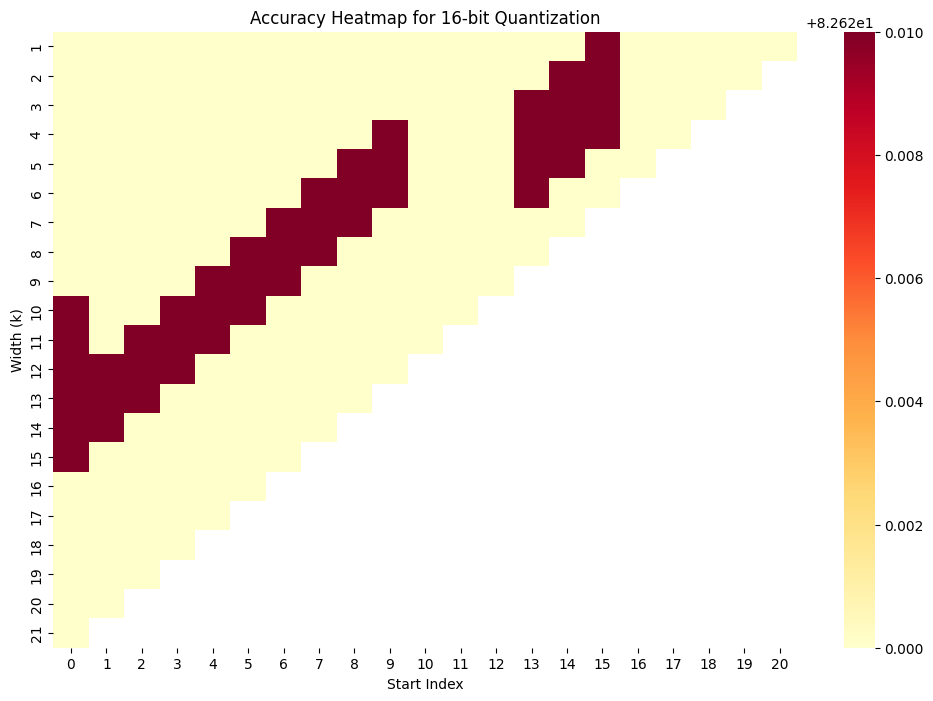

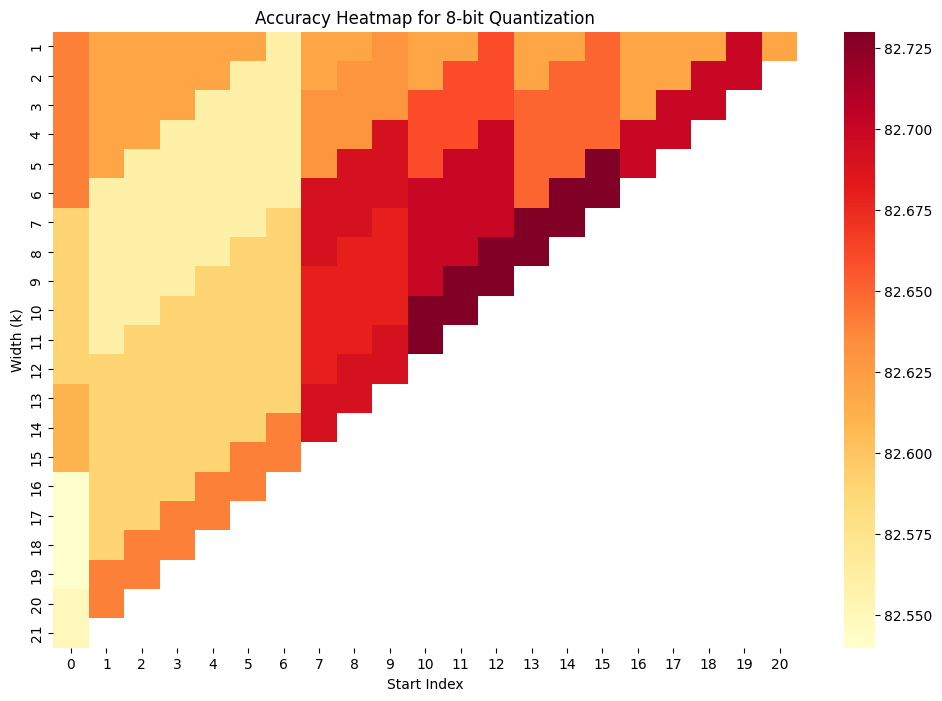

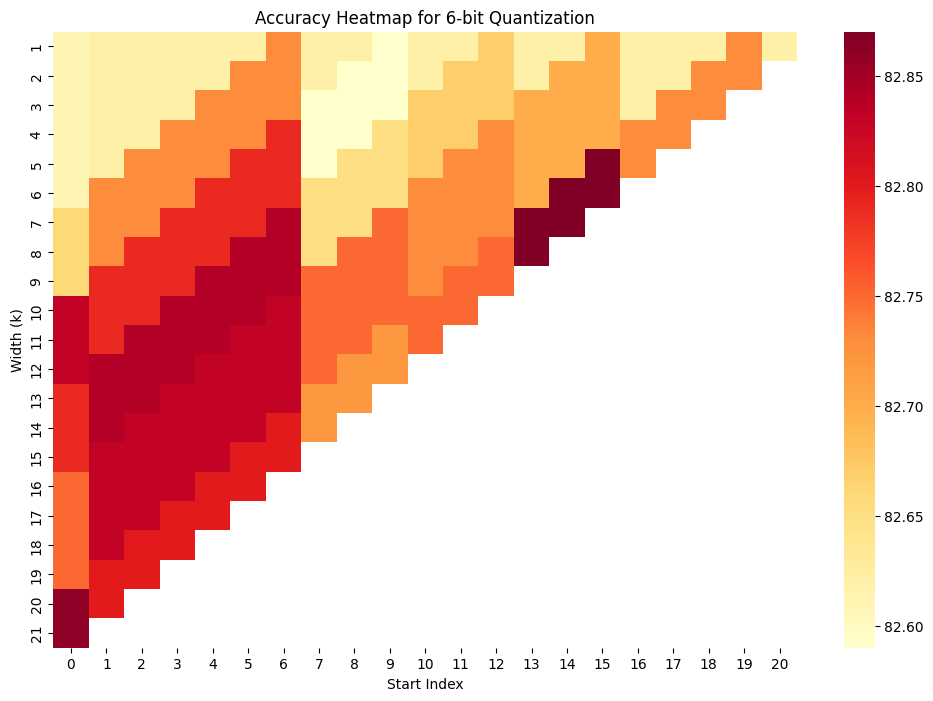

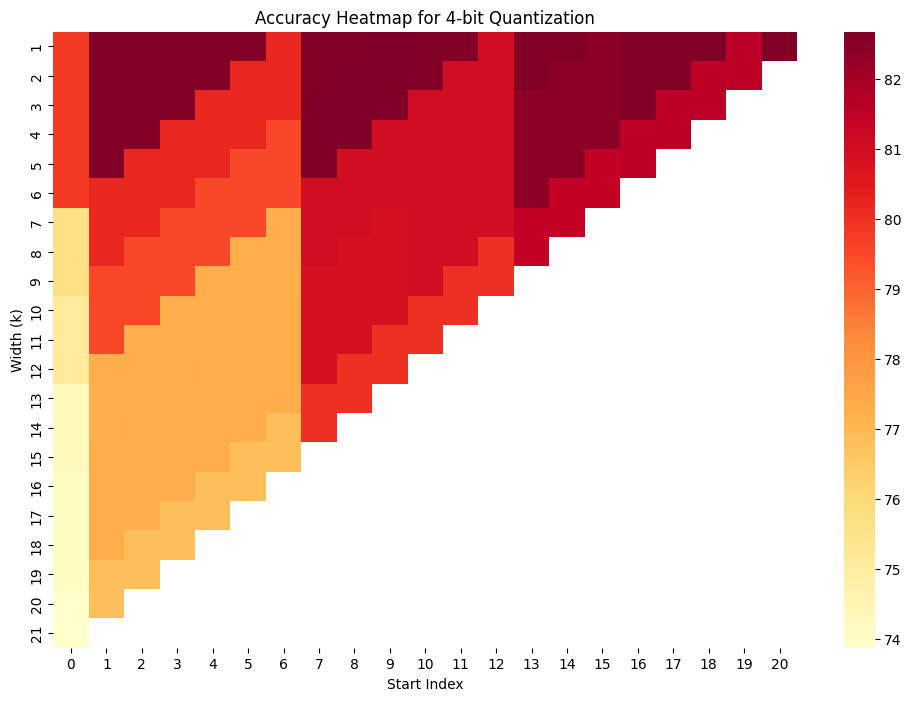

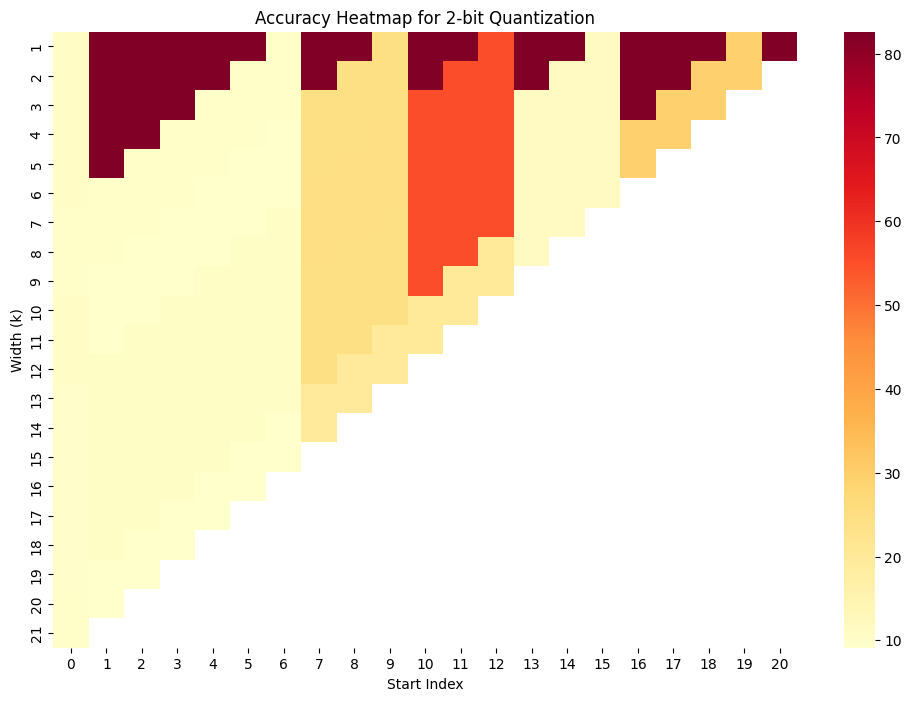

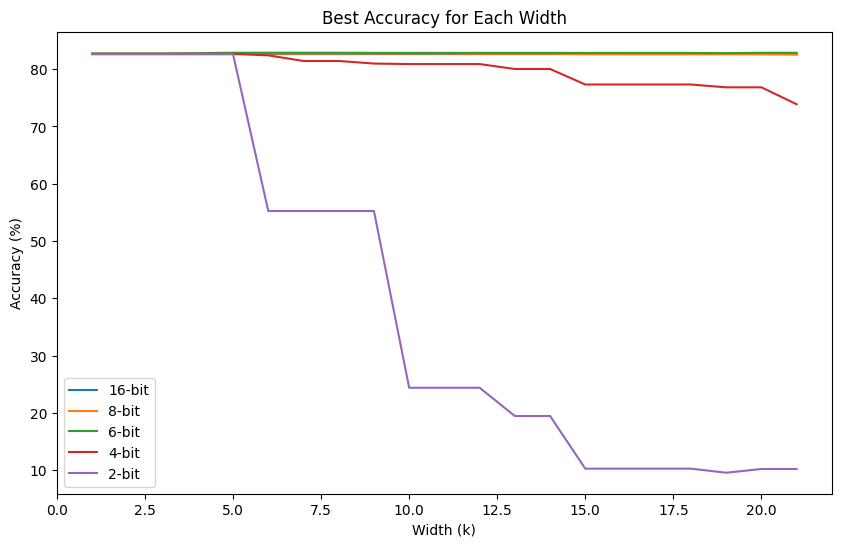

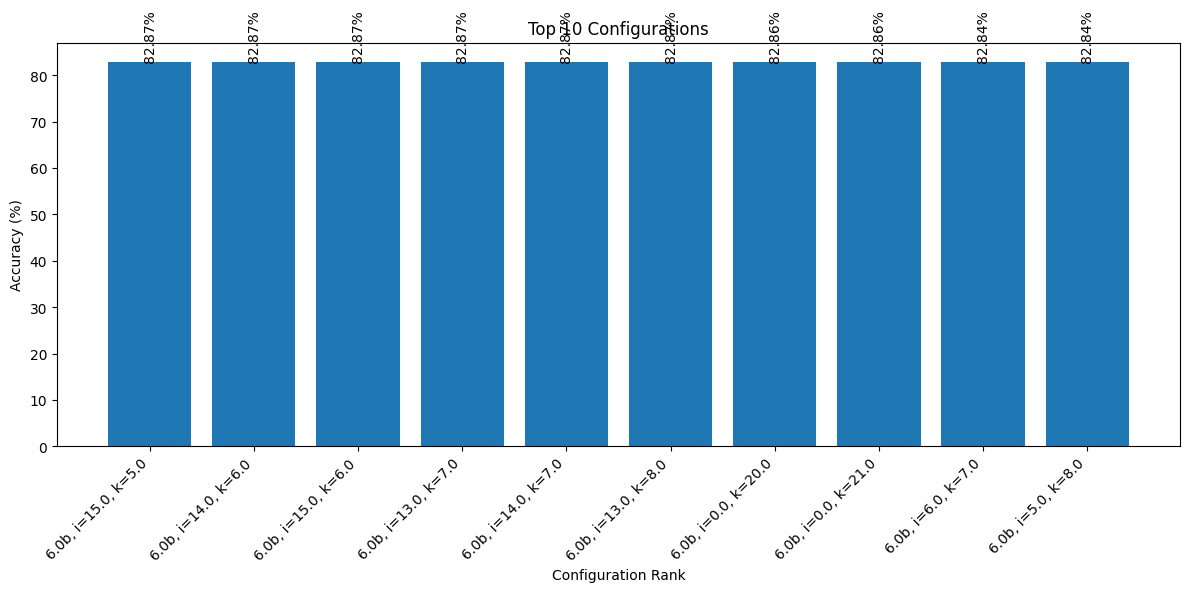

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Heatmap of accuracy for each bit size
for b, data in results.items():
    df = pd.DataFrame(data, columns=['start_index', 'width', 'accuracy'])
    pivot_table = df.pivot_table(values='accuracy', index='width', columns='start_index', aggfunc='first')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='YlOrRd', annot=False)
    plt.title(f'Accuracy Heatmap for {b}-bit Quantization')
    plt.xlabel('Start Index')
    plt.ylabel('Width (k)')
    plt.savefig(f'heatmap_{b}bit.png')
    plt.show()

# 2. Line plot of best accuracy for each width
plt.figure(figsize=(10, 6))
for b, data in results.items():
    df = pd.DataFrame(data, columns=['start_index', 'width', 'accuracy'])
    best_accuracy = df.groupby('width')['accuracy'].max()
    plt.plot(best_accuracy.index, best_accuracy.values, label=f'{b}-bit')

plt.title('Best Accuracy for Each Width')
plt.xlabel('Width (k)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('best_accuracy_per_width.png')
plt.show()

# 3. Bar plot of top N configurations
top_n = 10
all_results = []
for b, data in results.items():
    for i, k, acc in data:
        all_results.append((b, i, k, acc))

df_all = pd.DataFrame(all_results, columns=['bit_size', 'start_index', 'width', 'accuracy'])
top_configs = df_all.nlargest(top_n, 'accuracy')

plt.figure(figsize=(12, 6))
bars = plt.bar(range(top_n), top_configs['accuracy'])
plt.title(f'Top {top_n} Configurations')
plt.xlabel('Configuration Rank')
plt.ylabel('Accuracy (%)')
plt.xticks(range(top_n), [f"{row['bit_size']}b, i={row['start_index']}, k={row['width']}" for _, row in top_configs.iterrows()], rotation=45, ha='right')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{top_configs['accuracy'].iloc[i]:.2f}%", 
             ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.savefig('top_configurations.png')
plt.show()

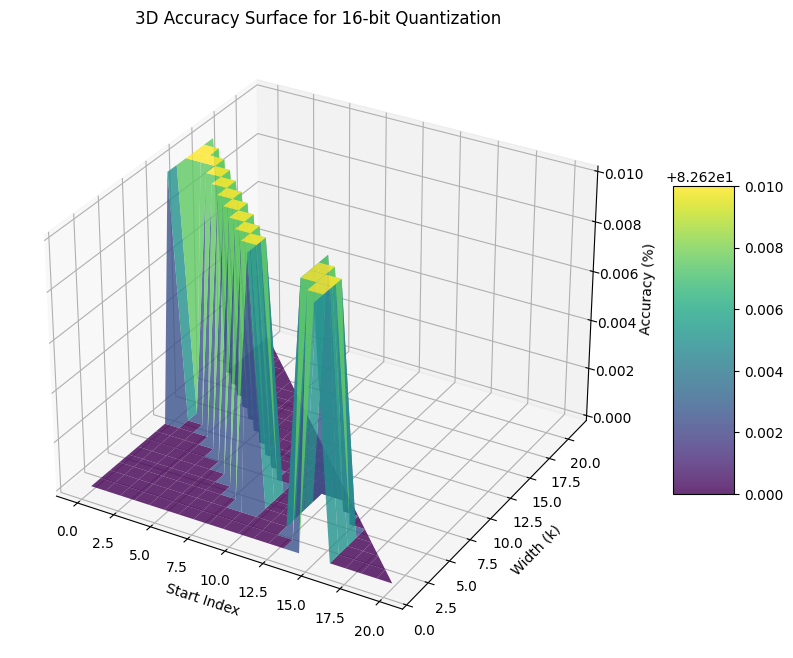

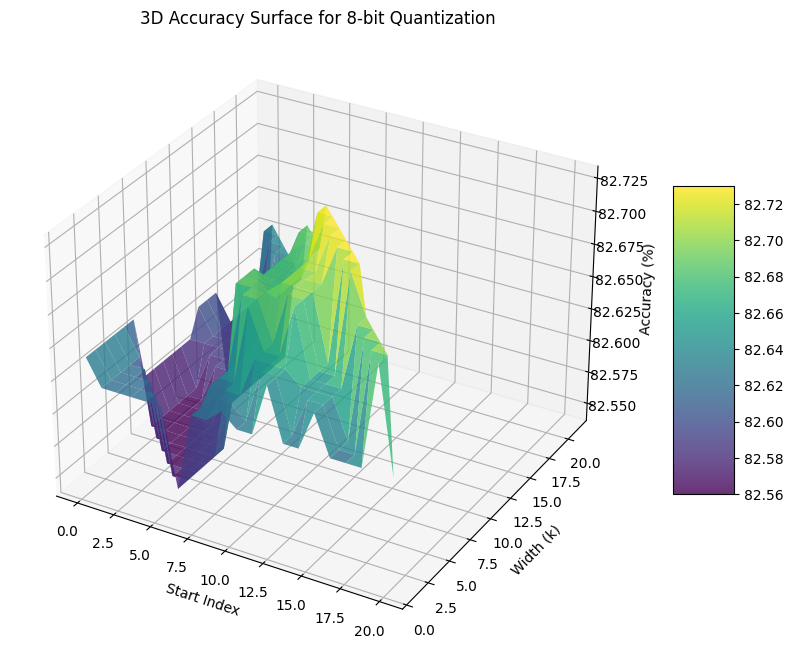

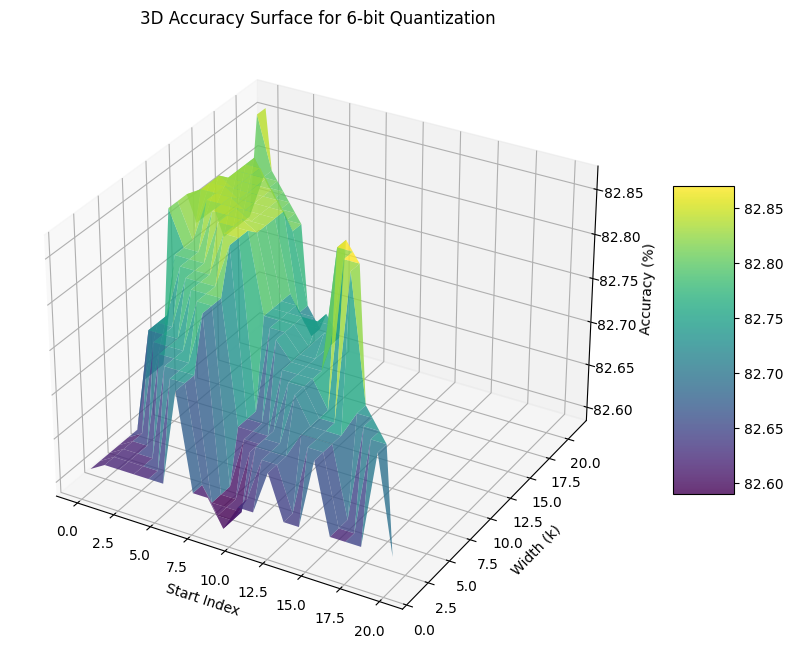

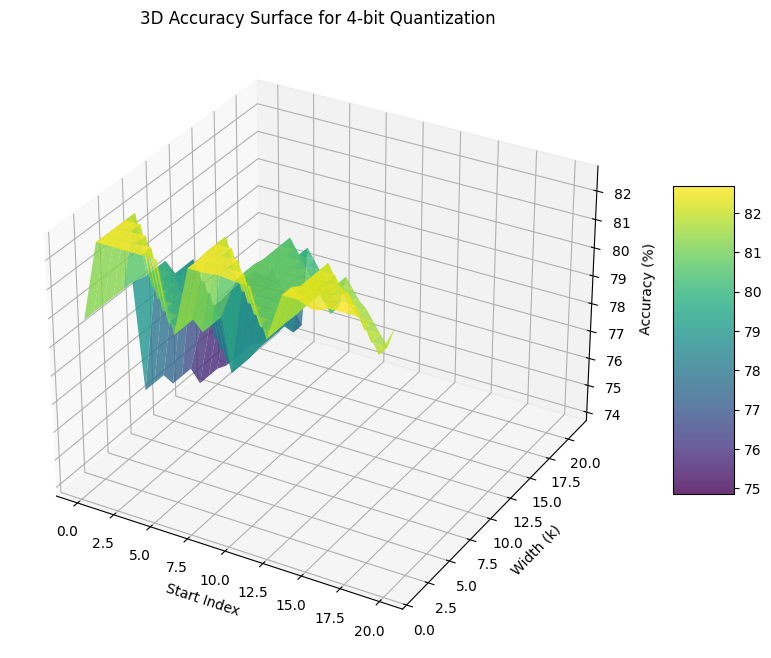

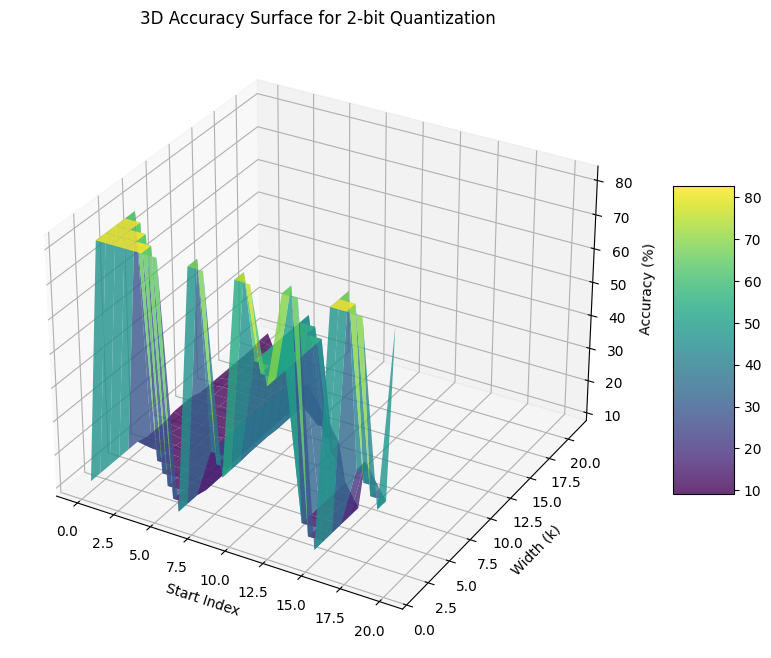

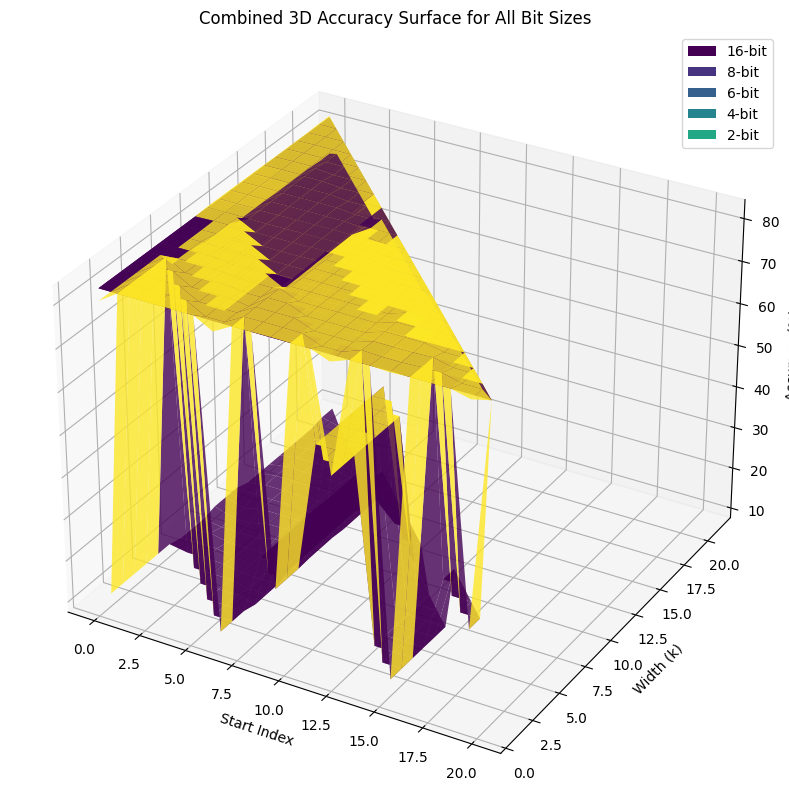

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

def create_3d_plot(df, bit_size):
    # Create a pivot table
    pivot = df.pivot_table(values='accuracy', index='width', columns='start_index', aggfunc='first')
    
    # Create meshgrid
    x = pivot.columns
    y = pivot.index
    X, Y = np.meshgrid(x, y)
    Z = pivot.values

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('Start Index')
    ax.set_ylabel('Width (k)')
    ax.set_zlabel('Accuracy (%)')
    ax.set_title(f'3D Accuracy Surface for {bit_size}-bit Quantization')

    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.savefig(f'3d_surface_{bit_size}bit.png')
    plt.show()

# Create 3D plots for each bit size
for b, data in results.items():
    df = pd.DataFrame(data, columns=['start_index', 'width', 'accuracy'])
    create_3d_plot(df, b)

# Create a combined 3D plot for all bit sizes
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

for b, data in results.items():
    df = pd.DataFrame(data, columns=['start_index', 'width', 'accuracy'])
    pivot = df.pivot_table(values='accuracy', index='width', columns='start_index', aggfunc='first')
    X, Y = np.meshgrid(pivot.columns, pivot.index)
    Z = pivot.values
    
    ax.plot_surface(X, Y, Z, cmap=plt.get_cmap('viridis', 2), alpha=0.8, label=f'{b}-bit')

ax.set_xlabel('Start Index')
ax.set_ylabel('Width (k)')
ax.set_zlabel('Accuracy (%)')
ax.set_title('Combined 3D Accuracy Surface for All Bit Sizes')

# Add a custom legend
proxy = [plt.Rectangle((0,0),1,1,fc = plt.cm.viridis(0.75*i/len(results))) for i in range(len(results))]
ax.legend(proxy, [f'{b}-bit' for b in results.keys()])

plt.savefig('3d_surface_combined.png')
plt.show()

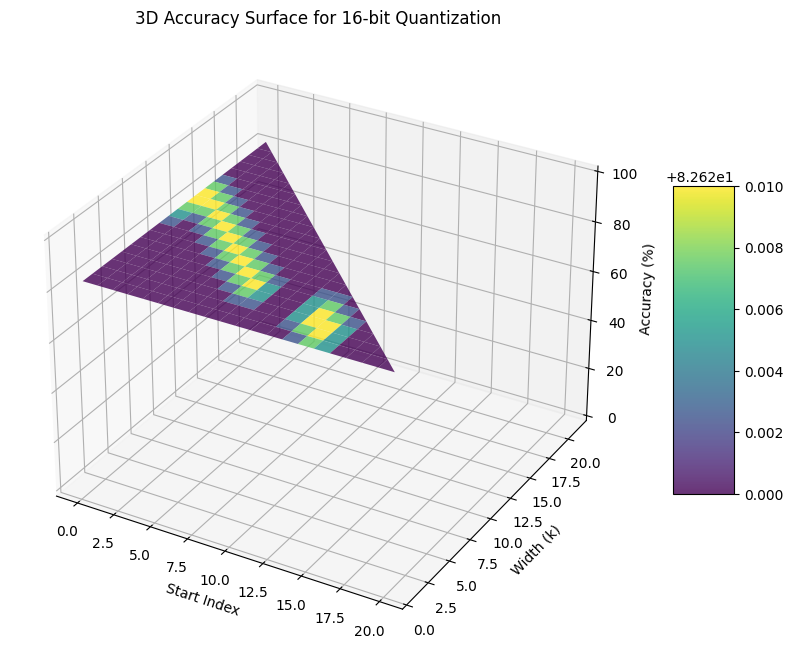

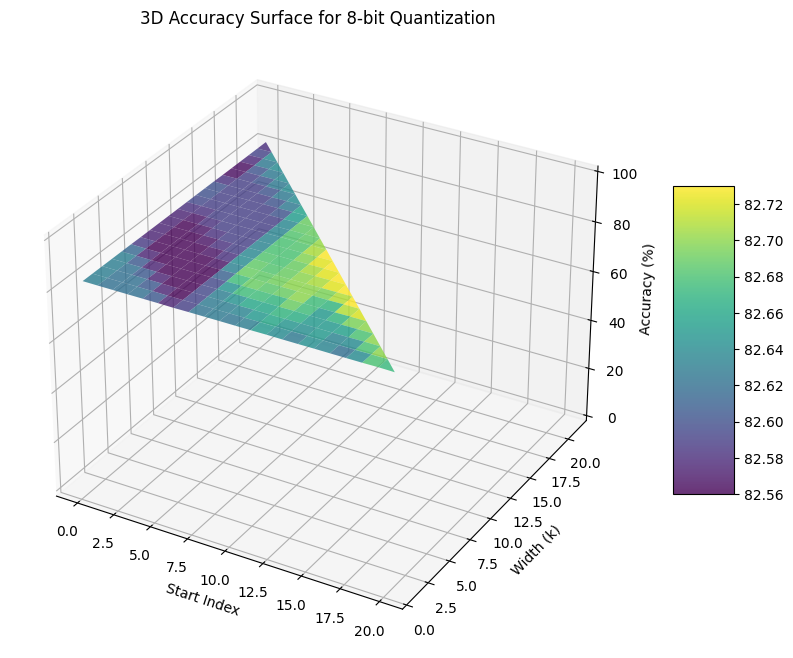

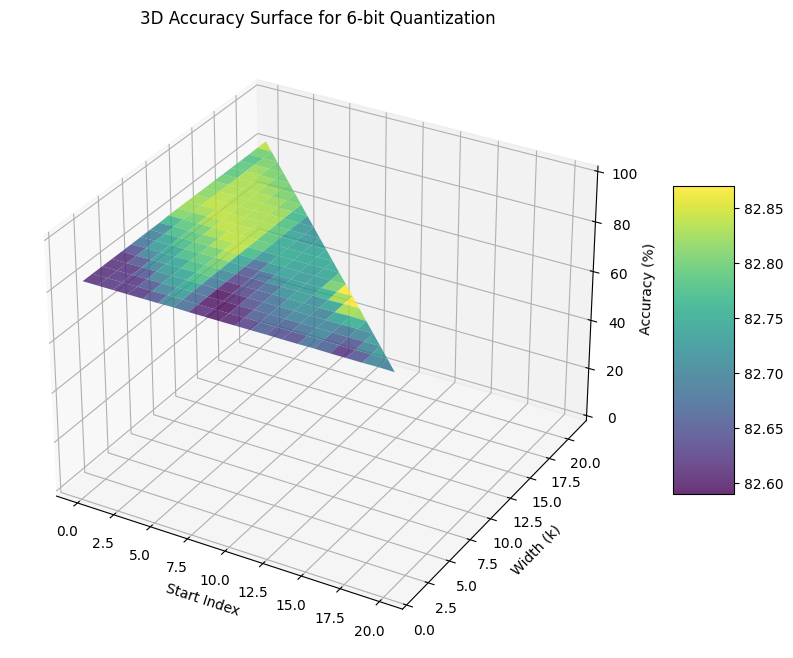

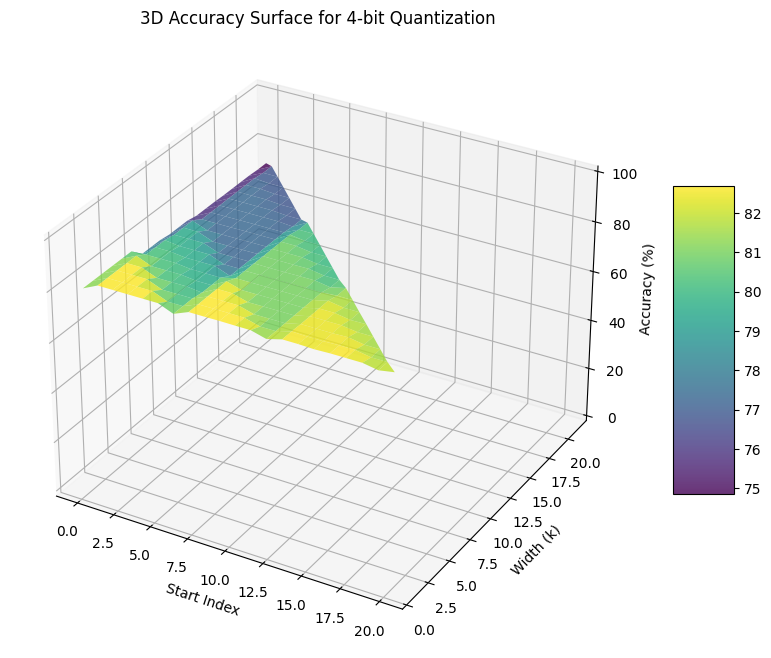

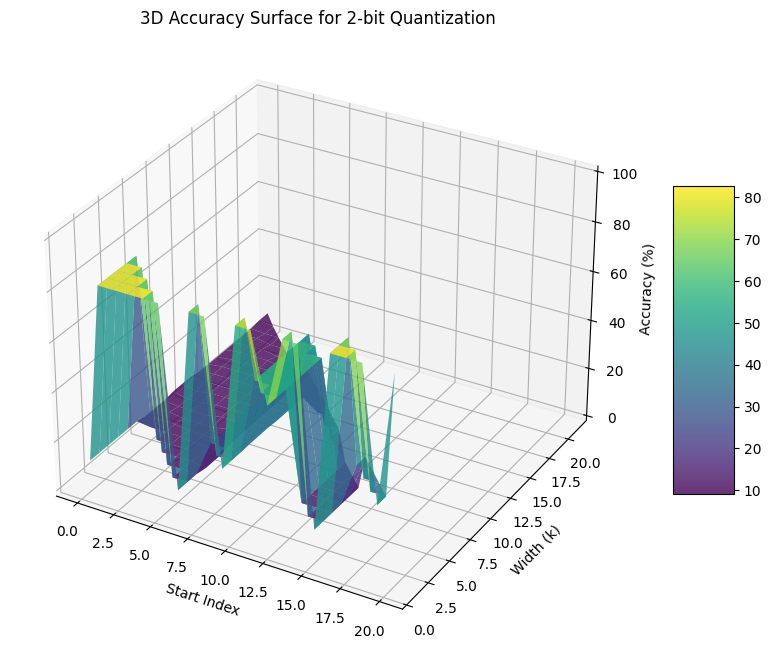

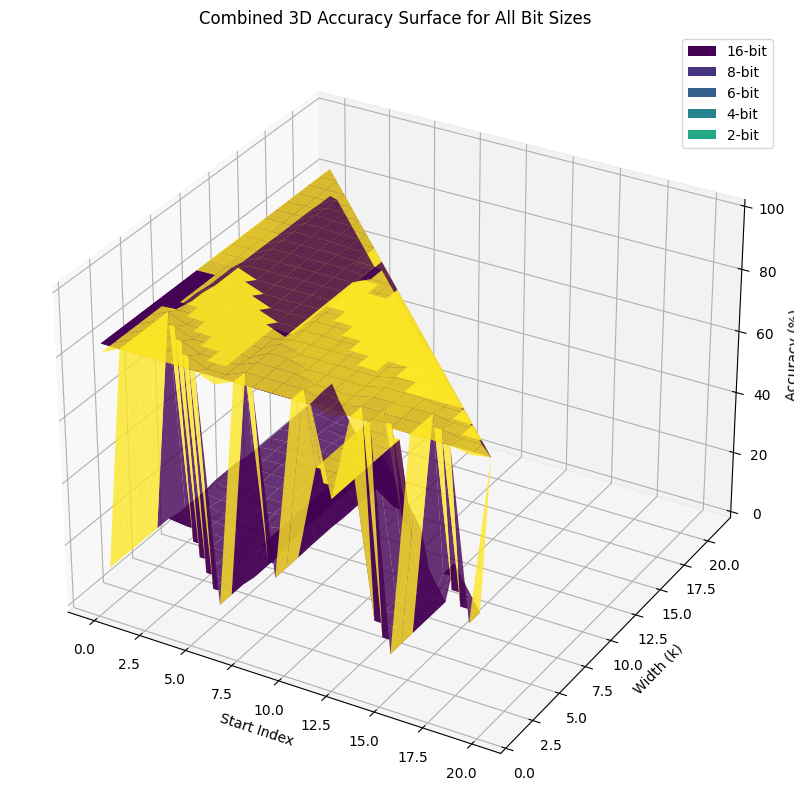

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

def create_3d_plot(df, bit_size):
    # Create a pivot table
    pivot = df.pivot_table(values='accuracy', index='width', columns='start_index', aggfunc='first')
    
    # Create meshgrid
    x = pivot.columns
    y = pivot.index
    X, Y = np.meshgrid(x, y)
    Z = pivot.values

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('Start Index')
    ax.set_ylabel('Width (k)')
    ax.set_zlabel('Accuracy (%)')
    ax.set_title(f'3D Accuracy Surface for {bit_size}-bit Quantization')
    
    # Set fixed range for Z-axis
    ax.set_zlim(0, 100)

    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.savefig(f'3d_surface_{bit_size}bit.png')
    plt.show()

# Create 3D plots for each bit size
for b, data in results.items():
    df = pd.DataFrame(data, columns=['start_index', 'width', 'accuracy'])
    create_3d_plot(df, b)

# Create a combined 3D plot for all bit sizes
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

for b, data in results.items():
    df = pd.DataFrame(data, columns=['start_index', 'width', 'accuracy'])
    pivot = df.pivot_table(values='accuracy', index='width', columns='start_index', aggfunc='first')
    X, Y = np.meshgrid(pivot.columns, pivot.index)
    Z = pivot.values
    
    ax.plot_surface(X, Y, Z, cmap=plt.get_cmap('viridis', 2), alpha=0.8, label=f'{b}-bit')

ax.set_xlabel('Start Index')
ax.set_ylabel('Width (k)')
ax.set_zlabel('Accuracy (%)')
ax.set_title('Combined 3D Accuracy Surface for All Bit Sizes')

# Set fixed range for Z-axis in combined plot
ax.set_zlim(0, 100)

# Add a custom legend
proxy = [plt.Rectangle((0,0),1,1,fc = plt.cm.viridis(0.75*i/len(results))) for i in range(len(results))]
ax.legend(proxy, [f'{b}-bit' for b in results.keys()])

plt.savefig('3d_surface_combined.png')
plt.show()